In [17]:
import os
import time
from new_main import instantiate_agents, instantiate_auction, compute_all_users_agent_similarity
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from collections import defaultdict
import json
import pickle
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
class Publisher:
    def __init__(self, rng, name, num_auctions):
        self.rng = rng
        self.name = name
        # Read from memory publisher embedding
        self.embedding = pickle.load(open("publisher_embedding/data/sites/" + name + ".pkl", "rb"))
        # Number of auctions to simulate according to past data
        self.num_auctions = num_auctions
        # Metrics of revenue
        self.revenue = .0

    def generate_user_context(self):
        # Definisci l'intensità del rumore
        noise_strength = 0.01
        # Genera il rumore gaussiano
        noise = np.random.normal(0, noise_strength, self.embedding.shape)
        # Aggiungi il rumore agli embedding originali
        noisy_embeddings = self.embedding + noise
        return noisy_embeddings

In [13]:
def get_random_publishers(num_publishers, num_auctions):
    sites_dir = "publisher_embedding/data/sites/"
    sites = [site.replace(".pkl", "") for site in os.listdir(sites_dir)]
    chosen_site_list = np.random.choice(sites, num_publishers, replace=False)
    return [
        {
            "name": site,
            "num_auctions": num_auctions
        }
        for site in chosen_site_list
    ]

In [23]:
def parse_config(path, num_publishers=100, num_auctions=1000):
    with open(path) as f:
        config = json.load(f)

    # Set up Random Number Generator
    rng = np.random.default_rng(config['random_seed'])
    np.random.seed(config['random_seed'])

    # Number of runs
    num_runs = config['num_runs'] if 'num_runs' in config.keys() else 1

    # Max. number of slots in every auction round
    # Multi-slot is currently not fully supported.
    max_slots = 1

    # Expand agent-config if there are multiple copies
    agent_configs = []
    num_agents = 0
    for agent_config in config['agents']:
        if 'num_copies' in agent_config.keys():
            for i in range(1, agent_config['num_copies'] + 1):
                agent_config_copy = deepcopy(agent_config)
                agent_config_copy['name'] += f' {num_agents + 1}'
                agent_configs.append(agent_config_copy)
                num_agents += 1
        else:
            agent_configs.append(agent_config)
            num_agents += 1

    # Read ads embeddings
    ads_embeddings = pickle.load(open('publisher_embedding/data/nuova_descr_annunci_embed.pkl', 'rb'))
    # Pick embeddings from a pre-defined set
    agents2items = {
        agent_config['name']: ads_embeddings[agent_config['product_name']]
        for agent_config in agent_configs
    }

    agents2item_values = {
        #agent_config['name']: rng.lognormal(0.1, 0.2, agent_config['num_items'])
        agent_config['name']: np.ones(agent_config['num_items'])
        for agent_config in agent_configs
    }

    # Publishers configs
    publisher_configs = get_random_publishers(num_publishers, num_auctions)

    return (rng, config, agent_configs, agents2items, agents2item_values, publisher_configs,
            num_runs, max_slots)

In [24]:
def instantiate_publishers(rng, publisher_configs):
    return [
        Publisher(
            rng=rng,
            name=publisher_config['name'],
            num_auctions=publisher_config['num_auctions'],
        )
        for publisher_config in publisher_configs
    ]

In [27]:
def run_repeated_auctions(num_iter_subscript=None):
    agents = instantiate_agents(rng, agent_configs, agents2item_values, agents2items)
    auction, num_iter, rounds_per_iter, output_dir = instantiate_auction(rng, config, agents2items, agents2item_values, agents, max_slots)
    publishers = instantiate_publishers(rng, publisher_configs)
    
    if num_iter_subscript is not None:
        num_iter = num_iter_subscript
    
    agent2net_utility = defaultdict(list)
    agent2gross_utility = defaultdict(list)
    
    for i in range(num_iter):
        print(f'==== ITERATION {i} ====')
        # Compute the similarity between all users and agents
        noise_strength = 0.01
        all_user_context, all_users_agent_similarity = compute_all_users_agent_similarity(publishers, noise_strength, agents2items)
        # Create a mask for each agent
        mask_pub_agent = {}
        for publisher in publishers:
            mask_pub_agent[publisher.name] = np.zeros(publisher.num_auctions)
        # Iteration
        # Variables to show progress bar
        pub_auctions = {publisher.name: publisher.num_auctions for publisher in publishers}
        total_auctions = sum(pub_auctions.values())
        with tqdm(total=total_auctions) as pbar:
            while not all(np.all(mask == 1) for mask in mask_pub_agent.values()):
                publisher = np.random.choice(publishers)
                mask = mask_pub_agent[publisher.name]
                # Catch the case when all auctions have been simulated for the current publisher
                try:
                    idx = np.where(mask == 0)[0][0]
                except IndexError:
                    continue

                curr_user_context = all_user_context[publisher.name][idx]
                auction.simulate_opportunity(all_users_agent_similarity, publisher.name, idx, curr_user_context)

                mask[idx] = 1
                pbar.update(1)

        names = [agent.name for agent in auction.agents]
        net_utilities = [agent.net_utility for agent in auction.agents]
        gross_utilities = [agent.gross_utility for agent in auction.agents]

        result = pd.DataFrame({'Name': names, 'Net': net_utilities, 'Gross': gross_utilities})

        print(result)
        print(f'\tAuction revenue: \t {auction.revenue}')

        num_auctions_won = 0
        for agent_id, agent in enumerate(auction.agents):
            print(f'Agent {agent.name} has spent {agent.get_agent_spent()}, '
                  f'winning {agent.get_agent_opp_won()} opportunities (win ratio: {agent.get_agent_won_ratio()})')
            print(f'Mean value paid for a won bid: {agent.get_mean_won_bid()}')

            num_auctions_won += agent.get_agent_opp_won()

            agent.update(iteration=i)

            agent2net_utility[agent.name].append(agent.net_utility)
            agent2gross_utility[agent.name].append(agent.gross_utility)

            #print(agent.agent_stats_won_publisher())

            agent.clear_utility()
            agent.clear_logs()

        print(f'Total number of auctions won: {num_auctions_won}')
        auction.clear_revenue()
    
    return agent2net_utility, agent2gross_utility

In [46]:
# Parse configuration file
(rng, config, agent_configs, agents2items, agents2item_values, publisher_configs, num_runs, max_slots) = parse_config('../new_config/FP_Oracle_auto_DR_others_auto_Truth.json', num_publishers=100, num_auctions=1000)

In [47]:
agents = instantiate_agents(rng, agent_configs, agents2item_values, agents2items)
auction, num_iter, rounds_per_iter, output_dir = instantiate_auction(rng, config, agents2items, agents2item_values, agents, max_slots)
publishers = instantiate_publishers(rng, publisher_configs)

==== ITERATION 0 ====


  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1 -149.837330  7858.0
1   Auto da corsa Scem 2  -29.530928  2905.0
2   Auto da corsa Scem 3  -23.426896  2896.0
3   Auto da corsa Scem 4  -42.502684  2923.0
4   Auto da corsa Scem 5  -28.643510  2888.0
	Auction revenue: 	 19743.9413498593
Agent Auto da corsa Smart 1 has spent 8007.83733039825, winning 40138 opportunities (win ratio: 0.503070714160379)
Mean value paid for a won bid: 0.19950763192979845


Auto da corsa Smart 1: 100%|██████████| 32768/32768 [00:37<00:00, 870.32it/s] 


AUC predicting P(win):				 0.9506187156001666
Estimated Utility	 Mean Error:			 0.0017106963018767164
Estimated Utility	 Mean Absolute Error:	 0.15576041408354602


Initialising Policy: 100%|██████████| 16384/16384 [01:24<00:00, 193.07it/s]


Predicted mu Gammas:  tensor(0.9846, grad_fn=<MinBackward1>) tensor(1.0337, grad_fn=<MaxBackward1>) tensor(0.9999, grad_fn=<MeanBackward0>)
Predicted sigma Gammas:  tensor(0.0455, grad_fn=<MinBackward1>) tensor(0.0549, grad_fn=<MaxBackward1>) tensor(0.0518, grad_fn=<MeanBackward0>)


Auto da corsa Smart 1:   5%|▍         | 1484/32768 [00:12<04:24, 118.45it/s]


Stopping at Epoch 1484
Auto da corsa Smart 1 Number of samples:  torch.Size([79786, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.76264846 0.9312549 0.8452109
               Publisher Name  Value       Bid     Price  Won
52  maternidad.enfemenino.com    1.0  0.157755  0.157755  447
63              quifinanza.it    1.0  0.235700  0.235700  436
75                 stylo24.it    1.0  0.155307  0.155307  432
97                 wordsa.com    1.0  0.149508  0.149508  429
28          finance.yahoo.com    1.0  0.272325  0.272325  426
..                        ...    ...       ...       ...  ...
96           webgirondins.com    1.0  0.190652  0.190652  374
0                    750g.com    1.0  0.138473  0.138473  374
23       diaridetarragona.com    1.0  0.233127  0.233127  371
33                 genius.com    1.0  0.129607  0.129607  365
86              tuttitalia.it    1.0  0.182830  0.182830  361

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 2934.53092829243, winning 14983 opp

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1   0.000000     0.0
1   Auto da corsa Scem 2 -40.231228  4834.0
2   Auto da corsa Scem 3  20.700538  4906.0
3   Auto da corsa Scem 4  32.284781  4950.0
4   Auto da corsa Scem 5   7.424357  4951.0
	Auction revenue: 	 19620.821551513764
Agent Auto da corsa Smart 1 has spent 0, winning 0 opportunities (win ratio: 0.0)
Mean value paid for a won bid: 0
Estimated Utility	 Mean Error:			 0.0064364676999966305
Estimated Utility	 Mean Absolute Error:	 0.0064364676999966305


Auto da corsa Smart 1: 100%|██████████| 32768/32768 [00:42<00:00, 776.26it/s]


Estimated Utility	 Mean Error:			 5.3352030233406375e-06
Estimated Utility	 Mean Absolute Error:	 5.3352030233406375e-06


Auto da corsa Smart 1:   2%|▏         | 529/32768 [00:04<04:27, 120.62it/s]


Stopping at Epoch 529
Auto da corsa Smart 1 Number of samples:  torch.Size([80008, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.6454205
No opportunities won
Empty DataFrame
Columns: [Item, Value, Bid, Price, True CTR, Estimated CTR, Won, Publisher Name]
Index: []
Agent Auto da corsa Scem 2 has spent 4874.231227924046, winning 24818 opportunities (win ratio: 0.3106638126353474)
Mean value paid for a won bid: 0.19639903408510137
                   Publisher Name  Value       Bid     Price  Won
83                    traveler.es    1.0  0.218299  0.218299  287
67  real-sociedad.diariovasco.com    1.0  0.211738  0.211738  282
17               comestarbene.com    1.0  0.176714  0.176714  277
39              journaldugeek.com    1.0  0.235525  0.235525  274
74                 strettoweb.com    1.0  0.197641  0.197641  272
..                            ...    ...       ...       ...  ...
10                 buzzwebzine.fr    1.0  0.231936  0.231936  224
48                      lercio.

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   27.514716   916.0
1   Auto da corsa Scem 2   -3.369776  4628.0
2   Auto da corsa Scem 3  -71.948995  4603.0
3   Auto da corsa Scem 4  -79.904288  4651.0
4   Auto da corsa Scem 5  112.744731  4802.0
	Auction revenue: 	 19614.963611548126
Agent Auto da corsa Smart 1 has spent 888.4852836033792, winning 4522 opportunities (win ratio: 0.05649604577653952)
Mean value paid for a won bid: 0.1964806023006146
AUC predicting P(win):				 0.895594161701922
Estimated Utility	 Mean Error:			 -0.0003416597517252077
Estimated Utility	 Mean Absolute Error:	 0.017595023732972344


Auto da corsa Smart 1: 100%|██████████| 32768/32768 [00:46<00:00, 701.83it/s]


AUC predicting P(win):				 0.9099679063575032
Estimated Utility	 Mean Error:			 -5.975796153878727e-05
Estimated Utility	 Mean Absolute Error:	 0.017876925523158765


Auto da corsa Smart 1:   2%|▏         | 673/32768 [00:05<04:22, 122.29it/s]


Stopping at Epoch 673
Auto da corsa Smart 1 Number of samples:  torch.Size([80041, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.7660883
                 Publisher Name  Value       Bid     Price  Won
5              bari.corriere.it    1.0  0.210132  0.210132   57
30        foro.sevillagrande.es    1.0  0.154411  0.154411   56
99                    zoom24.it    1.0  0.113973  0.113973   55
59                  oggiintv.eu    1.0  0.153512  0.153512   54
10               buzzwebzine.fr    1.0  0.230315  0.230315   54
..                          ...    ...       ...       ...  ...
26             f1ingenerale.com    1.0  0.286070  0.286070   36
98  yummmy.delectablerecipe.com    1.0  0.113776  0.113776   36
46           lavozdealmeria.com    1.0  0.212845  0.212845   35
83                  traveler.es    1.0  0.217452  0.217452   33
92           vikings.fandom.com    1.0  0.136426  0.136426   31

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4631.369776063203, winnin

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -28.397608  1446.0
1   Auto da corsa Scem 2 -31.716975  4492.0
2   Auto da corsa Scem 3  50.766880  4626.0
3   Auto da corsa Scem 4  35.261259  4537.0
4   Auto da corsa Scem 5  14.623524  4560.0
	Auction revenue: 	 19620.46291933324
Agent Auto da corsa Smart 1 has spent 1474.3976081059864, winning 7523 opportunities (win ratio: 0.09408571893095212)
Mean value paid for a won bid: 0.195985326080817
AUC predicting P(win):				 0.842572342271339
Estimated Utility	 Mean Error:			 0.0006507940167433743
Estimated Utility	 Mean Absolute Error:	 0.029016409557585818


Auto da corsa Smart 1:  76%|███████▋  | 25040/32768 [00:32<00:10, 766.77it/s]


Stopping at Epoch 25040
AUC predicting P(win):				 0.8435371353350858
Estimated Utility	 Mean Error:			 0.00040077974115689387
Estimated Utility	 Mean Absolute Error:	 0.028766395281999334


Auto da corsa Smart 1:   2%|▏         | 607/32768 [00:04<04:19, 124.08it/s]


Stopping at Epoch 607
Auto da corsa Smart 1 Number of samples:  torch.Size([79959, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.73535186
                   Publisher Name  Value       Bid     Price  Won
72                spanishdict.com    1.0  0.201075  0.201075   97
81                        time.is    1.0  0.208200  0.208200   88
53  mesinspirationsculinaires.com    1.0  0.147191  0.147191   88
44                  lapatilla.com    1.0  0.189463  0.189463   88
64           quizpatenteonline.it    1.0  0.330781  0.330781   87
..                            ...    ...       ...       ...  ...
12               calcionews24.com    1.0  0.166050  0.166050   61
71            solitariospider.org    1.0  0.149692  0.149692   61
38                    it.pons.com    1.0  0.193045  0.193045   61
95               voetbalnieuws.be    1.0  0.159769  0.159769   60
23           diaridetarragona.com    1.0  0.226480  0.226480   56

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -19.129111  1456.0
1   Auto da corsa Scem 2  44.372695  4574.0
2   Auto da corsa Scem 3 -80.824271  4440.0
3   Auto da corsa Scem 4  97.117822  4646.0
4   Auto da corsa Scem 5  83.798055  4628.0
	Auction revenue: 	 19618.664810170994
Agent Auto da corsa Smart 1 has spent 1475.1291106663282, winning 7515 opportunities (win ratio: 0.0940586004480769)
Mean value paid for a won bid: 0.19629129882452803
AUC predicting P(win):				 0.8474427674727084
Estimated Utility	 Mean Error:			 0.00028022361264306255
Estimated Utility	 Mean Absolute Error:	 0.028752702077711086


Auto da corsa Smart 1:  25%|██▍       | 8149/32768 [00:11<00:34, 716.32it/s]


Stopping at Epoch 8149
AUC predicting P(win):				 0.8452395605756426
Estimated Utility	 Mean Error:			 0.0002695570972647724
Estimated Utility	 Mean Absolute Error:	 0.0287420355623328


Auto da corsa Smart 1:   2%|▏         | 616/32768 [00:04<04:05, 130.94it/s]


Stopping at Epoch 616
Auto da corsa Smart 1 Number of samples:  torch.Size([79897, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.7964441
                Publisher Name  Value       Bid     Price  Won
60              poczta.onet.pl    1.0  0.176788  0.176788   96
79       tgverona.telenuovo.it    1.0  0.215481  0.215481   95
34                 gioianet.it    1.0  0.165451  0.165451   94
48                   lercio.it    1.0  0.181430  0.181430   93
81                     time.is    1.0  0.212301  0.212301   92
..                         ...    ...       ...       ...  ...
76           supercoloring.com    1.0  0.220418  0.220418   63
28           finance.yahoo.com    1.0  0.270486  0.270486   62
71         solitariospider.org    1.0  0.151251  0.151251   61
40  kalendrier.ouest-france.fr    1.0  0.175966  0.175966   60
78            termolionline.it    1.0  0.209272  0.209272   55

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4529.627304716737, winning 23072 oppo

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  26.239035  1514.0
1   Auto da corsa Scem 2 -27.350667  4517.0
2   Auto da corsa Scem 3 -73.077688  4452.0
3   Auto da corsa Scem 4  68.038333  4634.0
4   Auto da corsa Scem 5  32.644238  4529.0
	Auction revenue: 	 19619.506748654927
Agent Auto da corsa Smart 1 has spent 1487.760964582558, winning 7559 opportunities (win ratio: 0.09487173050855967)
Mean value paid for a won bid: 0.1968198127507022
AUC predicting P(win):				 0.8371477974682052
Estimated Utility	 Mean Error:			 -0.00029178881995138583
Estimated Utility	 Mean Absolute Error:	 0.029270444298032185


Auto da corsa Smart 1:   6%|▌         | 2045/32768 [00:02<00:40, 760.78it/s]


Stopping at Epoch 2045
AUC predicting P(win):				 0.8370212098729343
Estimated Utility	 Mean Error:			 -0.0002939305779455358
Estimated Utility	 Mean Absolute Error:	 0.02926830254003803


Auto da corsa Smart 1:  16%|█▌        | 5102/32768 [00:42<03:47, 121.42it/s]


Stopping at Epoch 5102
Auto da corsa Smart 1 Number of samples:  torch.Size([79676, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.94529575 1.0 0.98961645
               Publisher Name  Value       Bid     Price  Won
75                 stylo24.it    1.0  0.152512  0.152512  101
23       diaridetarragona.com    1.0  0.228238  0.228238   98
20              custojusto.pt    1.0  0.450943  0.450943   97
66          ravennanotizie.it    1.0  0.121513  0.121513   95
15                  chatib.us    1.0  0.109078  0.109078   93
..                        ...    ...       ...       ...  ...
17           comestarbene.com    1.0  0.175190  0.175190   61
37                 i24news.tv    1.0  0.140611  0.140611   61
30      foro.sevillagrande.es    1.0  0.160274  0.160274   54
96           webgirondins.com    1.0  0.188831  0.188831   54
52  maternidad.enfemenino.com    1.0  0.151802  0.151802   46

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4544.350666744037, winning 23175 opportu

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  23.636111  1041.0
1   Auto da corsa Scem 2  -6.014415  4636.0
2   Auto da corsa Scem 3 -67.586758  4531.0
3   Auto da corsa Scem 4 -17.590330  4651.0
4   Auto da corsa Scem 5  31.659722  4715.0
	Auction revenue: 	 19609.895669786598
Agent Auto da corsa Smart 1 has spent 1017.3638890072925, winning 4179 opportunities (win ratio: 0.05221400369833575)
Mean value paid for a won bid: 0.2434467310378781
AUC predicting P(win):				 0.9143405535565792
Estimated Utility	 Mean Error:			 -6.02852868135767e-05
Estimated Utility	 Mean Absolute Error:	 0.018637333226725856


Auto da corsa Smart 1:  32%|███▏      | 10377/32768 [00:12<00:27, 808.98it/s]


Stopping at Epoch 10377
AUC predicting P(win):				 0.8501347368683907
Estimated Utility	 Mean Error:			 -0.00023183502824152932
Estimated Utility	 Mean Absolute Error:	 0.018465783485297906


Auto da corsa Smart 1:   9%|▊         | 2819/32768 [00:24<04:23, 113.53it/s]


Stopping at Epoch 2819
Auto da corsa Smart 1 Number of samples:  torch.Size([80036, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.95721775 1.0 0.99926245
            Publisher Name  Value       Bid     Price  Won
3   automobile-magazine.fr    1.0  0.436782  0.436782  183
4              autonews.fr    1.0  0.409935  0.409935  180
20           custojusto.pt    1.0  0.450714  0.450714  171
47          leblogauto.com    1.0  0.429593  0.429593  156
64    quizpatenteonline.it    1.0  0.331632  0.331632  107
..                     ...    ...       ...       ...  ...
33              genius.com    1.0  0.134766  0.134766   13
6            basketusa.com    1.0  0.139112  0.139112   13
99               zoom24.it    1.0  0.116893  0.116893   13
92      vikings.fandom.com    1.0  0.148684  0.148684   12
15               chatib.us    1.0  0.122567  0.122567    9

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4642.014414914309, winning 23931 opportunities (win ratio: 0.299036575155884

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -34.105943  3614.0
1   Auto da corsa Scem 2 -41.184347  3924.0
2   Auto da corsa Scem 3 -21.007276  4006.0
3   Auto da corsa Scem 4  35.888993  4007.0
4   Auto da corsa Scem 5  -1.824645  4004.0
	Auction revenue: 	 19617.233217836223
Agent Auto da corsa Smart 1 has spent 3648.1059426312722, winning 18025 opportunities (win ratio: 0.22477024179167757)
Mean value paid for a won bid: 0.20239145312794854
AUC predicting P(win):				 0.558840636467852
Estimated Utility	 Mean Error:			 0.0004282425780719671
Estimated Utility	 Mean Absolute Error:	 0.07045000749260075


Auto da corsa Smart 1:  23%|██▎       | 7571/32768 [00:17<00:58, 434.25it/s]


Stopping at Epoch 7571
AUC predicting P(win):				 0.5612243630118808
Estimated Utility	 Mean Error:			 0.00043842363584247173
Estimated Utility	 Mean Absolute Error:	 0.07046018855037126


Auto da corsa Smart 1:   9%|▊         | 2860/32768 [00:34<06:03, 82.23it/s] 


Stopping at Epoch 2860
Auto da corsa Smart 1 Number of samples:  torch.Size([80193, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.9311924 1.0 0.9921958
                 Publisher Name  Value       Bid     Price  Won
78             termolionline.it    1.0  0.212407  0.212407  221
57           news.autoguide.com    1.0  0.240469  0.240469  219
74               strettoweb.com    1.0  0.200090  0.200090  216
32           gazzettadiparma.it    1.0  0.244134  0.244134  216
4                   autonews.fr    1.0  0.409426  0.409426  216
..                          ...    ...       ...       ...  ...
51                marcwiner.com    1.0  0.124798  0.124798  112
14           catalunyadiari.com    1.0  0.127903  0.127903  106
98  yummmy.delectablerecipe.com    1.0  0.119622  0.119622  102
99                    zoom24.it    1.0  0.118088  0.118088   95
15                    chatib.us    1.0  0.114586  0.114586   78

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 3965.184347388853,

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -87.591161  2223.0
1   Auto da corsa Scem 2  21.251176  4346.0
2   Auto da corsa Scem 3 -36.277297  4267.0
3   Auto da corsa Scem 4 -51.888010  4274.0
4   Auto da corsa Scem 5  74.451193  4428.0
	Auction revenue: 	 19618.054097844422
Agent Auto da corsa Smart 1 has spent 2310.5911608676984, winning 9915 opportunities (win ratio: 0.12402276565138533)
Mean value paid for a won bid: 0.23303995571030744
AUC predicting P(win):				 0.7845175495351786
Estimated Utility	 Mean Error:			 0.0012186380506320886
Estimated Utility	 Mean Absolute Error:	 0.04292145676853174


Auto da corsa Smart 1:  13%|█▎        | 4097/32768 [00:05<00:41, 698.86it/s]


Stopping at Epoch 4097
AUC predicting P(win):				 0.7784982057613951
Estimated Utility	 Mean Error:			 0.001161445171027765
Estimated Utility	 Mean Absolute Error:	 0.042864263888927424


Auto da corsa Smart 1:   2%|▏         | 757/32768 [00:07<05:11, 102.70it/s]


Stopping at Epoch 757
Auto da corsa Smart 1 Number of samples:  torch.Size([79945, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.91112727 1.0 0.98067355
            Publisher Name  Value       Bid     Price  Won
3   automobile-magazine.fr    1.0  0.438238  0.438238  222
4              autonews.fr    1.0  0.411358  0.411358  215
55      news.autoguide.com    1.0  0.242049  0.242049  210
31      gazzettadiparma.it    1.0  0.244797  0.244797  198
19           custojusto.pt    1.0  0.448866  0.448866  196
..                     ...    ...       ...       ...  ...
0                 750g.com    1.0  0.155258  0.155258    6
32              genius.com    1.0  0.149147  0.149147    5
96               zoom24.it    1.0  0.135274  0.135274    5
64       ravennanotizie.it    1.0  0.130112  0.130112    3
14               chatib.us    1.0  0.132002  0.132002    1

[97 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4324.748823898224, winning 22523 opportunities (win ratio: 0.2809755489021956)

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1  -32.929459  1049.0
1   Auto da corsa Scem 2   43.092024  4649.0
2   Auto da corsa Scem 3  -62.219101  4550.0
3   Auto da corsa Scem 4   19.666623  4690.0
4   Auto da corsa Scem 5  118.842567  4764.0
	Auction revenue: 	 19615.547345515268
Agent Auto da corsa Smart 1 has spent 1081.9294593369355, winning 3908 opportunities (win ratio: 0.04900682182985554)
Mean value paid for a won bid: 0.27684991282930793
AUC predicting P(win):				 0.9124341684661017
Estimated Utility	 Mean Error:			 0.0005628857888224523
Estimated Utility	 Mean Absolute Error:	 0.018881893172040847


Auto da corsa Smart 1:  15%|█▌        | 4929/32768 [00:06<00:35, 781.66it/s]


Stopping at Epoch 4929
AUC predicting P(win):				 0.9075693941427126
Estimated Utility	 Mean Error:			 0.0004751799228360904
Estimated Utility	 Mean Absolute Error:	 0.018794187306054488


Auto da corsa Smart 1:   9%|▉         | 2900/32768 [00:28<04:57, 100.46it/s]


Stopping at Epoch 2900
Auto da corsa Smart 1 Number of samples:  torch.Size([79744, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.80026084 1.0 0.8966513
               Publisher Name  Value       Bid     Price  Won
17              custojusto.pt    1.0  0.451673  0.451673  212
4                 autonews.fr    1.0  0.409691  0.409691  207
44             leblogauto.com    1.0  0.431119  0.431119  198
3      automobile-magazine.fr    1.0  0.436951  0.436951  187
60       quizpatenteonline.it    1.0  0.325241  0.325241  177
..                        ...    ...       ...       ...  ...
48  maternidad.enfemenino.com    1.0  0.169112  0.169112    2
77             topmercato.com    1.0  0.170557  0.170557    1
30                 genius.com    1.0  0.139069  0.139069    1
12          calciototale14.it    1.0  0.158779  0.158779    1
0                    750g.com    1.0  0.178151  0.178151    1

[92 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4605.907975792091, winning 23897 opportuni

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1   3.414234   332.0
1   Auto da corsa Scem 2  25.503843  4882.0
2   Auto da corsa Scem 3  -6.258713  4831.0
3   Auto da corsa Scem 4  44.436184  4817.0
4   Auto da corsa Scem 5 -22.442787  4801.0
	Auction revenue: 	 19618.34723797835
Agent Auto da corsa Smart 1 has spent 328.58576575179785, winning 759 opportunities (win ratio: 0.009454645108248835)
Mean value paid for a won bid: 0.43291932246613685
AUC predicting P(win):				 0.9852449231107436
Estimated Utility	 Mean Error:			 -6.406300711794914e-06
Estimated Utility	 Mean Absolute Error:	 0.004677673706661599


Auto da corsa Smart 1:  33%|███▎      | 10937/32768 [00:14<00:28, 766.24it/s]


Stopping at Epoch 10937
AUC predicting P(win):				 0.9851929886545623
Estimated Utility	 Mean Error:			 -3.329361240219197e-05
Estimated Utility	 Mean Absolute Error:	 0.004650786394971201


Auto da corsa Smart 1:   4%|▍         | 1433/32768 [00:15<05:30, 94.94it/s]


Stopping at Epoch 1433
Auto da corsa Smart 1 Number of samples:  torch.Size([80278, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.8970485 1.0 0.983351
           Publisher Name  Value       Bid     Price  Won
0  automobile-magazine.fr    1.0  0.439861  0.439861  197
2           custojusto.pt    1.0  0.450980  0.450980  191
3          leblogauto.com    1.0  0.430221  0.430221  188
1             autonews.fr    1.0  0.412733  0.412733  174
4    quizpatenteonline.it    1.0  0.344343  0.344343    9
Agent Auto da corsa Scem 2 has spent 4856.4961565180065, winning 24951 opportunities (win ratio: 0.31262999624107257)
Mean value paid for a won bid: 0.19464134329357566
            Publisher Name  Value       Bid     Price  Won
78        termolionline.it    1.0  0.209951  0.209951  280
88           vanityfair.it    1.0  0.171292  0.171292  278
9           boredpanda.com    1.0  0.187836  0.187836  273
77         superdeporte.es    1.0  0.235095  0.235095  272
15               chatib.us    1.0  0

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   70.330754  1202.0
1   Auto da corsa Scem 2   47.521589  4651.0
2   Auto da corsa Scem 3  -24.279727  4574.0
3   Auto da corsa Scem 4   45.639166  4684.0
4   Auto da corsa Scem 5 -121.606432  4523.0
	Auction revenue: 	 19616.394648990143
Agent Auto da corsa Smart 1 has spent 1131.669245663474, winning 4754 opportunities (win ratio: 0.059378239636286426)
Mean value paid for a won bid: 0.2380456974470917
AUC predicting P(win):				 0.8049244195669556
Estimated Utility	 Mean Error:			 -0.0008642764180794428
Estimated Utility	 Mean Absolute Error:	 0.02097096399146823


Auto da corsa Smart 1:  27%|██▋       | 8755/32768 [00:14<00:40, 593.93it/s]


Stopping at Epoch 8755
AUC predicting P(win):				 0.8606267126850082
Estimated Utility	 Mean Error:			 -0.0007849041460310772
Estimated Utility	 Mean Absolute Error:	 0.021050336263516593


Auto da corsa Smart 1:   3%|▎         | 1112/32768 [00:14<06:45, 78.14it/s]


Stopping at Epoch 1112
Auto da corsa Smart 1 Number of samples:  torch.Size([80063, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.9497099 1.0 0.9965092
            Publisher Name  Value       Bid     Price  Won
47          leblogauto.com    1.0  0.431934  0.431934  191
3   automobile-magazine.fr    1.0  0.438270  0.438270  187
20           custojusto.pt    1.0  0.451201  0.451201  179
4              autonews.fr    1.0  0.409677  0.409677  162
64    quizpatenteonline.it    1.0  0.329180  0.329180  121
..                     ...    ...       ...       ...  ...
97              wordsa.com    1.0  0.152933  0.152933   19
92      vikings.fandom.com    1.0  0.132126  0.132126   16
15               chatib.us    1.0  0.113233  0.113233   13
99               zoom24.it    1.0  0.118529  0.118529   12
14      catalunyadiari.com    1.0  0.127935  0.127935   11

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4603.47841088237, winning 23728 opportunities (win ratio: 0.2970306945070352)


  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1  -45.658545  2534.0
1   Auto da corsa Scem 2  129.217414  4376.0
2   Auto da corsa Scem 3  -11.174578  4253.0
3   Auto da corsa Scem 4   85.155417  4328.0
4   Auto da corsa Scem 5 -153.677449  4133.0
	Auction revenue: 	 19620.13773957372
Agent Auto da corsa Smart 1 has spent 2579.658544546358, winning 11973 opportunities (win ratio: 0.1495634142380673)
Mean value paid for a won bid: 0.21545632210359625
AUC predicting P(win):				 0.6894681284702174
Estimated Utility	 Mean Error:			 0.000596257898086458
Estimated Utility	 Mean Absolute Error:	 0.04887909748876239


Auto da corsa Smart 1:  13%|█▎        | 4100/32768 [00:08<01:02, 461.87it/s]


Stopping at Epoch 4100
AUC predicting P(win):				 0.6980817548699222
Estimated Utility	 Mean Error:			 0.0006221343873576665
Estimated Utility	 Mean Absolute Error:	 0.04890497397803359


Auto da corsa Smart 1:   2%|▏         | 513/32768 [00:05<06:05, 88.20it/s]


Stopping at Epoch 513
Auto da corsa Smart 1 Number of samples:  torch.Size([80053, 2])
Auto da corsa Smart 1 Predicted Gammas:  1.0 1.0 1.0
                 Publisher Name  Value       Bid     Price  Won
26             f1ingenerale.com    1.0  0.285201  0.285201  219
4                   autonews.fr    1.0  0.407207  0.407207  210
47               leblogauto.com    1.0  0.430320  0.430320  204
28            finance.yahoo.com    1.0  0.266962  0.266962  192
3        automobile-magazine.fr    1.0  0.437065  0.437065  191
..                          ...    ...       ...       ...  ...
14           catalunyadiari.com    1.0  0.128835  0.128835   49
98  yummmy.delectablerecipe.com    1.0  0.114656  0.114656   46
99                    zoom24.it    1.0  0.120508  0.120508   46
51                marcwiner.com    1.0  0.124580  0.124580   42
15                    chatib.us    1.0  0.113697  0.113697   35

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4246.7825856190575, winning 219

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -59.888176  3893.0
1   Auto da corsa Scem 2 -28.555494  3854.0
2   Auto da corsa Scem 3  70.594192  4018.0
3   Auto da corsa Scem 4 -42.031665  3884.0
4   Auto da corsa Scem 5 -56.228332  3862.0
	Auction revenue: 	 19627.109475239493
Agent Auto da corsa Smart 1 has spent 3952.8881755155858, winning 20135 opportunities (win ratio: 0.25156486212971174)
Mean value paid for a won bid: 0.19631925381254461
AUC predicting P(win):				 0.5004131583632065
Estimated Utility	 Mean Error:			 0.0007482374281988757
Estimated Utility	 Mean Absolute Error:	 0.07694960919792075


Auto da corsa Smart 1:  13%|█▎        | 4277/32768 [00:07<00:47, 594.95it/s]


Stopping at Epoch 4277
AUC predicting P(win):				 0.5004130783577041
Estimated Utility	 Mean Error:			 0.0007482374281988757
Estimated Utility	 Mean Absolute Error:	 0.07694960919792075


Auto da corsa Smart 1:   6%|▋         | 2112/32768 [00:23<05:36, 91.07it/s]


Stopping at Epoch 2112
Auto da corsa Smart 1 Number of samples:  torch.Size([80039, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.7390333 1.0 0.9997523
                 Publisher Name  Value       Bid     Price  Won
50           m.tuttoreggina.com    1.0  0.172858  0.172858  223
46           lavozdealmeria.com    1.0  0.214030  0.214030  223
34                  gioianet.it    1.0  0.163383  0.163383  223
22                  dexerto.com    1.0  0.166650  0.166650  222
42          lacartedescolocs.fr    1.0  0.236253  0.236253  220
..                          ...    ...       ...       ...  ...
37                   i24news.tv    1.0  0.142413  0.142413  185
98  yummmy.delectablerecipe.com    1.0  0.115242  0.115242  184
78             termolionline.it    1.0  0.209913  0.209913  183
88                vanityfair.it    1.0  0.171994  0.171994  179
54         messagerie.orange.fr    1.0  0.201341  0.201341  176

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 3882.55549420296, 

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -74.659374  3821.0
1   Auto da corsa Scem 2   7.330989  3881.0
2   Auto da corsa Scem 3 -50.549353  3904.0
3   Auto da corsa Scem 4 -43.950099  3905.0
4   Auto da corsa Scem 5 -64.237701  3882.0
	Auction revenue: 	 19619.06553803752
Agent Auto da corsa Smart 1 has spent 3895.659374112277, winning 19916 opportunities (win ratio: 0.2487168279737746)
Mean value paid for a won bid: 0.19560450763769216
AUC predicting P(win):				 0.5003614279860719
Estimated Utility	 Mean Error:			 0.0009337232829827789
Estimated Utility	 Mean Absolute Error:	 0.07566423330711121


Auto da corsa Smart 1:   4%|▍         | 1327/32768 [00:02<00:50, 625.80it/s]


Stopping at Epoch 1327
AUC predicting P(win):				 0.5050114727270851
Estimated Utility	 Mean Error:			 0.0009337112494125537
Estimated Utility	 Mean Absolute Error:	 0.075664221273541


Auto da corsa Smart 1:   2%|▏         | 520/32768 [00:05<05:48, 92.58it/s]


Stopping at Epoch 520
Auto da corsa Smart 1 Number of samples:  torch.Size([80075, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.8089157 1.0 0.99999464
                Publisher Name  Value       Bid     Price  Won
1                adnkronos.com    1.0  0.171551  0.171551  228
33                  genius.com    1.0  0.126975  0.126975  222
57          news.autoguide.com    1.0  0.241779  0.241779  221
5             bari.corriere.it    1.0  0.207158  0.207158  219
66           ravennanotizie.it    1.0  0.125995  0.125995  218
..                         ...    ...       ...       ...  ...
30       foro.sevillagrande.es    1.0  0.158584  0.158584  178
27              familyfeed.net    1.0  0.170732  0.170732  178
24           es.planetcalc.com    1.0  0.205600  0.205600  176
40  kalendrier.ouest-france.fr    1.0  0.176357  0.176357  175
85           turistipercaso.it    1.0  0.208684  0.208684  163

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 3873.669010789524, winning 197

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -49.936379  3884.0
1   Auto da corsa Scem 2 -15.175701  3901.0
2   Auto da corsa Scem 3  25.111235  3995.0
3   Auto da corsa Scem 4 -30.204167  3846.0
4   Auto da corsa Scem 5  48.322148  3969.0
	Auction revenue: 	 19616.88286419761
Agent Auto da corsa Smart 1 has spent 3933.9363790855577, winning 20095 opportunities (win ratio: 0.25105255924940345)
Mean value paid for a won bid: 0.19576692605551418
AUC predicting P(win):				 0.501482383679192
Estimated Utility	 Mean Error:			 0.0006238976649677652
Estimated Utility	 Mean Absolute Error:	 0.0767229889534816


Auto da corsa Smart 1:   3%|▎         | 1026/32768 [00:01<00:48, 651.64it/s]


Stopping at Epoch 1026
AUC predicting P(win):				 0.5014835591194047
Estimated Utility	 Mean Error:			 0.0006238980175710927
Estimated Utility	 Mean Absolute Error:	 0.07672298930608493


Auto da corsa Smart 1:   3%|▎         | 920/32768 [00:12<06:57, 76.28it/s]


Stopping at Epoch 920
Auto da corsa Smart 1 Number of samples:  torch.Size([80043, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.8617369 1.0 0.9686222
                   Publisher Name  Value       Bid     Price  Won
0                        750g.com    1.0  0.136812  0.136812  232
53  mesinspirationsculinaires.com    1.0  0.149006  0.149006  231
70             skyscrapercity.com    1.0  0.246277  0.246277  227
39              journaldugeek.com    1.0  0.232683  0.232683  227
10                 buzzwebzine.fr    1.0  0.232727  0.232727  224
..                            ...    ...       ...       ...  ...
12               calcionews24.com    1.0  0.167843  0.167843  178
56                    metro.co.uk    1.0  0.169870  0.169870  178
23           diaridetarragona.com    1.0  0.231196  0.231196  174
77                superdeporte.es    1.0  0.231772  0.231772  166
61                       polki.pl    1.0  0.193602  0.193602  160

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has s

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1   8.352936   605.0
1   Auto da corsa Scem 2  36.547820  4827.0
2   Auto da corsa Scem 3 -33.735308  4718.0
3   Auto da corsa Scem 4 -74.084012  4689.0
4   Auto da corsa Scem 5  22.565974  4747.0
	Auction revenue: 	 19626.35259070016
Agent Auto da corsa Smart 1 has spent 596.6470642683095, winning 2363 opportunities (win ratio: 0.029562998085849043)
Mean value paid for a won bid: 0.25249558369374075
AUC predicting P(win):				 0.951475909764326
Estimated Utility	 Mean Error:			 0.00026435042654593437
Estimated Utility	 Mean Absolute Error:	 0.011001567717314214


Auto da corsa Smart 1:  37%|███▋      | 12072/32768 [00:24<00:41, 495.39it/s]


Stopping at Epoch 12072
AUC predicting P(win):				 0.9239437812373863
Estimated Utility	 Mean Error:			 -2.070526721929047e-05
Estimated Utility	 Mean Absolute Error:	 0.010716512023548987


Auto da corsa Smart 1:   7%|▋         | 2346/32768 [00:31<06:44, 75.25it/s]


Stopping at Epoch 2346
Auto da corsa Smart 1 Number of samples:  torch.Size([79931, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.9016049 1.0 0.98181635
                 Publisher Name  Value       Bid     Price  Won
20                custojusto.pt    1.0  0.452525  0.452525  137
47               leblogauto.com    1.0  0.432113  0.432113  132
3        automobile-magazine.fr    1.0  0.438398  0.438398  119
4                   autonews.fr    1.0  0.411567  0.411567  107
64         quizpatenteonline.it    1.0  0.330586  0.330586   65
..                          ...    ...       ...       ...  ...
14           catalunyadiari.com    1.0  0.132712  0.132712    8
0                      750g.com    1.0  0.132874  0.132874    8
98  yummmy.delectablerecipe.com    1.0  0.115016  0.115016    7
92           vikings.fandom.com    1.0  0.141703  0.141703    6
33                   genius.com    1.0  0.129847  0.129847    6

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4790.452180452435

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   -2.542531  1058.0
1   Auto da corsa Scem 2   -8.238507  4661.0
2   Auto da corsa Scem 3  130.929883  4722.0
3   Auto da corsa Scem 4   43.096667  4658.0
4   Auto da corsa Scem 5   41.073792  4730.0
	Auction revenue: 	 19624.680696116335
Agent Auto da corsa Smart 1 has spent 1060.5425312966754, winning 3957 opportunities (win ratio: 0.04935145921676228)
Mean value paid for a won bid: 0.26801681357004686
AUC predicting P(win):				 0.9068796235336383
Estimated Utility	 Mean Error:			 9.792083003025712e-05
Estimated Utility	 Mean Absolute Error:	 0.01856790919448494


Auto da corsa Smart 1: 100%|██████████| 32768/32768 [00:56<00:00, 576.08it/s]


AUC predicting P(win):				 0.904526624226851
Estimated Utility	 Mean Error:			 8.928183566024601e-05
Estimated Utility	 Mean Absolute Error:	 0.01855927020011493


Auto da corsa Smart 1:   2%|▏         | 516/32768 [00:08<09:21, 57.47it/s]


Stopping at Epoch 516
Auto da corsa Smart 1 Number of samples:  torch.Size([80180, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.5061901 1.0 0.7880304
                 Publisher Name  Value       Bid     Price  Won
4                   autonews.fr    1.0  0.407949  0.407949  232
18                custojusto.pt    1.0  0.450795  0.450795  193
62         quizpatenteonline.it    1.0  0.330814  0.330814  185
45               leblogauto.com    1.0  0.430793  0.430793  178
3        automobile-magazine.fr    1.0  0.435687  0.435687  173
..                          ...    ...       ...       ...  ...
35                   i24news.tv    1.0  0.150845  0.150845    3
64            ravennanotizie.it    1.0  0.129881  0.129881    1
49                marcwiner.com    1.0  0.126284  0.126284    1
31                   genius.com    1.0  0.154006  0.154006    1
96  yummmy.delectablerecipe.com    1.0  0.109991  0.109991    1

[97 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4669.23850674776, wi

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   -1.611282     0.0
1   Auto da corsa Scem 2   73.997650  5013.0
2   Auto da corsa Scem 3 -104.668991  4795.0
3   Auto da corsa Scem 4   -5.797923  4850.0
4   Auto da corsa Scem 5  -68.854516  4853.0
	Auction revenue: 	 19617.935063140154
Agent Auto da corsa Smart 1 has spent 1.6112822133758034, winning 8 opportunities (win ratio: 0.0001000612875386174)
Mean value paid for a won bid: 0.20141027667197542
AUC predicting P(win):				 0.9995449883041667
Estimated Utility	 Mean Error:			 2.310596129789301e-05
Estimated Utility	 Mean Absolute Error:	 2.310596129789301e-05


Auto da corsa Smart 1:   6%|▌         | 1971/32768 [00:03<00:49, 625.22it/s]


Stopping at Epoch 1971
AUC predicting P(win):				 0.9997701487309709
Estimated Utility	 Mean Error:			 2.1995540769178384e-05
Estimated Utility	 Mean Absolute Error:	 2.1995540769178384e-05


Auto da corsa Smart 1:   2%|▏         | 516/32768 [00:05<05:33, 96.69it/s]


Stopping at Epoch 516
Auto da corsa Smart 1 Number of samples:  torch.Size([79951, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.44861647
                      Publisher Name  Value       Bid     Price  Won
0                     boredpanda.com    1.0  0.186924  0.186924    1
1                     codycross.info    1.0  0.178559  0.178559    1
2  hugolescargot.journaldesfemmes.fr    1.0  0.237619  0.237619    1
3                       kyivpost.com    1.0  0.191213  0.191213    1
4                lacartedescolocs.fr    1.0  0.241435  0.241435    1
5          maternidad.enfemenino.com    1.0  0.125044  0.125044    1
6                      quifinanza.it    1.0  0.233454  0.233454    1
7                         unilad.com    1.0  0.217034  0.217034    1
Agent Auto da corsa Scem 2 has spent 4939.002350159936, winning 25105 opportunities (win ratio: 0.3138517314664333)
Mean value paid for a won bid: 0.1967338119960142
                Publisher Name  Value       Bid     Price  Won
28 

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1   0.597734     1.0
1   Auto da corsa Scem 2  29.909803  4924.0
2   Auto da corsa Scem 3 -35.098308  4874.0
3   Auto da corsa Scem 4 -81.970905  4824.0
4   Auto da corsa Scem 5  84.032815  4988.0
	Auction revenue: 	 19613.528862117593
Agent Auto da corsa Smart 1 has spent 0.40226643081161995, winning 2 opportunities (win ratio: 2.4951344877488898e-05)
Mean value paid for a won bid: 0.20113321540580997
AUC predicting P(win):				 0.9999937620081344
Estimated Utility	 Mean Error:			 -7.435132691506064e-06
Estimated Utility	 Mean Absolute Error:	 1.2195754781576923e-05


Auto da corsa Smart 1:   5%|▍         | 1614/32768 [00:02<00:45, 679.79it/s]


Stopping at Epoch 1614
AUC predicting P(win):				 1.0
Estimated Utility	 Mean Error:			 -7.288027122620992e-06
Estimated Utility	 Mean Absolute Error:	 1.2342860350461995e-05


Auto da corsa Smart 1:   2%|▏         | 776/32768 [00:08<05:42, 93.38it/s]


Stopping at Epoch 776
Auto da corsa Smart 1 Number of samples:  torch.Size([80156, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.7010614
      Publisher Name  Value       Bid     Price  Won
0  lagrosseradio.com    1.0  0.189033  0.189033    1
1        turbolab.it    1.0  0.213233  0.213233    1
Agent Auto da corsa Scem 2 has spent 4894.090197369155, winning 25011 opportunities (win ratio: 0.3126609495712178)
Mean value paid for a won bid: 0.19567750979045842
           Publisher Name  Value       Bid     Price  Won
0                750g.com    1.0  0.135544  0.135544  299
10         buzzwebzine.fr    1.0  0.232911  0.232911  278
76      supercoloring.com    1.0  0.220520  0.220520  274
95       voetbalnieuws.be    1.0  0.160140  0.160140  272
39      journaldugeek.com    1.0  0.234239  0.234239  270
..                    ...    ...       ...       ...  ...
64   quizpatenteonline.it    1.0  0.327947  0.327947  224
89          velo-club.net    1.0  0.194804  0.194804  223
79  tg

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  -2.062686  1326.0
1   Auto da corsa Scem 2  54.809166  4667.0
2   Auto da corsa Scem 3 -49.583036  4525.0
3   Auto da corsa Scem 4  12.920072  4570.0
4   Auto da corsa Scem 5  15.044085  4561.0
	Auction revenue: 	 19617.872399458403
Agent Auto da corsa Smart 1 has spent 1328.0626864651713, winning 6806 opportunities (win ratio: 0.08507180980713223)
Mean value paid for a won bid: 0.1951311616904454
AUC predicting P(win):				 0.8592065257809395
Estimated Utility	 Mean Error:			 5.023559431372101e-05
Estimated Utility	 Mean Absolute Error:	 0.026026408867853724


Auto da corsa Smart 1:   5%|▍         | 1549/32768 [00:02<00:56, 549.61it/s]


Stopping at Epoch 1549
AUC predicting P(win):				 0.8610050277091087
Estimated Utility	 Mean Error:			 4.7381507390563354e-05
Estimated Utility	 Mean Absolute Error:	 0.026023554780930568


Auto da corsa Smart 1:   4%|▍         | 1245/32768 [00:14<06:00, 87.49it/s]


Stopping at Epoch 1245
Auto da corsa Smart 1 Number of samples:  torch.Size([80003, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.5083097
                   Publisher Name  Value       Bid     Price  Won
19               culturequizz.com    1.0  0.204161  0.204161   86
96               webgirondins.com    1.0  0.186384  0.186384   86
62     programme-tv.nouvelobs.com    1.0  0.160714  0.160714   85
45             lavoroediritti.com    1.0  0.155934  0.155934   84
99                      zoom24.it    1.0  0.113289  0.113289   83
..                            ...    ...       ...       ...  ...
66              ravennanotizie.it    1.0  0.124423  0.124423   53
67  real-sociedad.diariovasco.com    1.0  0.207814  0.207814   53
69                     riazor.org    1.0  0.203155  0.203155   52
85              turistipercaso.it    1.0  0.209727  0.209727   51
71            solitariospider.org    1.0  0.150899  0.150899   49

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1    7.446150  1844.0
1   Auto da corsa Scem 2   24.029900  4461.0
2   Auto da corsa Scem 3 -127.735094  4304.0
3   Auto da corsa Scem 4  -58.544861  4390.0
4   Auto da corsa Scem 5  -17.025848  4451.0
	Auction revenue: 	 19621.829753117796
Agent Auto da corsa Smart 1 has spent 1836.5538501167925, winning 9387 opportunities (win ratio: 0.11723931207613623)
Mean value paid for a won bid: 0.19564864707753196
AUC predicting P(win):				 0.805541405020815
Estimated Utility	 Mean Error:			 -9.036225964292023e-05
Estimated Utility	 Mean Absolute Error:	 0.035957643111725425


Auto da corsa Smart 1:   3%|▎         | 1126/32768 [00:02<00:58, 543.90it/s]


Stopping at Epoch 1126
AUC predicting P(win):				 0.8055367635369002
Estimated Utility	 Mean Error:			 -9.014930727185527e-05
Estimated Utility	 Mean Absolute Error:	 0.03595785606409651


Auto da corsa Smart 1:   7%|▋         | 2206/32768 [00:22<05:17, 96.35it/s] 


Stopping at Epoch 2206
Auto da corsa Smart 1 Number of samples:  torch.Size([80067, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.70885485 1.0 0.9989837
               Publisher Name  Value       Bid     Price  Won
99                  zoom24.it    1.0  0.116293  0.116293  117
52  maternidad.enfemenino.com    1.0  0.155194  0.155194  115
23       diaridetarragona.com    1.0  0.226161  0.226161  110
71        solitariospider.org    1.0  0.150973  0.150973  110
97                 wordsa.com    1.0  0.146577  0.146577  110
..                        ...    ...       ...       ...  ...
42        lacartedescolocs.fr    1.0  0.237787  0.237787   81
20              custojusto.pt    1.0  0.451764  0.451764   81
57         news.autoguide.com    1.0  0.237782  0.237782   79
8       bologna.repubblica.it    1.0  0.151823  0.151823   76
45         lavoroediritti.com    1.0  0.153413  0.153413   73

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4436.970099617238, winning 22571 opportun

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   25.881819  3836.0
1   Auto da corsa Scem 2  -80.013534  3861.0
2   Auto da corsa Scem 3 -104.258220  3864.0
3   Auto da corsa Scem 4   30.907434  3957.0
4   Auto da corsa Scem 5    6.039727  3978.0
	Auction revenue: 	 19617.442774396022
Agent Auto da corsa Smart 1 has spent 3810.1181807898383, winning 19502 opportunities (win ratio: 0.24354059218002672)
Mean value paid for a won bid: 0.1953706379237944
AUC predicting P(win):				 0.512941228331217
Estimated Utility	 Mean Error:			 -0.0003169779053024236
Estimated Utility	 Mean Absolute Error:	 0.0747684609467463


Auto da corsa Smart 1:   3%|▎         | 1036/32768 [00:01<00:48, 657.19it/s]


Stopping at Epoch 1036
AUC predicting P(win):				 0.512944665971379
Estimated Utility	 Mean Error:			 -0.00031707961084112725
Estimated Utility	 Mean Absolute Error:	 0.07476835924120759


Auto da corsa Smart 1:  12%|█▏        | 4051/32768 [00:42<05:03, 94.75it/s] 


Stopping at Epoch 4051
Auto da corsa Smart 1 Number of samples:  torch.Size([80077, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.92641425 1.0 0.9973828
                Publisher Name  Value       Bid     Price  Won
19            culturequizz.com    1.0  0.205705  0.205705  222
28           finance.yahoo.com    1.0  0.266867  0.266867  218
1                adnkronos.com    1.0  0.172266  0.172266  218
40  kalendrier.ouest-france.fr    1.0  0.178474  0.178474  218
64        quizpatenteonline.it    1.0  0.331317  0.331317  217
..                         ...    ...       ...       ...  ...
66           ravennanotizie.it    1.0  0.124974  0.124974  171
16              codycross.info    1.0  0.193698  0.193698  170
20               custojusto.pt    1.0  0.451729  0.451729  169
87                  unilad.com    1.0  0.219578  0.219578  165
74              strettoweb.com    1.0  0.197558  0.197558  159

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 3941.0135344930036, winning 2

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  12.348389  2920.0
1   Auto da corsa Scem 2 -72.503740  4173.0
2   Auto da corsa Scem 3  28.637719  4201.0
3   Auto da corsa Scem 4 -61.105783  4118.0
4   Auto da corsa Scem 5  29.204584  4152.0
	Auction revenue: 	 19627.41882989841
Agent Auto da corsa Smart 1 has spent 2907.6516106373033, winning 16332 opportunities (win ratio: 0.20333665338645418)
Mean value paid for a won bid: 0.17803401975491692
AUC predicting P(win):				 0.6241254779800357
Estimated Utility	 Mean Error:			 -7.382287087186832e-05
Estimated Utility	 Mean Absolute Error:	 0.05910093996623757


Auto da corsa Smart 1:  13%|█▎        | 4359/32768 [00:06<00:42, 664.66it/s]


Stopping at Epoch 4359
AUC predicting P(win):				 0.6119239848440232
Estimated Utility	 Mean Error:			 -0.00011365116842809061
Estimated Utility	 Mean Absolute Error:	 0.059061111668681346


Auto da corsa Smart 1:   2%|▏         | 517/32768 [00:05<06:05, 88.33it/s] 


Stopping at Epoch 517
Auto da corsa Smart 1 Number of samples:  torch.Size([80320, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.9531412 1.0 0.99999535
          Publisher Name  Value       Bid     Price  Won
13    catalunyadiari.com    1.0  0.122116  0.122116  227
88     video.gazzetta.it    1.0  0.167626  0.167626  218
48         marcwiner.com    1.0  0.121167  0.121167  217
85         vanityfair.it    1.0  0.171391  0.171391  214
10   calcionapoli1926.it    1.0  0.137292  0.137292  213
..                   ...    ...       ...       ...  ...
30    gazzettadiparma.it    1.0  0.240239  0.240239   97
26     finance.yahoo.com    1.0  0.260943  0.260943   70
24      f1ingenerale.com    1.0  0.277354  0.277354   45
61  quizpatenteonline.it    1.0  0.317547  0.317547   17
3            autonews.fr    1.0  0.403094  0.403094    1

[97 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4245.503739782138, winning 21207 opportunities (win ratio: 0.26512726909036355)
Mean value paid for a w

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  26.261942  3952.0
1   Auto da corsa Scem 2  43.107497  3950.0
2   Auto da corsa Scem 3 -24.563222  3875.0
3   Auto da corsa Scem 4  68.803595  4014.0
4   Auto da corsa Scem 5  36.410619  3977.0
	Auction revenue: 	 19617.979570505562
Agent Auto da corsa Smart 1 has spent 3925.7380583182317, winning 20006 opportunities (win ratio: 0.24968175124179418)
Mean value paid for a won bid: 0.19622803450555992
AUC predicting P(win):				 0.499166019073187
Estimated Utility	 Mean Error:			 -0.0003277012819688581
Estimated Utility	 Mean Absolute Error:	 0.0769758938991771


Auto da corsa Smart 1:  13%|█▎        | 4242/32768 [00:07<00:50, 567.97it/s]


Stopping at Epoch 4242
AUC predicting P(win):				 0.49919664320264795
Estimated Utility	 Mean Error:			 -0.0003276645788230591
Estimated Utility	 Mean Absolute Error:	 0.07697593060232288


Auto da corsa Smart 1:   3%|▎         | 1033/32768 [00:13<07:05, 74.58it/s]


Stopping at Epoch 1033
Auto da corsa Smart 1 Number of samples:  torch.Size([80126, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.71055955 1.0 0.99960864
      Publisher Name  Value       Bid     Price  Won
0           750g.com    1.0  0.136416  0.136416  226
96  webgirondins.com    1.0  0.187564  0.187564  225
19  culturequizz.com    1.0  0.204195  0.204195  224
5   bari.corriere.it    1.0  0.210280  0.210280  222
68   reggionline.com    1.0  0.211908  0.211908  221
..               ...    ...       ...       ...  ...
49    losarcanos.com    1.0  0.191178  0.191178  182
47    leblogauto.com    1.0  0.431068  0.431068  180
73      spunteblu.it    1.0  0.194804  0.194804  178
88     vanityfair.it    1.0  0.172728  0.172728  170
35     guiasteam.com    1.0  0.202449  0.202449  167

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 3906.8925032501543, winning 19897 opportunities (win ratio: 0.2493952194131435)
Mean value paid for a won bid: 0.19635585783033394
                P

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  61.052951  3996.0
1   Auto da corsa Scem 2  26.378907  3909.0
2   Auto da corsa Scem 3 -35.506230  3867.0
3   Auto da corsa Scem 4 -33.698868  3899.0
4   Auto da corsa Scem 5  24.296018  3987.0
	Auction revenue: 	 19615.47722127994
Agent Auto da corsa Smart 1 has spent 3934.9470489987066, winning 20031 opportunities (win ratio: 0.2508421513994114)
Mean value paid for a won bid: 0.1964428660076235
AUC predicting P(win):				 0.5035822504838015
Estimated Utility	 Mean Error:			 -0.0007628795939949103
Estimated Utility	 Mean Absolute Error:	 0.07764537396133935


Auto da corsa Smart 1:   4%|▎         | 1220/32768 [00:01<00:51, 610.61it/s]


Stopping at Epoch 1220
AUC predicting P(win):				 0.5051497125997897
Estimated Utility	 Mean Error:			 -0.000762850188373154
Estimated Utility	 Mean Absolute Error:	 0.07764540336696109


Auto da corsa Smart 1:   2%|▏         | 521/32768 [00:05<06:01, 89.12it/s]


Stopping at Epoch 521
Auto da corsa Smart 1 Number of samples:  torch.Size([79855, 2])
Auto da corsa Smart 1 Predicted Gammas:  1.0 1.0 1.0
            Publisher Name  Value       Bid     Price  Won
60          poczta.onet.pl    1.0  0.175840  0.175840  237
48               lercio.it    1.0  0.179300  0.179300  235
80     tierce-magazine.com    1.0  0.188719  0.188719  228
3   automobile-magazine.fr    1.0  0.438927  0.438927  224
26        f1ingenerale.com    1.0  0.283711  0.283711  224
..                     ...    ...       ...       ...  ...
70      skyscrapercity.com    1.0  0.248526  0.248526  178
33              genius.com    1.0  0.127456  0.127456  178
71     solitariospider.org    1.0  0.151590  0.151590  176
41            kyivpost.com    1.0  0.172881  0.172881  175
90        vidademadrid.com    1.0  0.203508  0.203508  161

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 3882.6210925986325, winning 19803 opportunities (win ratio: 0.2474076110042228)
Mean value 

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -44.041760  3862.0
1   Auto da corsa Scem 2   9.954675  3931.0
2   Auto da corsa Scem 3 -28.244485  3887.0
3   Auto da corsa Scem 4 -60.948705  3866.0
4   Auto da corsa Scem 5  79.030553  4024.0
	Auction revenue: 	 19614.249722787015
Agent Auto da corsa Smart 1 has spent 3906.0417604594822, winning 19899 opportunities (win ratio: 0.2484052579674685)
Mean value paid for a won bid: 0.1962933695391468
AUC predicting P(win):				 0.5010166040871535
Estimated Utility	 Mean Error:			 0.0005497907976349836
Estimated Utility	 Mean Absolute Error:	 0.07595312285691025


Auto da corsa Smart 1:   3%|▎         | 1027/32768 [00:01<00:58, 540.13it/s]


Stopping at Epoch 1027
AUC predicting P(win):				 0.5010171641503919
Estimated Utility	 Mean Error:			 0.000549790736865338
Estimated Utility	 Mean Absolute Error:	 0.07595312279614061


Auto da corsa Smart 1:   2%|▏         | 513/32768 [00:05<06:11, 86.80it/s]


Stopping at Epoch 513
Auto da corsa Smart 1 Number of samples:  torch.Size([80107, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.91531473 1.0 0.9999959
                       Publisher Name  Value       Bid     Price  Won
16                     codycross.info    1.0  0.191922  0.191922  230
23               diaridetarragona.com    1.0  0.230469  0.230469  226
76                  supercoloring.com    1.0  0.220385  0.220385  221
60                     poczta.onet.pl    1.0  0.177432  0.177432  218
58                       novagente.pt    1.0  0.194996  0.194996  218
..                                ...    ...       ...       ...  ...
42                lacartedescolocs.fr    1.0  0.235149  0.235149  179
36  hugolescargot.journaldesfemmes.fr    1.0  0.214582  0.214582  179
10                     buzzwebzine.fr    1.0  0.233439  0.233439  178
72                    spanishdict.com    1.0  0.199912  0.199912  176
74                     strettoweb.com    1.0  0.198392  0.198392  172

[100 r

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   47.301088  3939.0
1   Auto da corsa Scem 2   31.212075  3924.0
2   Auto da corsa Scem 3 -138.662339  3790.0
3   Auto da corsa Scem 4   16.061252  3975.0
4   Auto da corsa Scem 5  -12.605447  3928.0
	Auction revenue: 	 19612.6933705169
Agent Auto da corsa Smart 1 has spent 3891.6989119343166, winning 19877 opportunities (win ratio: 0.24805321219987023)
Mean value paid for a won bid: 0.1957890482434128
AUC predicting P(win):				 0.4978669831829873
Estimated Utility	 Mean Error:			 -0.0005902609824599986
Estimated Utility	 Mean Absolute Error:	 0.07655563058784541


Auto da corsa Smart 1:   4%|▎         | 1226/32768 [00:02<00:59, 531.21it/s]


Stopping at Epoch 1226
AUC predicting P(win):				 0.5022166504068063
Estimated Utility	 Mean Error:			 -0.0005902611850661984
Estimated Utility	 Mean Absolute Error:	 0.07655563038523922


Auto da corsa Smart 1:  10%|▉         | 3219/32768 [00:43<06:39, 73.91it/s]


Stopping at Epoch 3219
Auto da corsa Smart 1 Number of samples:  torch.Size([80132, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.76486856 1.0 0.95081437
            Publisher Name  Value       Bid     Price  Won
4              autonews.fr    1.0  0.407289  0.407289  228
8    bologna.repubblica.it    1.0  0.153690  0.153690  225
92      vikings.fandom.com    1.0  0.135913  0.135913  225
89           velo-club.net    1.0  0.196226  0.196226  222
78        termolionline.it    1.0  0.211476  0.211476  219
..                     ...    ...       ...       ...  ...
42     lacartedescolocs.fr    1.0  0.234019  0.234019  178
3   automobile-magazine.fr    1.0  0.437771  0.437771  177
35           guiasteam.com    1.0  0.205902  0.205902  176
22             dexerto.com    1.0  0.166660  0.166660  175
25          eterritoire.fr    1.0  0.198838  0.198838  174

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 3892.787924750534, winning 19857 opportunities (win ratio: 0.248048168088641

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1   4.801427   440.0
1   Auto da corsa Scem 2  10.810756  4751.0
2   Auto da corsa Scem 3 -64.149839  4795.0
3   Auto da corsa Scem 4   9.084292  4776.0
4   Auto da corsa Scem 5  76.578603  4896.0
	Auction revenue: 	 19620.874761038333
Agent Auto da corsa Smart 1 has spent 435.1985727647334, winning 2309 opportunities (win ratio: 0.028895368481647875)
Mean value paid for a won bid: 0.18847924329351814
AUC predicting P(win):				 0.9571979407116037
Estimated Utility	 Mean Error:			 0.0001851212847251858
Estimated Utility	 Mean Absolute Error:	 0.008914789094013184


Auto da corsa Smart 1:   7%|▋         | 2146/32768 [00:04<01:06, 460.49it/s]


Stopping at Epoch 2146
AUC predicting P(win):				 0.9560567512601965
Estimated Utility	 Mean Error:			 2.7335133742102464e-05
Estimated Utility	 Mean Absolute Error:	 0.008757002943030102


Auto da corsa Smart 1:  10%|█         | 3427/32768 [00:40<05:50, 83.82it/s]


Stopping at Epoch 3427
Auto da corsa Smart 1 Number of samples:  torch.Size([79909, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.8883108 1.0 0.9953656
                 Publisher Name  Value       Bid     Price  Won
5              bari.corriere.it    1.0  0.209393  0.209393   35
98  yummmy.delectablerecipe.com    1.0  0.114624  0.114624   34
56                  metro.co.uk    1.0  0.170666  0.170666   34
89                velo-club.net    1.0  0.197840  0.197840   34
66            ravennanotizie.it    1.0  0.126316  0.126316   33
..                          ...    ...       ...       ...  ...
28            finance.yahoo.com    1.0  0.265983  0.265983   14
20                custojusto.pt    1.0  0.453888  0.453888   13
4                   autonews.fr    1.0  0.402394  0.402394   12
3        automobile-magazine.fr    1.0  0.441821  0.441821   12
47               leblogauto.com    1.0  0.427108  0.427108    8

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4740.189244109697,

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  79.355857  2806.0
1   Auto da corsa Scem 2  64.781649  4264.0
2   Auto da corsa Scem 3 -65.354946  4141.0
3   Auto da corsa Scem 4 -37.424295  4192.0
4   Auto da corsa Scem 5 -20.846765  4236.0
	Auction revenue: 	 19618.488501117376
Agent Auto da corsa Smart 1 has spent 2726.6441425114513, winning 15591 opportunities (win ratio: 0.19497280060026262)
Mean value paid for a won bid: 0.1748857765705504
AUC predicting P(win):				 0.6342401666268134
Estimated Utility	 Mean Error:			 -0.0009633412960775164
Estimated Utility	 Mean Absolute Error:	 0.056533859450210375


Auto da corsa Smart 1:  26%|██▌       | 8464/32768 [00:16<00:45, 528.49it/s]


Stopping at Epoch 8464
AUC predicting P(win):				 0.6298321465899208
Estimated Utility	 Mean Error:			 -0.0009492521056282982
Estimated Utility	 Mean Absolute Error:	 0.056547948640659616


Auto da corsa Smart 1:   6%|▌         | 1901/32768 [00:26<07:11, 71.49it/s]


Stopping at Epoch 1901
Auto da corsa Smart 1 Number of samples:  torch.Size([79965, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.8226249 1.0 0.98234797
          Publisher Name  Value       Bid     Price  Won
91      voetbalnieuws.be    1.0  0.159861  0.159861  226
0               750g.com    1.0  0.137890  0.137890  219
88    vikings.fandom.com    1.0  0.134929  0.134929  215
10      calcionews24.com    1.0  0.170567  0.170567  212
34            i24news.tv    1.0  0.144532  0.144532  210
..                   ...    ...       ...       ...  ...
66    skyscrapercity.com    1.0  0.237905  0.237905   59
26          flaticon.com    1.0  0.242647  0.242647   46
25     finance.yahoo.com    1.0  0.250849  0.250849   22
23      f1ingenerale.com    1.0  0.265662  0.265662   10
60  quizpatenteonline.it    1.0  0.310195  0.310195    3

[96 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4199.21835146389, winning 21028 opportunities (win ratio: 0.2630341238867207)
Mean value paid for a wo

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -54.499292  1058.0
1   Auto da corsa Scem 2  64.575767  4726.0
2   Auto da corsa Scem 3 -59.831353  4580.0
3   Auto da corsa Scem 4  -3.270127  4581.0
4   Auto da corsa Scem 5 -72.544685  4548.0
	Auction revenue: 	 19618.569690811382
Agent Auto da corsa Smart 1 has spent 1112.4992917796917, winning 7380 opportunities (win ratio: 0.09235043109381452)
Mean value paid for a won bid: 0.1507451614877631
AUC predicting P(win):				 0.8370274952318685
Estimated Utility	 Mean Error:			 0.0008450668816434864
Estimated Utility	 Mean Absolute Error:	 0.023216197339480823


Auto da corsa Smart 1:  46%|████▌     | 15028/32768 [00:29<00:35, 505.66it/s]


Stopping at Epoch 15028
AUC predicting P(win):				 0.8271844313682546
Estimated Utility	 Mean Error:			 0.0007340505224150534
Estimated Utility	 Mean Absolute Error:	 0.023105180980252393


Auto da corsa Smart 1:   2%|▏         | 517/32768 [00:06<06:20, 84.76it/s]


Stopping at Epoch 517
Auto da corsa Smart 1 Number of samples:  torch.Size([79913, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.57766986 0.9607958 0.8019904
                 Publisher Name  Value       Bid     Price  Won
58            ravennanotizie.it    1.0  0.124511  0.124511  206
83           vikings.fandom.com    1.0  0.134665  0.134665  199
44                marcwiner.com    1.0  0.120745  0.120745  198
89  yummmy.delectablerecipe.com    1.0  0.114098  0.114098  197
13                    chatib.us    1.0  0.108059  0.108059  195
..                          ...    ...       ...       ...  ...
36          lacartedescolocs.fr    1.0  0.202014  0.202014    3
56                quifinanza.it    1.0  0.195345  0.195345    2
50           news.autoguide.com    1.0  0.187940  0.187940    2
68              superdeporte.es    1.0  0.214266  0.214266    1
24            finance.yahoo.com    1.0  0.235461  0.235461    1

[91 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4661.42423326

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1   0.000000     0.0
1   Auto da corsa Scem 2 -81.405254  4824.0
2   Auto da corsa Scem 3  65.585183  5000.0
3   Auto da corsa Scem 4 -74.861984  4817.0
4   Auto da corsa Scem 5  11.668624  4899.0
	Auction revenue: 	 19619.013430020965
Agent Auto da corsa Smart 1 has spent 0, winning 0 opportunities (win ratio: 0.0)
Mean value paid for a won bid: 0
Estimated Utility	 Mean Error:			 1.4346854084065017e-06
Estimated Utility	 Mean Absolute Error:	 1.4346854084065017e-06


Auto da corsa Smart 1:   3%|▎         | 1108/32768 [00:01<00:54, 583.56it/s]


Stopping at Epoch 1108
Estimated Utility	 Mean Error:			 9.414164317845071e-07
Estimated Utility	 Mean Absolute Error:	 9.414164317845071e-07


Auto da corsa Smart 1:   2%|▏         | 575/32768 [00:06<05:51, 91.49it/s]


Stopping at Epoch 575
Auto da corsa Smart 1 Number of samples:  torch.Size([79976, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.62813574
No opportunities won
Empty DataFrame
Columns: [Item, Value, Bid, Price, True CTR, Estimated CTR, Won, Publisher Name]
Index: []
Agent Auto da corsa Scem 2 has spent 4905.405253891535, winning 24963 opportunities (win ratio: 0.312760759255779)
Mean value paid for a won bid: 0.19650704057571344
                Publisher Name  Value       Bid     Price  Won
49              losarcanos.com    1.0  0.191057  0.191057  277
9               boredpanda.com    1.0  0.189081  0.189081  274
42         lacartedescolocs.fr    1.0  0.233616  0.233616  270
72             spanishdict.com    1.0  0.200612  0.200612  270
31                       fr.de    1.0  0.190963  0.190963  269
..                         ...    ...       ...       ...  ...
62  programme-tv.nouvelobs.com    1.0  0.158372  0.158372  229
25              eterritoire.fr    1.0  0.203046  0.2030

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  23.845633  1238.0
1   Auto da corsa Scem 2 -62.747447  4549.0
2   Auto da corsa Scem 3  43.419321  4652.0
3   Auto da corsa Scem 4  39.838034  4609.0
4   Auto da corsa Scem 5 -71.226249  4544.0
	Auction revenue: 	 19618.870708251063
Agent Auto da corsa Smart 1 has spent 1214.1543671273057, winning 6187 opportunities (win ratio: 0.07752355653568564)
Mean value paid for a won bid: 0.1962428264307913
AUC predicting P(win):				 0.8707057066088288
Estimated Utility	 Mean Error:			 -0.0002951753819640549
Estimated Utility	 Mean Absolute Error:	 0.023977454899092518


Auto da corsa Smart 1:  57%|█████▋    | 18767/32768 [00:36<00:26, 519.47it/s]


Stopping at Epoch 18767
AUC predicting P(win):				 0.8780227149289127
Estimated Utility	 Mean Error:			 -0.00028008979339100846
Estimated Utility	 Mean Absolute Error:	 0.023992540487665557


Auto da corsa Smart 1:   2%|▏         | 779/32768 [00:08<05:46, 92.45it/s]


Stopping at Epoch 779
Auto da corsa Smart 1 Number of samples:  torch.Size([79808, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.55852586 0.966396 0.7552413
            Publisher Name  Value       Bid     Price  Won
30   foro.sevillagrande.es    1.0  0.155406  0.155406   81
93         viverepesaro.it    1.0  0.196735  0.196735   77
3   automobile-magazine.fr    1.0  0.438917  0.438917   75
59             oggiintv.eu    1.0  0.152815  0.152815   75
51           marcwiner.com    1.0  0.120506  0.120506   75
..                     ...    ...       ...       ...  ...
79   tgverona.telenuovo.it    1.0  0.213798  0.213798   49
55        meteo-annecy.com    1.0  0.156682  0.156682   49
27          familyfeed.net    1.0  0.174232  0.174232   48
97              wordsa.com    1.0  0.150747  0.150747   48
32      gazzettadiparma.it    1.0  0.245992  0.245992   48

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4611.747447424665, winning 23469 opportunities (win ratio: 0.292495980657

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1   0.000000     0.0
1   Auto da corsa Scem 2 -63.121164  4901.0
2   Auto da corsa Scem 3 -16.793369  4873.0
3   Auto da corsa Scem 4 -10.141314  4848.0
4   Auto da corsa Scem 5  44.935555  4957.0
	Auction revenue: 	 19624.120292908916
Agent Auto da corsa Smart 1 has spent 0, winning 0 opportunities (win ratio: 0.0)
Mean value paid for a won bid: 0
Estimated Utility	 Mean Error:			 1.2841002980242268e-06
Estimated Utility	 Mean Absolute Error:	 1.2841002980242268e-06


Auto da corsa Smart 1:   3%|▎         | 1025/32768 [00:01<01:00, 527.38it/s]


Stopping at Epoch 1025
Estimated Utility	 Mean Error:			 1.4896973819345317e-06
Estimated Utility	 Mean Absolute Error:	 1.4896973819345317e-06


Auto da corsa Smart 1:   2%|▏         | 562/32768 [00:06<05:52, 91.45it/s]


Stopping at Epoch 562
Auto da corsa Smart 1 Number of samples:  torch.Size([79658, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.79962224
No opportunities won
Empty DataFrame
Columns: [Item, Value, Bid, Price, True CTR, Estimated CTR, Won, Publisher Name]
Index: []
Agent Auto da corsa Scem 2 has spent 4964.121164468071, winning 25293 opportunities (win ratio: 0.31505194190478564)
Mean value paid for a won bid: 0.1962646251717104
           Publisher Name  Value       Bid     Price  Won
66      ravennanotizie.it    1.0  0.124964  0.124964  279
26       f1ingenerale.com    1.0  0.284107  0.284107  279
88          vanityfair.it    1.0  0.169937  0.169937  279
94    viveresenigallia.it    1.0  0.177636  0.177636  278
90       vidademadrid.com    1.0  0.204771  0.204771  275
..                    ...    ...       ...       ...  ...
2            amp.sport.es    1.0  0.198701  0.198701  231
7        blogs.publico.es    1.0  0.175857  0.175857  230
27         familyfeed.net    1.0  0.

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1   8.040651  1429.0
1   Auto da corsa Scem 2 -26.220956  4487.0
2   Auto da corsa Scem 3  59.900679  4598.0
3   Auto da corsa Scem 4  35.368314  4618.0
4   Auto da corsa Scem 5 -91.473016  4470.0
	Auction revenue: 	 19616.384328211665
Agent Auto da corsa Smart 1 has spent 1420.9593486044828, winning 7276 opportunities (win ratio: 0.09080017970348925)
Mean value paid for a won bid: 0.19529402812046218
AUC predicting P(win):				 0.8495143303609345
Estimated Utility	 Mean Error:			 -6.443402036576849e-05
Estimated Utility	 Mean Absolute Error:	 0.02783979818364472


Auto da corsa Smart 1:   7%|▋         | 2287/32768 [00:04<01:00, 506.49it/s]


Stopping at Epoch 2287
AUC predicting P(win):				 0.8510452869881279
Estimated Utility	 Mean Error:			 -6.631144480035154e-05
Estimated Utility	 Mean Absolute Error:	 0.027837920759210138


Auto da corsa Smart 1:  18%|█▊        | 6005/32768 [01:10<05:16, 84.62it/s]


Stopping at Epoch 6005
Auto da corsa Smart 1 Number of samples:  torch.Size([80132, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.92425513 1.0 0.9743617
                Publisher Name  Value       Bid     Price  Won
7             blogs.publico.es    1.0  0.177943  0.177943   94
28           finance.yahoo.com    1.0  0.265149  0.265149   90
17            comestarbene.com    1.0  0.176402  0.176402   90
87                  unilad.com    1.0  0.222324  0.222324   88
76           supercoloring.com    1.0  0.219133  0.219133   88
..                         ...    ...       ...       ...  ...
51               marcwiner.com    1.0  0.121034  0.121034   58
22                 dexerto.com    1.0  0.168231  0.168231   58
40  kalendrier.ouest-france.fr    1.0  0.176079  0.176079   57
80         tierce-magazine.com    1.0  0.190565  0.190565   55
9               boredpanda.com    1.0  0.185457  0.185457   50

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4513.220955989713, winning 23

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  13.692445   225.0
1   Auto da corsa Scem 2  66.819890  4948.0
2   Auto da corsa Scem 3 -10.124197  4853.0
3   Auto da corsa Scem 4  18.991737  4868.0
4   Auto da corsa Scem 5  -8.306756  4804.0
	Auction revenue: 	 19616.92688189775
Agent Auto da corsa Smart 1 has spent 211.3075554556956, winning 598 opportunities (win ratio: 0.007482108002602472)
Mean value paid for a won bid: 0.35335711614664816
AUC predicting P(win):				 0.9856858835016115
Estimated Utility	 Mean Error:			 0.0002048648495021863
Estimated Utility	 Mean Absolute Error:	 0.0036570589226607637


Auto da corsa Smart 1: 100%|██████████| 32768/32768 [00:50<00:00, 644.60it/s]


AUC predicting P(win):				 0.9641216167616855
Estimated Utility	 Mean Error:			 -0.00015086380402269342
Estimated Utility	 Mean Absolute Error:	 0.003301330269135884


Auto da corsa Smart 1:   2%|▏         | 538/32768 [00:06<06:14, 86.05it/s] 


Stopping at Epoch 538
Auto da corsa Smart 1 Number of samples:  torch.Size([79924, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.6922032 1.0 0.8557221
            Publisher Name  Value       Bid     Price  Won
16           custojusto.pt    1.0  0.452812  0.452812  109
2   automobile-magazine.fr    1.0  0.438605  0.438605   93
42          leblogauto.com    1.0  0.432739  0.432739   75
3              autonews.fr    1.0  0.410935  0.410935   67
54    quizpatenteonline.it    1.0  0.327701  0.327701   42
..                     ...    ...       ...       ...  ...
12          codycross.info    1.0  0.174396  0.174396    1
11      catalunyadiari.com    1.0  0.143092  0.143092    1
60     solitariospider.org    1.0  0.155020  0.155020    1
28              genius.com    1.0  0.146973  0.146973    1
32              i24news.tv    1.0  0.145792  0.145792    1

[81 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4881.180109743239, winning 24926 opportunities (win ratio: 0.31131816251592437)


  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   -0.559866     0.0
1   Auto da corsa Scem 2 -169.458560  4697.0
2   Auto da corsa Scem 3   29.733362  4958.0
3   Auto da corsa Scem 4  -84.041921  4816.0
4   Auto da corsa Scem 5  -12.581029  4909.0
	Auction revenue: 	 19616.908015198238
Agent Auto da corsa Smart 1 has spent 0.5598662157023446, winning 3 opportunities (win ratio: 3.750046875585945e-05)
Mean value paid for a won bid: 0.18662207190078153
AUC predicting P(win):				 0.9983915862459789
Estimated Utility	 Mean Error:			 1.0907392480249163e-05
Estimated Utility	 Mean Absolute Error:	 1.0907392480249163e-05


Auto da corsa Smart 1:   3%|▎         | 1141/32768 [00:01<00:53, 592.54it/s]


Stopping at Epoch 1141
AUC predicting P(win):				 0.9989499474973749
Estimated Utility	 Mean Error:			 8.908745373172113e-06
Estimated Utility	 Mean Absolute Error:	 8.908745373172113e-06


Auto da corsa Smart 1:   2%|▏         | 515/32768 [00:05<06:05, 88.14it/s]


Stopping at Epoch 515
Auto da corsa Smart 1 Number of samples:  torch.Size([79999, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.4015237
        Publisher Name  Value       Bid     Price  Won
0   news.autoguide.com    1.0  0.233100  0.233100    1
1  solitariospider.org    1.0  0.139279  0.139279    1
2     termolionline.it    1.0  0.187487  0.187487    1
Agent Auto da corsa Scem 2 has spent 4866.458560222247, winning 24867 opportunities (win ratio: 0.3118353731942215)
Mean value paid for a won bid: 0.19569946355500248
        Publisher Name  Value       Bid     Price  Won
55    meteo-annecy.com    1.0  0.160103  0.160103  291
50  m.tuttoreggina.com    1.0  0.172646  0.172646  290
6        basketusa.com    1.0  0.139793  0.139793  289
19    culturequizz.com    1.0  0.203910  0.203910  275
89       velo-club.net    1.0  0.197565  0.197565  274
..                 ...    ...       ...       ...  ...
81             time.is    1.0  0.207990  0.207990  222
10      buzzwebzine.fr    1

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1   1.934461     3.0
1   Auto da corsa Scem 2  42.803617  4924.0
2   Auto da corsa Scem 3  45.529423  4949.0
3   Auto da corsa Scem 4 -59.299604  4862.0
4   Auto da corsa Scem 5  22.896904  4938.0
	Auction revenue: 	 19622.13519893802
Agent Auto da corsa Smart 1 has spent 1.0655388119472815, winning 4 opportunities (win ratio: 5.0080128205128203e-05)
Mean value paid for a won bid: 0.2663847029868204
AUC predicting P(win):				 0.9999968698352281
Estimated Utility	 Mean Error:			 -2.4210848914234383e-05
Estimated Utility	 Mean Absolute Error:	 2.862606289469281e-05


Auto da corsa Smart 1:   8%|▊         | 2783/32768 [00:04<00:48, 623.28it/s]


Stopping at Epoch 2783
AUC predicting P(win):				 1.0
Estimated Utility	 Mean Error:			 -2.3857126985191932e-05
Estimated Utility	 Mean Absolute Error:	 2.8979784823735265e-05


Auto da corsa Smart 1:   2%|▏         | 792/32768 [00:08<05:25, 98.23it/s] 


Stopping at Epoch 792
Auto da corsa Smart 1 Number of samples:  torch.Size([79872, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.654787
   Publisher Name  Value       Bid     Price  Won
0  boredpanda.com    1.0  0.179351  0.179351    1
1  buzzwebzine.fr    1.0  0.258984  0.258984    1
2   custojusto.pt    1.0  0.451570  0.451570    1
3  poczta.onet.pl    1.0  0.175634  0.175634    1
Agent Auto da corsa Scem 2 has spent 4881.196383016275, winning 24919 opportunities (win ratio: 0.31141743107800746)
Mean value paid for a won bid: 0.19588251466817588
                 Publisher Name  Value       Bid     Price  Won
8         bologna.repubblica.it    1.0  0.153726  0.153726  289
15                    chatib.us    1.0  0.108831  0.108831  289
73                 spunteblu.it    1.0  0.192417  0.192417  288
74               strettoweb.com    1.0  0.197269  0.197269  284
98  yummmy.delectablerecipe.com    1.0  0.115817  0.115817  279
..                          ...    ...       ...     

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -34.394620  1156.0
1   Auto da corsa Scem 2  11.086550  4618.0
2   Auto da corsa Scem 3  38.621566  4613.0
3   Auto da corsa Scem 4  33.021662  4663.0
4   Auto da corsa Scem 5 -74.014813  4541.0
	Auction revenue: 	 19616.67965554642
Agent Auto da corsa Smart 1 has spent 1190.3946203191392, winning 6090 opportunities (win ratio: 0.07631005187579881)
Mean value paid for a won bid: 0.19546709693253517
AUC predicting P(win):				 0.873167006674798
Estimated Utility	 Mean Error:			 0.0004490193838588291
Estimated Utility	 Mean Absolute Error:	 0.02317546019994815


Auto da corsa Smart 1:  18%|█▊        | 5859/32768 [00:11<00:55, 488.96it/s]


Stopping at Epoch 5859
AUC predicting P(win):				 0.8756591566836056
Estimated Utility	 Mean Error:			 0.00046622333733118435
Estimated Utility	 Mean Absolute Error:	 0.023192664153420504


Auto da corsa Smart 1:   2%|▏         | 622/32768 [00:08<07:24, 72.25it/s] 


Stopping at Epoch 622
Auto da corsa Smart 1 Number of samples:  torch.Size([79806, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.4552424
           Publisher Name  Value       Bid     Price  Won
8   bologna.repubblica.it    1.0  0.157613  0.157613   82
13      calciototale14.it    1.0  0.143899  0.143899   82
2            amp.sport.es    1.0  0.200166  0.200166   74
78       termolionline.it    1.0  0.210590  0.210590   73
39      journaldugeek.com    1.0  0.233168  0.233168   72
..                    ...    ...       ...       ...  ...
61               polki.pl    1.0  0.199294  0.199294   49
21        dailystar.co.uk    1.0  0.191751  0.191751   48
7        blogs.publico.es    1.0  0.174707  0.174707   48
26       f1ingenerale.com    1.0  0.285028  0.285028   46
99              zoom24.it    1.0  0.117720  0.117720   46

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4606.913450150718, winning 23488 opportunities (win ratio: 0.294199431341358)
Mean value paid for

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   12.176109  1435.0
1   Auto da corsa Scem 2  -28.634618  4465.0
2   Auto da corsa Scem 3  189.270293  4721.0
3   Auto da corsa Scem 4   -4.811087  4550.0
4   Auto da corsa Scem 5 -191.107646  4423.0
	Auction revenue: 	 19617.106948776374
Agent Auto da corsa Smart 1 has spent 1422.8238905688495, winning 7260 opportunities (win ratio: 0.0908124335480643)
Mean value paid for a won bid: 0.19598125214446963
AUC predicting P(win):				 0.8518539762979657
Estimated Utility	 Mean Error:			 -0.00014359991074669028
Estimated Utility	 Mean Absolute Error:	 0.0280315345516992


Auto da corsa Smart 1:   4%|▍         | 1241/32768 [00:02<01:02, 504.68it/s]


Stopping at Epoch 1241
AUC predicting P(win):				 0.8518913010232652
Estimated Utility	 Mean Error:			 -0.00014294150564185765
Estimated Utility	 Mean Absolute Error:	 0.02803219295680403


Auto da corsa Smart 1:   3%|▎         | 977/32768 [00:10<05:37, 94.09it/s]


Stopping at Epoch 977
Auto da corsa Smart 1 Number of samples:  torch.Size([79945, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.5048198
           Publisher Name  Value       Bid     Price  Won
8   bologna.repubblica.it    1.0  0.155926  0.155926   93
49         losarcanos.com    1.0  0.190875  0.190875   92
96       webgirondins.com    1.0  0.189605  0.189605   87
0                750g.com    1.0  0.133928  0.133928   85
7        blogs.publico.es    1.0  0.177235  0.177235   85
..                    ...    ...       ...       ...  ...
56            metro.co.uk    1.0  0.171584  0.171584   57
71    solitariospider.org    1.0  0.149441  0.149441   53
77        superdeporte.es    1.0  0.235786  0.235786   52
16         codycross.info    1.0  0.190244  0.190244   49
20          custojusto.pt    1.0  0.452919  0.452919   48

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4493.634618351129, winning 22885 opportunities (win ratio: 0.2864492064286787)
Mean value paid fo

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   12.666640  1912.0
1   Auto da corsa Scem 2  -26.271205  4407.0
2   Auto da corsa Scem 3  115.230529  4557.0
3   Auto da corsa Scem 4  135.463377  4559.0
4   Auto da corsa Scem 5  -51.608611  4363.0
	Auction revenue: 	 19612.51926979139
Agent Auto da corsa Smart 1 has spent 1899.3333600222252, winning 9738 opportunities (win ratio: 0.1218026491888579)
Mean value paid for a won bid: 0.19504347504849304
AUC predicting P(win):				 0.7880502500752076
Estimated Utility	 Mean Error:			 -0.0001567623775531772
Estimated Utility	 Mean Absolute Error:	 0.03743579027616751


Auto da corsa Smart 1:   4%|▎         | 1228/32768 [00:03<01:21, 387.42it/s]


Stopping at Epoch 1228
AUC predicting P(win):				 0.7948761240503236
Estimated Utility	 Mean Error:			 -0.00015671724392335708
Estimated Utility	 Mean Absolute Error:	 0.03743583540979733


Auto da corsa Smart 1:   7%|▋         | 2421/32768 [00:27<05:40, 89.21it/s] 


Stopping at Epoch 2421
Auto da corsa Smart 1 Number of samples:  torch.Size([79949, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.5077503 1.0 0.9966848
                       Publisher Name  Value       Bid     Price  Won
51                      marcwiner.com    1.0  0.120304  0.120304  121
60                     poczta.onet.pl    1.0  0.177252  0.177252  118
97                         wordsa.com    1.0  0.151883  0.151883  114
4                         autonews.fr    1.0  0.410815  0.410815  112
5                    bari.corriere.it    1.0  0.213663  0.213663  112
..                                ...    ...       ...       ...  ...
84                        turbolab.it    1.0  0.191161  0.191161   80
36  hugolescargot.journaldesfemmes.fr    1.0  0.217875  0.217875   79
25                     eterritoire.fr    1.0  0.202066  0.202066   78
3              automobile-magazine.fr    1.0  0.438029  0.438029   77
74                     strettoweb.com    1.0  0.197427  0.197427   77

[100 r

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   25.707204  3759.0
1   Auto da corsa Scem 2   73.771628  4032.0
2   Auto da corsa Scem 3  125.866454  4108.0
3   Auto da corsa Scem 4   51.492895  4062.0
4   Auto da corsa Scem 5  -79.318787  3866.0
	Auction revenue: 	 19629.480605241137
Agent Auto da corsa Smart 1 has spent 3733.2927960666425, winning 18998 opportunities (win ratio: 0.23819554151307706)
Mean value paid for a won bid: 0.19650977976979905
AUC predicting P(win):				 0.5318809749108409
Estimated Utility	 Mean Error:			 -0.00030738439381153445
Estimated Utility	 Mean Absolute Error:	 0.07337954646178624


Auto da corsa Smart 1:   3%|▎         | 1121/32768 [00:01<00:51, 616.53it/s]


Stopping at Epoch 1121
AUC predicting P(win):				 0.5320363614034838
Estimated Utility	 Mean Error:			 -0.0003075787102538255
Estimated Utility	 Mean Absolute Error:	 0.07337935214534394


Auto da corsa Smart 1:   2%|▏         | 585/32768 [00:06<05:37, 95.24it/s]


Stopping at Epoch 585
Auto da corsa Smart 1 Number of samples:  torch.Size([79758, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.8692742
                 Publisher Name  Value       Bid     Price  Won
5              bari.corriere.it    1.0  0.207123  0.207123  229
26             f1ingenerale.com    1.0  0.284429  0.284429  227
98  yummmy.delectablerecipe.com    1.0  0.114430  0.114430  226
45           lavoroediritti.com    1.0  0.154473  0.154473  221
18                  corriere.it    1.0  0.180495  0.180495  218
..                          ...    ...       ...       ...  ...
22                  dexerto.com    1.0  0.166880  0.166880  172
41                 kyivpost.com    1.0  0.173731  0.173731  172
60               poczta.onet.pl    1.0  0.175861  0.175861  170
59                  oggiintv.eu    1.0  0.150146  0.150146  166
71          solitariospider.org    1.0  0.151625  0.151625  159

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 3958.2283715645544, winni

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1    1.340369  1720.0
1   Auto da corsa Scem 2 -130.586552  4393.0
2   Auto da corsa Scem 3  -53.424839  4385.0
3   Auto da corsa Scem 4   44.654263  4503.0
4   Auto da corsa Scem 5   52.081855  4526.0
	Auction revenue: 	 19612.93490547685
Agent Auto da corsa Smart 1 has spent 1718.6596312846768, winning 8772 opportunities (win ratio: 0.10992067967369648)
Mean value paid for a won bid: 0.19592563056140866
AUC predicting P(win):				 0.8172024639852211
Estimated Utility	 Mean Error:			 6.320478807207652e-05
Estimated Utility	 Mean Absolute Error:	 0.03390619861886075


Auto da corsa Smart 1:  47%|████▋     | 15407/32768 [00:30<00:34, 499.70it/s]


Stopping at Epoch 15407
AUC predicting P(win):				 0.817134985114654
Estimated Utility	 Mean Error:			 3.2365248439394165e-05
Estimated Utility	 Mean Absolute Error:	 0.03387535907922807


Auto da corsa Smart 1:   5%|▍         | 1589/32768 [00:16<05:27, 95.35it/s]


Stopping at Epoch 1589
Auto da corsa Smart 1 Number of samples:  torch.Size([79803, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.76956725 1.0 0.99341875
         Publisher Name  Value       Bid     Price  Won
27       familyfeed.net    1.0  0.169031  0.169031  111
28    finance.yahoo.com    1.0  0.268979  0.268979  104
72      spanishdict.com    1.0  0.200692  0.200692  104
24    es.planetcalc.com    1.0  0.204958  0.204958  103
80  tierce-magazine.com    1.0  0.189296  0.189296  103
..                  ...    ...       ...       ...  ...
83          traveler.es    1.0  0.215765  0.215765   72
73         spunteblu.it    1.0  0.193961  0.193961   72
14   catalunyadiari.com    1.0  0.120735  0.120735   70
39    journaldugeek.com    1.0  0.237462  0.237462   70
97           wordsa.com    1.0  0.151081  0.151081   67

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4523.586552213678, winning 23033 opportunities (win ratio: 0.28692976555298105)
Mean value paid for a won bid: 0

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1  -64.654038  3272.0
1   Auto da corsa Scem 2   45.415636  4122.0
2   Auto da corsa Scem 3   89.018150  4156.0
3   Auto da corsa Scem 4  121.037125  4172.0
4   Auto da corsa Scem 5   22.736680  4120.0
	Auction revenue: 	 19628.446447478775
Agent Auto da corsa Smart 1 has spent 3336.6540381151485, winning 16603 opportunities (win ratio: 0.2072240735886971)
Mean value paid for a won bid: 0.20096693598236154
AUC predicting P(win):				 0.6023257868958157
Estimated Utility	 Mean Error:			 0.0008553319165164053
Estimated Utility	 Mean Absolute Error:	 0.0642779024297705


Auto da corsa Smart 1:  25%|██▍       | 8119/32768 [00:15<00:46, 530.11it/s]


Stopping at Epoch 8119
AUC predicting P(win):				 0.6073282790791381
Estimated Utility	 Mean Error:			 0.0008415419361057142
Estimated Utility	 Mean Absolute Error:	 0.06426411244935981


Auto da corsa Smart 1:   2%|▏         | 523/32768 [00:05<05:39, 94.94it/s]


Stopping at Epoch 523
Auto da corsa Smart 1 Number of samples:  torch.Size([80121, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.9740851 1.0 0.9999994
                 Publisher Name  Value       Bid     Price  Won
47               leblogauto.com    1.0  0.430865  0.430865  217
64         quizpatenteonline.it    1.0  0.329369  0.329369  205
4                   autonews.fr    1.0  0.410223  0.410223  205
3        automobile-magazine.fr    1.0  0.437873  0.437873  200
32           gazzettadiparma.it    1.0  0.244173  0.244173  195
..                          ...    ...       ...       ...  ...
51                marcwiner.com    1.0  0.121843  0.121843  142
68              reggionline.com    1.0  0.213399  0.213399  140
66            ravennanotizie.it    1.0  0.123802  0.123802  136
50           m.tuttoreggina.com    1.0  0.172531  0.172531  136
98  yummmy.delectablerecipe.com    1.0  0.116002  0.116002  129

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4076.5843635672672,

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -68.493823  3883.0
1   Auto da corsa Scem 2  19.331724  3949.0
2   Auto da corsa Scem 3  15.740911  3909.0
3   Auto da corsa Scem 4  80.479407  4000.0
4   Auto da corsa Scem 5 -57.480620  3863.0
	Auction revenue: 	 19614.422401665805
Agent Auto da corsa Smart 1 has spent 3951.4938233590237, winning 20170 opportunities (win ratio: 0.2513489600857353)
Mean value paid for a won bid: 0.1959094607515629
AUC predicting P(win):				 0.4983217220432259
Estimated Utility	 Mean Error:			 0.0008535551750059514
Estimated Utility	 Mean Absolute Error:	 0.07674127898247027


Auto da corsa Smart 1:   5%|▍         | 1611/32768 [00:02<00:52, 598.22it/s]


Stopping at Epoch 1611
AUC predicting P(win):				 0.5018363518264269
Estimated Utility	 Mean Error:			 0.0008535571532859579
Estimated Utility	 Mean Absolute Error:	 0.07674128096075027


Auto da corsa Smart 1:   2%|▏         | 515/32768 [00:06<06:52, 78.25it/s]


Stopping at Epoch 515
Auto da corsa Smart 1 Number of samples:  torch.Size([80247, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.9070829 1.0 0.9999971
                       Publisher Name  Value       Bid     Price  Won
65                    radio-espana.es    1.0  0.178201  0.178201  229
22                        dexerto.com    1.0  0.167037  0.167037  228
10                     buzzwebzine.fr    1.0  0.230645  0.230645  228
95                   voetbalnieuws.be    1.0  0.160470  0.160470  227
61                           polki.pl    1.0  0.197134  0.197134  225
..                                ...    ...       ...       ...  ...
51                      marcwiner.com    1.0  0.120175  0.120175  181
57                 news.autoguide.com    1.0  0.239941  0.239941  180
26                   f1ingenerale.com    1.0  0.282867  0.282867  178
36  hugolescargot.journaldesfemmes.fr    1.0  0.214905  0.214905  174
40         kalendrier.ouest-france.fr    1.0  0.177245  0.177245  169

[100 ro

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   62.098409  4008.0
1   Auto da corsa Scem 2   20.470920  3930.0
2   Auto da corsa Scem 3  117.512893  4059.0
3   Auto da corsa Scem 4   95.878733  4056.0
4   Auto da corsa Scem 5   31.992200  3897.0
	Auction revenue: 	 19622.046845455163
Agent Auto da corsa Smart 1 has spent 3945.901591035208, winning 20087 opportunities (win ratio: 0.25105611798525185)
Mean value paid for a won bid: 0.19644056310226554
AUC predicting P(win):				 0.4984773060942057
Estimated Utility	 Mean Error:			 -0.0007761175821210382
Estimated Utility	 Mean Absolute Error:	 0.07752111736763342


Auto da corsa Smart 1:   4%|▍         | 1231/32768 [00:03<01:33, 338.18it/s]


Stopping at Epoch 1231
AUC predicting P(win):				 0.5015669530082898
Estimated Utility	 Mean Error:			 -0.0007761174176439695
Estimated Utility	 Mean Absolute Error:	 0.07752111753211051


Auto da corsa Smart 1:   2%|▏         | 579/32768 [00:08<07:48, 68.73it/s]


Stopping at Epoch 579
Auto da corsa Smart 1 Number of samples:  torch.Size([80010, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.8170147 1.0 0.99998134
                Publisher Name  Value       Bid     Price  Won
43           lagrosseradio.com    1.0  0.192889  0.192889  240
88               vanityfair.it    1.0  0.171615  0.171615  238
92          vikings.fandom.com    1.0  0.136189  0.136189  234
11         calcionapoli1926.it    1.0  0.136422  0.136422  220
1                adnkronos.com    1.0  0.171923  0.171923  219
..                         ...    ...       ...       ...  ...
89               velo-club.net    1.0  0.198751  0.198751  179
85           turistipercaso.it    1.0  0.207423  0.207423  179
52   maternidad.enfemenino.com    1.0  0.153665  0.153665  178
40  kalendrier.ouest-france.fr    1.0  0.178484  0.178484  178
14          catalunyadiari.com    1.0  0.122063  0.122063  176

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 3909.529080428938, winning 200

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  -7.373064  3915.0
1   Auto da corsa Scem 2  36.987534  3994.0
2   Auto da corsa Scem 3  95.080221  3980.0
3   Auto da corsa Scem 4 -18.075516  3916.0
4   Auto da corsa Scem 5  12.347558  3934.0
	Auction revenue: 	 19620.033267322273
Agent Auto da corsa Smart 1 has spent 3922.373064384857, winning 20042 opportunities (win ratio: 0.2507255804643715)
Mean value paid for a won bid: 0.19570766711829443
AUC predicting P(win):				 0.49785277610842976
Estimated Utility	 Mean Error:			 9.229107463031953e-05
Estimated Utility	 Mean Absolute Error:	 0.07692182048197231


Auto da corsa Smart 1:   4%|▎         | 1164/32768 [00:02<00:55, 567.89it/s]


Stopping at Epoch 1164
AUC predicting P(win):				 0.5025813757849759
Estimated Utility	 Mean Error:			 9.229189193422055e-05
Estimated Utility	 Mean Absolute Error:	 0.0769218212992762


Auto da corsa Smart 1:   2%|▏         | 519/32768 [00:06<06:30, 82.57it/s]


Stopping at Epoch 519
Auto da corsa Smart 1 Number of samples:  torch.Size([79936, 2])
Auto da corsa Smart 1 Predicted Gammas:  1.0 1.0 1.0
        Publisher Name  Value       Bid     Price  Won
13   calciototale14.it    1.0  0.144386  0.144386  232
96    webgirondins.com    1.0  0.188947  0.188947  228
22         dexerto.com    1.0  0.167035  0.167035  226
82      topmercato.com    1.0  0.143338  0.143338  222
65     radio-espana.es    1.0  0.177751  0.177751  221
..                 ...    ...       ...       ...  ...
97          wordsa.com    1.0  0.147365  0.147365  182
90    vidademadrid.com    1.0  0.202708  0.202708  180
57  news.autoguide.com    1.0  0.239963  0.239963  178
78    termolionline.it    1.0  0.212354  0.212354  175
47      leblogauto.com    1.0  0.432660  0.432660  168

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 3957.0124659144612, winning 20151 opportunities (win ratio: 0.25175532845256243)
Mean value paid for a won bid: 0.19636804455930035
       

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -53.652773  3852.0
1   Auto da corsa Scem 2  14.752626  3920.0
2   Auto da corsa Scem 3 -51.742333  3881.0
3   Auto da corsa Scem 4  32.999917  3946.0
4   Auto da corsa Scem 5   3.158115  3961.0
	Auction revenue: 	 19614.484448028925
Agent Auto da corsa Smart 1 has spent 3905.6527728769843, winning 19944 opportunities (win ratio: 0.2491972061524621)
Mean value paid for a won bid: 0.19583096534682032
AUC predicting P(win):				 0.5019772165471599
Estimated Utility	 Mean Error:			 0.0006703877193479337
Estimated Utility	 Mean Absolute Error:	 0.07621005029196823


Auto da corsa Smart 1:   3%|▎         | 1077/32768 [00:01<00:55, 566.89it/s]


Stopping at Epoch 1077
AUC predicting P(win):				 0.5019775265399378
Estimated Utility	 Mean Error:			 0.0006703877127809279
Estimated Utility	 Mean Absolute Error:	 0.07621005028540122


Auto da corsa Smart 1:   2%|▏         | 513/32768 [00:07<08:10, 65.72it/s]


Stopping at Epoch 513
Auto da corsa Smart 1 Number of samples:  torch.Size([80033, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.8059945 1.0 0.9999914
         Publisher Name  Value       Bid     Price  Won
89        velo-club.net    1.0  0.198289  0.198289  228
42  lacartedescolocs.fr    1.0  0.235096  0.235096  226
0              750g.com    1.0  0.136865  0.136865  223
6         basketusa.com    1.0  0.141489  0.141489  222
7      blogs.publico.es    1.0  0.174640  0.174640  222
..                  ...    ...       ...       ...  ...
69           riazor.org    1.0  0.207616  0.207616  180
86        tuttitalia.it    1.0  0.180320  0.180320  179
45   lavoroediritti.com    1.0  0.152606  0.152606  176
97           wordsa.com    1.0  0.149349  0.149349  176
10       buzzwebzine.fr    1.0  0.230664  0.230664  171

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 3905.2473741150106, winning 19898 opportunities (win ratio: 0.24884631257738146)
Mean value paid for a won bid: 0.1

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  11.856868  3956.0
1   Auto da corsa Scem 2 -22.680065  3894.0
2   Auto da corsa Scem 3  -4.900584  3923.0
3   Auto da corsa Scem 4 -40.345151  3878.0
4   Auto da corsa Scem 5  98.823592  4001.0
	Auction revenue: 	 19609.245339819037
Agent Auto da corsa Smart 1 has spent 3944.143132277453, winning 20121 opportunities (win ratio: 0.25115773969268407)
Mean value paid for a won bid: 0.1960212281833633
AUC predicting P(win):				 0.4994185419080014
Estimated Utility	 Mean Error:			 -0.00014797559835515175
Estimated Utility	 Mean Absolute Error:	 0.07713210566281654


Auto da corsa Smart 1:   3%|▎         | 1026/32768 [00:02<01:19, 396.87it/s]


Stopping at Epoch 1026
AUC predicting P(win):				 0.49941789200274994
Estimated Utility	 Mean Error:			 -0.0001479751673875603
Estimated Utility	 Mean Absolute Error:	 0.07713210609378415


Auto da corsa Smart 1:   2%|▏         | 521/32768 [00:07<07:29, 71.70it/s]


Stopping at Epoch 521
Auto da corsa Smart 1 Number of samples:  torch.Size([80113, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.9888638 1.0 0.9999998
                   Publisher Name  Value       Bid     Price  Won
45             lavoroediritti.com    1.0  0.153239  0.153239  232
31                          fr.de    1.0  0.191720  0.191720  227
53  mesinspirationsculinaires.com    1.0  0.148435  0.148435  226
48                      lercio.it    1.0  0.183197  0.183197  225
32             gazzettadiparma.it    1.0  0.245929  0.245929  225
..                            ...    ...       ...       ...  ...
84                    turbolab.it    1.0  0.188247  0.188247  175
33                     genius.com    1.0  0.127223  0.127223  175
14             catalunyadiari.com    1.0  0.120991  0.120991  174
5                bari.corriere.it    1.0  0.209503  0.209503  172
66              ravennanotizie.it    1.0  0.122414  0.122414  170

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has s

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  13.761423  3939.0
1   Auto da corsa Scem 2  56.637641  3995.0
2   Auto da corsa Scem 3   4.239625  3936.0
3   Auto da corsa Scem 4 -61.984358  3816.0
4   Auto da corsa Scem 5 -83.239960  3852.0
	Auction revenue: 	 19608.5856284467
Agent Auto da corsa Smart 1 has spent 3925.238576557997, winning 20039 opportunities (win ratio: 0.25055327023343626)
Mean value paid for a won bid: 0.19587996290024437
AUC predicting P(win):				 0.5007197692893919
Estimated Utility	 Mean Error:			 -0.00017206295955192198
Estimated Utility	 Mean Absolute Error:	 0.07706869214018877


Auto da corsa Smart 1:   3%|▎         | 1093/32768 [00:01<00:56, 563.25it/s]


Stopping at Epoch 1093
AUC predicting P(win):				 0.5007186932262202
Estimated Utility	 Mean Error:			 -0.00017206295955192198
Estimated Utility	 Mean Absolute Error:	 0.07706869214018877


Auto da corsa Smart 1:   2%|▏         | 513/32768 [00:07<07:39, 70.16it/s]


Stopping at Epoch 513
Auto da corsa Smart 1 Number of samples:  torch.Size([79979, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.91819495 1.0 0.99999696
                Publisher Name  Value       Bid     Price  Won
19            culturequizz.com    1.0  0.202155  0.202155  225
62  programme-tv.nouvelobs.com    1.0  0.156288  0.156288  222
37                  i24news.tv    1.0  0.141478  0.141478  221
52   maternidad.enfemenino.com    1.0  0.153125  0.153125  218
71         solitariospider.org    1.0  0.150817  0.150817  218
..                         ...    ...       ...       ...  ...
9               boredpanda.com    1.0  0.187658  0.187658  181
91           video.gazzetta.it    1.0  0.166968  0.166968  181
40  kalendrier.ouest-france.fr    1.0  0.177290  0.177290  179
21             dailystar.co.uk    1.0  0.189278  0.189278  178
4                  autonews.fr    1.0  0.407615  0.407615  174

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 3938.362359360307, winning 19

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  -1.812522  3923.0
1   Auto da corsa Scem 2  19.760108  3968.0
2   Auto da corsa Scem 3 -10.163084  3925.0
3   Auto da corsa Scem 4   3.959658  3887.0
4   Auto da corsa Scem 5  47.309604  3976.0
	Auction revenue: 	 19619.94623562899
Agent Auto da corsa Smart 1 has spent 3924.8125217686807, winning 20047 opportunities (win ratio: 0.24979440277120143)
Mean value paid for a won bid: 0.19578054181516838
AUC predicting P(win):				 0.5023584352876509
Estimated Utility	 Mean Error:			 2.2598958588437353e-05
Estimated Utility	 Mean Absolute Error:	 0.07657490924158321


Auto da corsa Smart 1:   3%|▎         | 1025/32768 [00:02<01:09, 458.81it/s]


Stopping at Epoch 1025
AUC predicting P(win):				 0.5023583458073619
Estimated Utility	 Mean Error:			 2.2599085578997205e-05
Estimated Utility	 Mean Absolute Error:	 0.07657490936857378


Auto da corsa Smart 1:   2%|▏         | 526/32768 [00:08<08:31, 62.98it/s]


Stopping at Epoch 526
Auto da corsa Smart 1 Number of samples:  torch.Size([80254, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.9861365
                       Publisher Name  Value       Bid     Price  Won
11                calcionapoli1926.it    1.0  0.133864  0.133864  228
15                          chatib.us    1.0  0.108662  0.108662  228
59                        oggiintv.eu    1.0  0.151380  0.151380  225
33                         genius.com    1.0  0.129355  0.129355  223
56                        metro.co.uk    1.0  0.169610  0.169610  222
..                                ...    ...       ...       ...  ...
57                 news.autoguide.com    1.0  0.239161  0.239161  179
61                           polki.pl    1.0  0.196252  0.196252  177
36  hugolescargot.journaldesfemmes.fr    1.0  0.216709  0.216709  177
13                  calciototale14.it    1.0  0.144459  0.144459  177
4                         autonews.fr    1.0  0.407622  0.407622  172

[100 rows x 5

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  16.119559  3600.0
1   Auto da corsa Scem 2 -72.447893  3919.0
2   Auto da corsa Scem 3 -30.644503  3995.0
3   Auto da corsa Scem 4 -32.800719  3968.0
4   Auto da corsa Scem 5  32.308153  4045.0
	Auction revenue: 	 19614.465403354578
Agent Auto da corsa Smart 1 has spent 3583.8804413491644, winning 18286 opportunities (win ratio: 0.2286150076263346)
Mean value paid for a won bid: 0.19599039928629358
AUC predicting P(win):				 0.5547986658408421
Estimated Utility	 Mean Error:			 -0.0001929834819955735
Estimated Utility	 Mean Absolute Error:	 0.07027460119859129


Auto da corsa Smart 1:   3%|▎         | 1027/32768 [00:02<01:22, 385.42it/s]


Stopping at Epoch 1027
AUC predicting P(win):				 0.5548081713016183
Estimated Utility	 Mean Error:			 -0.0001930503225523143
Estimated Utility	 Mean Absolute Error:	 0.07027453435803455


Auto da corsa Smart 1:   2%|▏         | 514/32768 [00:09<09:27, 56.84it/s]


Stopping at Epoch 514
Auto da corsa Smart 1 Number of samples:  torch.Size([79986, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.8605974
           Publisher Name  Value       Bid     Price  Won
38            it.pons.com    1.0  0.195346  0.195346  210
8   bologna.repubblica.it    1.0  0.154036  0.154036  206
2            amp.sport.es    1.0  0.197445  0.197445  203
34            gioianet.it    1.0  0.162622  0.162622  202
16         codycross.info    1.0  0.194891  0.194891  202
..                    ...    ...       ...       ...  ...
11    calcionapoli1926.it    1.0  0.137146  0.137146  158
89          velo-club.net    1.0  0.197801  0.197801  157
23   diaridetarragona.com    1.0  0.229098  0.229098  157
59            oggiintv.eu    1.0  0.152188  0.152188  155
32     gazzettadiparma.it    1.0  0.244610  0.244610  152

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 3991.4478931553926, winning 20309 opportunities (win ratio: 0.253916457247165)
Mean value paid fo

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1  -18.020058  2628.0
1   Auto da corsa Scem 2  -96.064351  4121.0
2   Auto da corsa Scem 3   26.751559  4288.0
3   Auto da corsa Scem 4  114.233018  4327.0
4   Auto da corsa Scem 5  -33.192806  4250.0
	Auction revenue: 	 19620.292638620143
Agent Auto da corsa Smart 1 has spent 2646.0200576538127, winning 13506 opportunities (win ratio: 0.16879335124664124)
Mean value paid for a won bid: 0.19591441267983212
AUC predicting P(win):				 0.6936708447419506
Estimated Utility	 Mean Error:			 0.00023659839452407227
Estimated Utility	 Mean Absolute Error:	 0.05181817647234913


Auto da corsa Smart 1:   3%|▎         | 1026/32768 [00:03<01:35, 331.04it/s]


Stopping at Epoch 1026
AUC predicting P(win):				 0.6936557913708479
Estimated Utility	 Mean Error:			 0.00023653130559982298
Estimated Utility	 Mean Absolute Error:	 0.051818109383424876


Auto da corsa Smart 1:  10%|▉         | 3208/32768 [00:47<07:14, 67.98it/s]


Stopping at Epoch 3208
Auto da corsa Smart 1 Number of samples:  torch.Size([80015, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.68066585 1.0 0.9999699
                       Publisher Name  Value       Bid     Price  Won
44                      lapatilla.com    1.0  0.187709  0.187709  166
21                    dailystar.co.uk    1.0  0.189202  0.189202  158
68                    reggionline.com    1.0  0.210089  0.210089  156
78                   termolionline.it    1.0  0.209739  0.209739  155
57                 news.autoguide.com    1.0  0.240753  0.240753  151
..                                ...    ...       ...       ...  ...
52          maternidad.enfemenino.com    1.0  0.153514  0.153514  121
19                   culturequizz.com    1.0  0.205686  0.205686  120
47                     leblogauto.com    1.0  0.429991  0.429991  112
36  hugolescargot.journaldesfemmes.fr    1.0  0.216469  0.216469  109
9                      boredpanda.com    1.0  0.185568  0.185568  104

[100 

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  33.145859  3945.0
1   Auto da corsa Scem 2   5.656710  3915.0
2   Auto da corsa Scem 3  39.396218  3984.0
3   Auto da corsa Scem 4  -9.791435  3911.0
4   Auto da corsa Scem 5  40.484659  3967.0
	Auction revenue: 	 19613.107988971795
Agent Auto da corsa Smart 1 has spent 3911.854141321698, winning 20018 opportunities (win ratio: 0.250397148039277)
Mean value paid for a won bid: 0.19541683191735928
AUC predicting P(win):				 0.5050239997678729
Estimated Utility	 Mean Error:			 -0.0004145282922402616
Estimated Utility	 Mean Absolute Error:	 0.0769252617960225


Auto da corsa Smart 1:   4%|▎         | 1155/32768 [00:02<01:07, 469.75it/s]


Stopping at Epoch 1155
AUC predicting P(win):				 0.5050239747599263
Estimated Utility	 Mean Error:			 -0.00041452631982688375
Estimated Utility	 Mean Absolute Error:	 0.07692526376843589


Auto da corsa Smart 1:   2%|▏         | 541/32768 [00:07<07:25, 72.34it/s]


Stopping at Epoch 541
Auto da corsa Smart 1 Number of samples:  torch.Size([79945, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.3622129 1.0 0.99870956
                   Publisher Name  Value       Bid     Price  Won
94            viveresenigallia.it    1.0  0.178086  0.178086  236
75                     stylo24.it    1.0  0.152228  0.152228  224
48                      lercio.it    1.0  0.181125  0.181125  223
4                     autonews.fr    1.0  0.407973  0.407973  223
40     kalendrier.ouest-france.fr    1.0  0.176153  0.176153  222
..                            ...    ...       ...       ...  ...
97                     wordsa.com    1.0  0.149377  0.149377  179
67  real-sociedad.diariovasco.com    1.0  0.211561  0.211561  179
21                dailystar.co.uk    1.0  0.190041  0.190041  176
28              finance.yahoo.com    1.0  0.268401  0.268401  171
89                  velo-club.net    1.0  0.194451  0.194451  168

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has 

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  -8.650289  3840.0
1   Auto da corsa Scem 2 -93.149382  3862.0
2   Auto da corsa Scem 3 -42.741243  3843.0
3   Auto da corsa Scem 4   2.672061  3979.0
4   Auto da corsa Scem 5  68.067344  4014.0
	Auction revenue: 	 19611.801507856817
Agent Auto da corsa Smart 1 has spent 3848.650289036559, winning 19636 opportunities (win ratio: 0.24628428802568703)
Mean value paid for a won bid: 0.1959997091585129
AUC predicting P(win):				 0.5067083342574967
Estimated Utility	 Mean Error:			 0.00011030186039475836
Estimated Utility	 Mean Absolute Error:	 0.07565375148870888


Auto da corsa Smart 1:   3%|▎         | 1105/32768 [00:02<00:58, 539.83it/s]


Stopping at Epoch 1105
AUC predicting P(win):				 0.5067182517467993
Estimated Utility	 Mean Error:			 0.00011032169833785165
Estimated Utility	 Mean Absolute Error:	 0.07565377132665196


Auto da corsa Smart 1:   6%|▋         | 2094/32768 [00:24<05:54, 86.43it/s]


Stopping at Epoch 2094
Auto da corsa Smart 1 Number of samples:  torch.Size([79729, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.8070512 1.0 0.9693592
                   Publisher Name  Value       Bid     Price  Won
67  real-sociedad.diariovasco.com    1.0  0.210529  0.210529  224
42            lacartedescolocs.fr    1.0  0.236248  0.236248  218
8           bologna.repubblica.it    1.0  0.154328  0.154328  218
37                     i24news.tv    1.0  0.143622  0.143622  218
31                          fr.de    1.0  0.189901  0.189901  217
..                            ...    ...       ...       ...  ...
44                  lapatilla.com    1.0  0.188507  0.188507  176
3          automobile-magazine.fr    1.0  0.437650  0.437650  176
73                   spunteblu.it    1.0  0.194723  0.194723  175
58                   novagente.pt    1.0  0.194902  0.194902  174
49                 losarcanos.com    1.0  0.195509  0.195509  165

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has 

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  11.419980   418.0
1   Auto da corsa Scem 2 -13.442364  4772.0
2   Auto da corsa Scem 3  -6.927948  4829.0
3   Auto da corsa Scem 4 -42.823516  4739.0
4   Auto da corsa Scem 5 -21.174788  4795.0
	Auction revenue: 	 19625.948635045468
Agent Auto da corsa Smart 1 has spent 406.5800198205505, winning 3077 opportunities (win ratio: 0.03839674557320588)
Mean value paid for a won bid: 0.13213520306160237
AUC predicting P(win):				 0.9411086191505995
Estimated Utility	 Mean Error:			 0.00011978496788995029
Estimated Utility	 Mean Absolute Error:	 0.009144627320641767


Auto da corsa Smart 1: 100%|██████████| 32768/32768 [01:40<00:00, 325.70it/s]


AUC predicting P(win):				 0.9279382011037578
Estimated Utility	 Mean Error:			 -0.00010490075326417662
Estimated Utility	 Mean Absolute Error:	 0.008919941599487642


Auto da corsa Smart 1:   2%|▏         | 522/32768 [00:18<19:29, 27.58it/s]


Stopping at Epoch 522
Auto da corsa Smart 1 Number of samples:  torch.Size([80137, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.79651654 1.0 0.9821622
                 Publisher Name  Value       Bid     Price  Won
11                    chatib.us    1.0  0.104746  0.104746  200
72  yummmy.delectablerecipe.com    1.0  0.112765  0.112765  162
10           catalunyadiari.com    1.0  0.120081  0.120081  161
73                    zoom24.it    1.0  0.113990  0.113990  154
23                   genius.com    1.0  0.123442  0.123442  150
..                          ...    ...       ...       ...  ...
18            es.planetcalc.com    1.0  0.170249  0.170249    1
61                   unilad.com    1.0  0.198890  0.198890    1
48              reggionline.com    1.0  0.151296  0.151296    1
59            turistipercaso.it    1.0  0.179108  0.179108    1
64             vidademadrid.com    1.0  0.180764  0.180764    1

[74 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4785.442363744681, 

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   19.710130  1215.0
1   Auto da corsa Scem 2  -77.206155  4560.0
2   Auto da corsa Scem 3  192.514208  4791.0
3   Auto da corsa Scem 4  108.750568  4705.0
4   Auto da corsa Scem 5  -21.813121  4573.0
	Auction revenue: 	 19622.04436973745
Agent Auto da corsa Smart 1 has spent 1195.2898699174514, winning 7785 opportunities (win ratio: 0.09741112876787747)
Mean value paid for a won bid: 0.15353755554495202
AUC predicting P(win):				 0.8125706182771703
Estimated Utility	 Mean Error:			 -0.00022629959230953186
Estimated Utility	 Mean Absolute Error:	 0.025360616575635223


Auto da corsa Smart 1:   6%|▋         | 2111/32768 [00:04<01:10, 436.83it/s]


Stopping at Epoch 2111
AUC predicting P(win):				 0.8128820712055573
Estimated Utility	 Mean Error:			 -0.00020263646406474127
Estimated Utility	 Mean Absolute Error:	 0.02538427970388002


Auto da corsa Smart 1:   2%|▏         | 535/32768 [00:11<11:03, 48.59it/s]


Stopping at Epoch 535
Auto da corsa Smart 1 Number of samples:  torch.Size([79919, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.7991994 1.0 0.9610598
                 Publisher Name  Value       Bid     Price  Won
60            ravennanotizie.it    1.0  0.122429  0.122429  205
13                    chatib.us    1.0  0.108589  0.108589  205
93                    zoom24.it    1.0  0.116142  0.116142  204
46                marcwiner.com    1.0  0.119779  0.119779  199
92  yummmy.delectablerecipe.com    1.0  0.114815  0.114815  197
..                          ...    ...       ...       ...  ...
58                quifinanza.it    1.0  0.204901  0.204901    3
52           news.autoguide.com    1.0  0.216021  0.216021    2
24            finance.yahoo.com    1.0  0.230047  0.230047    1
25                 flaticon.com    1.0  0.244197  0.244197    1
64           skyscrapercity.com    1.0  0.233738  0.233738    1

[94 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4637.20615497071, wi

  0%|          | 0/100000 [00:00<?, ?it/s]

Auto da corsa Smart 1:  52%|█████▏    | 16910/32768 [01:05<01:01, 258.33it/s]


Stopping at Epoch 16910
AUC predicting P(win):				 0.9619134637380038
Estimated Utility	 Mean Error:			 3.8053171947338e-05
Estimated Utility	 Mean Absolute Error:	 0.002631015189952944


Auto da corsa Smart 1:   2%|▏         | 515/32768 [00:17<18:13, 29.50it/s]


Stopping at Epoch 515
Auto da corsa Smart 1 Number of samples:  torch.Size([79886, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.45744717 1.0 0.79301524
                   Publisher Name  Value       Bid     Price  Won
10                      chatib.us    1.0  0.102578  0.102578   90
57    yummmy.delectablerecipe.com    1.0  0.110769  0.110769   76
58                      zoom24.it    1.0  0.108050  0.108050   74
29                  marcwiner.com    1.0  0.113755  0.113755   68
9              catalunyadiari.com    1.0  0.112069  0.112069   60
40              ravennanotizie.it    1.0  0.116667  0.116667   55
19                     genius.com    1.0  0.124871  0.124871   48
52             vikings.fandom.com    1.0  0.125653  0.125653   41
0                        750g.com    1.0  0.129556  0.129556   39
46                 topmercato.com    1.0  0.134813  0.134813   27
6             calcionapoli1926.it    1.0  0.128467  0.128467   26
2                   basketusa.com    1.0  0.130435  0.

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  -1.510174   119.0
1   Auto da corsa Scem 2   1.438441  4887.0
2   Auto da corsa Scem 3  78.747776  4941.0
3   Auto da corsa Scem 4 -65.055801  4802.0
4   Auto da corsa Scem 5 -45.357962  4843.0
	Auction revenue: 	 19623.737720063207
Agent Auto da corsa Smart 1 has spent 120.51017402775818, winning 962 opportunities (win ratio: 0.012042160078111309)
Mean value paid for a won bid: 0.1252704511723058
AUC predicting P(win):				 0.9642084358425395
Estimated Utility	 Mean Error:			 0.0001205777609683835
Estimated Utility	 Mean Absolute Error:	 0.00271353977897399


Auto da corsa Smart 1:  48%|████▊     | 15711/32768 [00:59<01:27, 195.45it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   -3.923597     2.0
1   Auto da corsa Scem 2    1.035722  4878.0
2   Auto da corsa Scem 3   84.592922  5012.0
3   Auto da corsa Scem 4  128.203914  5016.0
4   Auto da corsa Scem 5  -52.922039  4867.0
	Auction revenue: 	 19618.013078232005
Agent Auto da corsa Smart 1 has spent 5.923597322094123, winning 29 opportunities (win ratio: 0.00036221023181454837)
Mean value paid for a won bid: 0.20426197662393528
AUC predicting P(win):				 0.9943395454143984
Estimated Utility	 Mean Error:			 4.973578378879262e-05
Estimated Utility	 Mean Absolute Error:	 8.882388492400612e-05


Auto da corsa Smart 1:   4%|▍         | 1304/32768 [00:03<01:17, 406.24it/s]


Stopping at Epoch 1304
AUC predicting P(win):				 0.9950280373026457
Estimated Utility	 Mean Error:			 5.128586078756957e-05
Estimated Utility	 Mean Absolute Error:	 9.037396192278307e-05


Auto da corsa Smart 1:   2%|▏         | 521/32768 [00:10<10:55, 49.22it/s]


Stopping at Epoch 521
Auto da corsa Smart 1 Number of samples:  torch.Size([80064, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.4905514
                   Publisher Name  Value       Bid     Price  Won
0                    amp.sport.es    1.0  0.207740  0.207740    2
21              turistipercaso.it    1.0  0.213404  0.213404    2
6               es.planetcalc.com    1.0  0.209249  0.209249    2
16                reggionline.com    1.0  0.210698  0.210698    2
10            lacartedescolocs.fr    1.0  0.224295  0.224295    2
13                       polki.pl    1.0  0.217930  0.217930    1
22                     unilad.com    1.0  0.213627  0.213627    1
20                    turbolab.it    1.0  0.178025  0.178025    1
19                 topmercato.com    1.0  0.159033  0.159033    1
18                 strettoweb.com    1.0  0.228886  0.228886    1
17                   spunteblu.it    1.0  0.199766  0.199766    1
15  real-sociedad.diariovasco.com    1.0  0.248670  0.248670  

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1   0.346731     1.0
1   Auto da corsa Scem 2  42.465976  4998.0
2   Auto da corsa Scem 3 -79.634870  4839.0
3   Auto da corsa Scem 4 -77.148235  4752.0
4   Auto da corsa Scem 5  61.162678  4968.0
	Auction revenue: 	 19610.807719937842
Agent Auto da corsa Smart 1 has spent 0.6532690735777158, winning 4 opportunities (win ratio: 5.0088907811365176e-05)
Mean value paid for a won bid: 0.16331726839442895
AUC predicting P(win):				 0.9999499085831642
Estimated Utility	 Mean Error:			 -4.297023918028561e-06
Estimated Utility	 Mean Absolute Error:	 1.688671297438297e-05


Auto da corsa Smart 1:   4%|▍         | 1451/32768 [00:02<01:04, 488.40it/s]


Stopping at Epoch 1451
AUC predicting P(win):				 0.9999499085831642
Estimated Utility	 Mean Error:			 -4.09269375340552e-06
Estimated Utility	 Mean Absolute Error:	 1.7091043139006015e-05


Auto da corsa Smart 1:   2%|▏         | 521/32768 [00:06<07:07, 75.50it/s]


Stopping at Epoch 521
Auto da corsa Smart 1 Number of samples:  torch.Size([79858, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.33460355
                Publisher Name  Value       Bid     Price  Won
0        bologna.repubblica.it    1.0  0.154155  0.154155    1
1               eterritoire.fr    1.0  0.207905  0.207905    1
2             vidademadrid.com    1.0  0.189880  0.189880    1
3  yummmy.delectablerecipe.com    1.0  0.101330  0.101330    1
Agent Auto da corsa Scem 2 has spent 4955.534023632002, winning 25259 opportunities (win ratio: 0.3157888156825484)
Mean value paid for a won bid: 0.19618884451609334
                       Publisher Name  Value       Bid     Price  Won
42                lacartedescolocs.fr    1.0  0.234525  0.234525  290
48                          lercio.it    1.0  0.180956  0.180956  288
18                        corriere.it    1.0  0.180621  0.180621  285
36  hugolescargot.journaldesfemmes.fr    1.0  0.214031  0.214031  280
64               quiz

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1   0.000000     0.0
1   Auto da corsa Scem 2 -56.633129  4860.0
2   Auto da corsa Scem 3  23.052037  4927.0
3   Auto da corsa Scem 4 -94.483077  4781.0
4   Auto da corsa Scem 5  46.535202  4968.0
	Auction revenue: 	 19617.52896669314
Agent Auto da corsa Smart 1 has spent 0, winning 0 opportunities (win ratio: 0.0)
Mean value paid for a won bid: 0
Estimated Utility	 Mean Error:			 1.7328602185379773e-08
Estimated Utility	 Mean Absolute Error:	 1.7328602185379773e-08


Auto da corsa Smart 1:   3%|▎         | 1025/32768 [00:01<01:00, 527.24it/s]


Stopping at Epoch 1025
Estimated Utility	 Mean Error:			 5.670374699872839e-08
Estimated Utility	 Mean Absolute Error:	 5.670374699872839e-08


Auto da corsa Smart 1:   2%|▏         | 780/32768 [00:10<06:58, 76.50it/s]


Stopping at Epoch 780
Auto da corsa Smart 1 Number of samples:  torch.Size([79956, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.89486957 1.0 0.9654117
No opportunities won
Empty DataFrame
Columns: [Item, Value, Bid, Price, True CTR, Estimated CTR, Won, Publisher Name]
Index: []
Agent Auto da corsa Scem 2 has spent 4916.633129002057, winning 25050 opportunities (win ratio: 0.3129646056396097)
Mean value paid for a won bid: 0.19627277960088052
                Publisher Name  Value       Bid     Price  Won
8        bologna.repubblica.it    1.0  0.154570  0.154570  287
25              eterritoire.fr    1.0  0.199866  0.199866  286
4                  autonews.fr    1.0  0.410397  0.410397  280
46          lavozdealmeria.com    1.0  0.216430  0.216430  278
71         solitariospider.org    1.0  0.152078  0.152078  275
..                         ...    ...       ...       ...  ...
69                  riazor.org    1.0  0.208915  0.208915  227
62  programme-tv.nouvelobs.com    1.0  0.159098 

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  12.794768    65.0
1   Auto da corsa Scem 2   0.584698  4934.0
2   Auto da corsa Scem 3 -59.999051  4806.0
3   Auto da corsa Scem 4 -43.961537  4873.0
4   Auto da corsa Scem 5 -12.841598  4839.0
	Auction revenue: 	 19620.42272108124
Agent Auto da corsa Smart 1 has spent 52.20523208415823, winning 248 opportunities (win ratio: 0.0030945844771649612)
Mean value paid for a won bid: 0.2105049680812832
AUC predicting P(win):				 0.8052819138498264
Estimated Utility	 Mean Error:			 0.000543888033524518
Estimated Utility	 Mean Absolute Error:	 0.0017746125225603312


Auto da corsa Smart 1: 100%|██████████| 32768/32768 [01:08<00:00, 475.52it/s]


AUC predicting P(win):				 0.8127839518834297
Estimated Utility	 Mean Error:			 -0.00014672121538919836
Estimated Utility	 Mean Absolute Error:	 0.0010840032736466147


Auto da corsa Smart 1:   4%|▍         | 1393/32768 [00:18<06:48, 76.72it/s]


Stopping at Epoch 1393
Auto da corsa Smart 1 Number of samples:  torch.Size([80140, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.95561624 1.0 0.99580556
        Publisher Name  Value       Bid     Price  Won
41      leblogauto.com    1.0  0.425962  0.425962    8
77   turistipercaso.it    1.0  0.211985  0.211985    7
70    termolionline.it    1.0  0.208620  0.208620    6
62  skyscrapercity.com    1.0  0.248541  0.248541    6
73             time.is    1.0  0.204833  0.204833    6
..                 ...    ...       ...       ...  ...
37   lagrosseradio.com    1.0  0.212949  0.212949    1
1        adnkronos.com    1.0  0.166353  0.166353    1
53            polki.pl    1.0  0.212180  0.212180    1
48         metro.co.uk    1.0  0.196927  0.196927    1
45       marcwiner.com    1.0  0.126548  0.126548    1

[90 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4933.415302460262, winning 25142 opportunities (win ratio: 0.313827795391567)
Mean value paid for a won bid: 0.19622207073662

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1    3.062800  1972.0
1   Auto da corsa Scem 2   -9.070549  4427.0
2   Auto da corsa Scem 3   43.861240  4417.0
3   Auto da corsa Scem 4   38.780822  4427.0
4   Auto da corsa Scem 5 -111.308178  4330.0
	Auction revenue: 	 19607.67386435781
Agent Auto da corsa Smart 1 has spent 1968.9371999036866, winning 9959 opportunities (win ratio: 0.12469636641374302)
Mean value paid for a won bid: 0.1977043076517408
AUC predicting P(win):				 0.5625663939016663
Estimated Utility	 Mean Error:			 -3.3671017272941734e-05
Estimated Utility	 Mean Absolute Error:	 0.03848753228085142


Auto da corsa Smart 1:  78%|███████▊  | 25486/32768 [00:54<00:15, 467.54it/s]


Stopping at Epoch 25486
AUC predicting P(win):				 0.752236452488375
Estimated Utility	 Mean Error:			 3.367057422638897e-05
Estimated Utility	 Mean Absolute Error:	 0.03855487387235075


Auto da corsa Smart 1:   2%|▏         | 654/32768 [00:09<08:04, 66.34it/s]


Stopping at Epoch 654
Auto da corsa Smart 1 Number of samples:  torch.Size([79866, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.7524918 1.0 0.935194
               Publisher Name  Value       Bid     Price  Won
4                 autonews.fr    1.0  0.411974  0.411974  126
47             leblogauto.com    1.0  0.433767  0.433767  120
73               spunteblu.it    1.0  0.192369  0.192369  119
52  maternidad.enfemenino.com    1.0  0.154356  0.154356  116
15                  chatib.us    1.0  0.108723  0.108723  116
..                        ...    ...       ...       ...  ...
60             poczta.onet.pl    1.0  0.177385  0.177385   84
25             eterritoire.fr    1.0  0.203034  0.203034   83
76          supercoloring.com    1.0  0.217007  0.217007   82
66          ravennanotizie.it    1.0  0.123427  0.123427   80
7            blogs.publico.es    1.0  0.179824  0.179824   78

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4436.070549282806, winning 22643 opportuniti

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1  -11.417227    96.0
1   Auto da corsa Scem 2  -46.915002  4850.0
2   Auto da corsa Scem 3 -133.053221  4695.0
3   Auto da corsa Scem 4  -29.176541  4858.0
4   Auto da corsa Scem 5  -33.251911  4858.0
	Auction revenue: 	 19610.813902134807
Agent Auto da corsa Smart 1 has spent 107.41722729726547, winning 549 opportunities (win ratio: 0.006849485976644375)
Mean value paid for a won bid: 0.19565979471268755
AUC predicting P(win):				 0.9890627091220692
Estimated Utility	 Mean Error:			 0.0002717707943098992
Estimated Utility	 Mean Absolute Error:	 0.002151211661323988


Auto da corsa Smart 1:   6%|▌         | 1881/32768 [00:04<01:18, 395.42it/s]


Stopping at Epoch 1881
AUC predicting P(win):				 0.9884012183685582
Estimated Utility	 Mean Error:			 0.00018042556346228725
Estimated Utility	 Mean Absolute Error:	 0.0020598664304763755


Auto da corsa Smart 1:   2%|▏         | 541/32768 [00:07<07:49, 68.60it/s]


Stopping at Epoch 541
Auto da corsa Smart 1 Number of samples:  torch.Size([80152, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.55629575 1.0 0.89833593
               Publisher Name  Value       Bid     Price  Won
89           vidademadrid.com    1.0  0.201188  0.201188   12
31                      fr.de    1.0  0.198008  0.198008   10
61                   polki.pl    1.0  0.191979  0.191979   10
52  maternidad.enfemenino.com    1.0  0.150052  0.150052   10
20              custojusto.pt    1.0  0.458972  0.458972    9
..                        ...    ...       ...       ...  ...
37                 i24news.tv    1.0  0.144507  0.144507    2
46         lavozdealmeria.com    1.0  0.215984  0.215984    2
76            superdeporte.es    1.0  0.236398  0.236398    2
5            bari.corriere.it    1.0  0.229338  0.229338    2
98                  zoom24.it    1.0  0.117361  0.117361    2

[99 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4896.915002043764, winning 24875 opportuni

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  29.389156   498.0
1   Auto da corsa Scem 2  55.334337  4814.0
2   Auto da corsa Scem 3  40.484359  4787.0
3   Auto da corsa Scem 4  87.967741  4896.0
4   Auto da corsa Scem 5  95.649609  4929.0
	Auction revenue: 	 19615.17479727923
Agent Auto da corsa Smart 1 has spent 468.610844103336, winning 2396 opportunities (win ratio: 0.029933162596039727)
Mean value paid for a won bid: 0.19558048585281135
AUC predicting P(win):				 0.9481163399976063
Estimated Utility	 Mean Error:			 -0.00034839572280201376
Estimated Utility	 Mean Absolute Error:	 0.009432822563649136


Auto da corsa Smart 1:   7%|▋         | 2261/32768 [00:06<01:28, 346.00it/s]


Stopping at Epoch 2261
AUC predicting P(win):				 0.9490023553402667
Estimated Utility	 Mean Error:			 -0.00030208747787376506
Estimated Utility	 Mean Absolute Error:	 0.009479130808577386


Auto da corsa Smart 1:   7%|▋         | 2367/32768 [00:33<07:05, 71.52it/s]


Stopping at Epoch 2367
Auto da corsa Smart 1 Number of samples:  torch.Size([80045, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.95951694 1.0 0.99600255
         Publisher Name  Value       Bid     Price  Won
12     calcionews24.com    1.0  0.171763  0.171763   34
18          corriere.it    1.0  0.179502  0.179502   33
65      radio-espana.es    1.0  0.175468  0.175468   32
61             polki.pl    1.0  0.190977  0.190977   32
94  viveresenigallia.it    1.0  0.175898  0.175898   32
..                  ...    ...       ...       ...  ...
84          turbolab.it    1.0  0.195553  0.195553   17
66    ravennanotizie.it    1.0  0.120584  0.120584   17
74       strettoweb.com    1.0  0.198877  0.198877   16
20        custojusto.pt    1.0  0.450758  0.450758   16
85    turistipercaso.it    1.0  0.211874  0.211874   15

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4758.665663225175, winning 24296 opportunities (win ratio: 0.30430099446406655)
Mean value paid for a won bid: 0

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   13.978389  1965.0
1   Auto da corsa Scem 2   -5.086271  4423.0
2   Auto da corsa Scem 3  -51.715301  4348.0
3   Auto da corsa Scem 4  -34.428866  4376.0
4   Auto da corsa Scem 5 -122.674875  4299.0
	Auction revenue: 	 19610.92692466746
Agent Auto da corsa Smart 1 has spent 1951.0216108564794, winning 9891 opportunities (win ratio: 0.1233245639190554)
Mean value paid for a won bid: 0.19725221017657257
AUC predicting P(win):				 0.7496239316318954
Estimated Utility	 Mean Error:			 -0.00010179055243513847
Estimated Utility	 Mean Absolute Error:	 0.038237192520379285


Auto da corsa Smart 1: 100%|██████████| 32768/32768 [01:07<00:00, 485.22it/s]


AUC predicting P(win):				 0.7840170755189928
Estimated Utility	 Mean Error:			 -0.00011735454461151097
Estimated Utility	 Mean Absolute Error:	 0.038221628528202906


Auto da corsa Smart 1:   2%|▏         | 513/32768 [00:06<06:28, 83.00it/s]


Stopping at Epoch 513
Auto da corsa Smart 1 Number of samples:  torch.Size([80203, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.8242444 1.0 0.97260857
           Publisher Name  Value       Bid     Price  Won
73           spunteblu.it    1.0  0.192277  0.192277  122
26       f1ingenerale.com    1.0  0.282404  0.282404  119
20          custojusto.pt    1.0  0.450056  0.450056  119
70     skyscrapercity.com    1.0  0.248996  0.248996  116
31                  fr.de    1.0  0.188796  0.188796  115
..                    ...    ...       ...       ...  ...
84            turbolab.it    1.0  0.191292  0.191292   86
15              chatib.us    1.0  0.106136  0.106136   85
79  tgverona.telenuovo.it    1.0  0.215126  0.215126   85
25         eterritoire.fr    1.0  0.200505  0.200505   84
93        viverepesaro.it    1.0  0.195235  0.195235   83

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4428.086271138029, winning 22599 opportunities (win ratio: 0.2828906191322635)
Mean value 

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   -1.225799  1175.0
1   Auto da corsa Scem 2   -5.193609  4578.0
2   Auto da corsa Scem 3  111.696419  4672.0
3   Auto da corsa Scem 4   20.527743  4681.0
4   Auto da corsa Scem 5  100.626751  4726.0
	Auction revenue: 	 19605.568494318373
Agent Auto da corsa Smart 1 has spent 1176.2257985968308, winning 5984 opportunities (win ratio: 0.07488518189440489)
Mean value paid for a won bid: 0.19656179789385542
AUC predicting P(win):				 0.8760143643109163
Estimated Utility	 Mean Error:			 7.236096061078262e-05
Estimated Utility	 Mean Absolute Error:	 0.023093003846386552


Auto da corsa Smart 1:   6%|▌         | 1843/32768 [00:05<01:30, 341.49it/s]


Stopping at Epoch 1843
AUC predicting P(win):				 0.8764578533399403
Estimated Utility	 Mean Error:			 7.918932873095092e-05
Estimated Utility	 Mean Absolute Error:	 0.023099832214506722


Auto da corsa Smart 1:   3%|▎         | 830/32768 [00:13<08:31, 62.43it/s]


Stopping at Epoch 830
Auto da corsa Smart 1 Number of samples:  torch.Size([79909, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.5592111
                Publisher Name  Value       Bid     Price  Won
65             radio-espana.es    1.0  0.181687  0.181687   79
40  kalendrier.ouest-france.fr    1.0  0.174026  0.174026   77
60              poczta.onet.pl    1.0  0.177234  0.177234   73
3       automobile-magazine.fr    1.0  0.436597  0.436597   72
15                   chatib.us    1.0  0.111203  0.111203   71
..                         ...    ...       ...       ...  ...
76           supercoloring.com    1.0  0.219283  0.219283   48
16              codycross.info    1.0  0.191388  0.191388   48
29                flaticon.com    1.0  0.255489  0.255489   48
31                       fr.de    1.0  0.190497  0.190497   40
96            webgirondins.com    1.0  0.193297  0.193297   35

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4583.193609105319, winning 23457 oppo

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  15.008892   163.0
1   Auto da corsa Scem 2   1.113336  4849.0
2   Auto da corsa Scem 3  36.720358  4898.0
3   Auto da corsa Scem 4 -75.083899  4791.0
4   Auto da corsa Scem 5   7.948809  4901.0
	Auction revenue: 	 19616.292504568115
Agent Auto da corsa Smart 1 has spent 147.99110846113098, winning 761 opportunities (win ratio: 0.009505608433885433)
Mean value paid for a won bid: 0.19446926210398288
AUC predicting P(win):				 0.9853236680669093
Estimated Utility	 Mean Error:			 -0.0001845656297868088
Estimated Utility	 Mean Absolute Error:	 0.0030229272677271156


Auto da corsa Smart 1:   3%|▎         | 1058/32768 [00:03<01:30, 350.30it/s]


Stopping at Epoch 1058
AUC predicting P(win):				 0.9853202212205856
Estimated Utility	 Mean Error:			 -0.000183664813500228
Estimated Utility	 Mean Absolute Error:	 0.0030238280840136967


Auto da corsa Smart 1:   2%|▏         | 707/32768 [00:10<08:02, 66.40it/s]


Stopping at Epoch 707
Auto da corsa Smart 1 Number of samples:  torch.Size([80058, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.42691576
          Publisher Name  Value       Bid     Price  Won
10        buzzwebzine.fr    1.0  0.227196  0.227196   16
81               time.is    1.0  0.203876  0.203876   14
73          spunteblu.it    1.0  0.195555  0.195555   13
16        codycross.info    1.0  0.194156  0.194156   13
37            i24news.tv    1.0  0.140116  0.140116   13
..                   ...    ...       ...       ...  ...
12      calcionews24.com    1.0  0.173251  0.173251    3
94   viveresenigallia.it    1.0  0.184537  0.184537    3
80   tierce-magazine.com    1.0  0.177219  0.177219    3
64  quizpatenteonline.it    1.0  0.330189  0.330189    3
55      meteo-annecy.com    1.0  0.162214  0.162214    2

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4847.886664313608, winning 24708 opportunities (win ratio: 0.30935269813446853)
Mean value paid for a won bi

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1  -16.584460   130.0
1   Auto da corsa Scem 2 -102.986510  4790.0
2   Auto da corsa Scem 3  -75.192694  4777.0
3   Auto da corsa Scem 4  -81.564627  4796.0
4   Auto da corsa Scem 5  -54.124697  4793.0
	Auction revenue: 	 19616.45298718321
Agent Auto da corsa Smart 1 has spent 146.58446010585118, winning 751 opportunities (win ratio: 0.00936934689039985)
Mean value paid for a won bid: 0.19518569920885642
AUC predicting P(win):				 0.9854398038355119
Estimated Utility	 Mean Error:			 0.00020953639150347937
Estimated Utility	 Mean Absolute Error:	 0.0027524871245640818


Auto da corsa Smart 1:   3%|▎         | 1034/32768 [00:02<01:05, 485.50it/s]


Stopping at Epoch 1034
AUC predicting P(win):				 0.9863414696479451
Estimated Utility	 Mean Error:			 0.00020983763297397948
Estimated Utility	 Mean Absolute Error:	 0.002752788366034582


Auto da corsa Smart 1:   2%|▏         | 556/32768 [00:10<09:58, 53.83it/s]


Stopping at Epoch 556
Auto da corsa Smart 1 Number of samples:  torch.Size([80155, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 0.97057164 0.28718105
           Publisher Name  Value       Bid     Price  Won
12       calcionews24.com    1.0  0.170442  0.170442   16
27         familyfeed.net    1.0  0.172253  0.172253   13
71    solitariospider.org    1.0  0.149203  0.149203   13
59            oggiintv.eu    1.0  0.153607  0.153607   13
68        reggionline.com    1.0  0.204523  0.204523   13
..                    ...    ...       ...       ...  ...
79  tgverona.telenuovo.it    1.0  0.208785  0.208785    3
34            gioianet.it    1.0  0.149398  0.149398    2
16         codycross.info    1.0  0.200024  0.200024    2
10         buzzwebzine.fr    1.0  0.230530  0.230530    1
1           adnkronos.com    1.0  0.186006  0.186006    1

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4892.986509750058, winning 24973 opportunities (win ratio: 0.3115899534605163)
Mean value

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1    0.000000     0.0
1   Auto da corsa Scem 2 -170.406730  4741.0
2   Auto da corsa Scem 3   20.157621  4905.0
3   Auto da corsa Scem 4  -83.577192  4826.0
4   Auto da corsa Scem 5   26.107621  4935.0
	Auction revenue: 	 19614.718680198745
Agent Auto da corsa Smart 1 has spent 0, winning 0 opportunities (win ratio: 0.0)
Mean value paid for a won bid: 0
Estimated Utility	 Mean Error:			 3.1908255781343032e-09
Estimated Utility	 Mean Absolute Error:	 3.1908255781343032e-09


Auto da corsa Smart 1:   3%|▎         | 1025/32768 [00:02<01:09, 459.88it/s]


Stopping at Epoch 1025
Estimated Utility	 Mean Error:			 8.004055694619734e-09
Estimated Utility	 Mean Absolute Error:	 8.004055694619734e-09


Auto da corsa Smart 1:   2%|▏         | 576/32768 [00:07<06:39, 80.49it/s]


Stopping at Epoch 576
Auto da corsa Smart 1 Number of samples:  torch.Size([80083, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.640293
No opportunities won
Empty DataFrame
Columns: [Item, Value, Bid, Price, True CTR, Estimated CTR, Won, Publisher Name]
Index: []
Agent Auto da corsa Scem 2 has spent 4911.406730326643, winning 25065 opportunities (win ratio: 0.3138932024244853)
Mean value paid for a won bid: 0.19594680751353052
                       Publisher Name  Value       Bid     Price  Won
94                viveresenigallia.it    1.0  0.178745  0.178745  278
78                   termolionline.it    1.0  0.211029  0.211029  278
58                       novagente.pt    1.0  0.194728  0.194728  277
48                          lercio.it    1.0  0.179640  0.179640  276
72                    spanishdict.com    1.0  0.201088  0.201088  270
..                                ...    ...       ...       ...  ...
5                    bari.corriere.it    1.0  0.210377  0.210377  227


  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -84.526831  1275.0
1   Auto da corsa Scem 2  -7.143128  4605.0
2   Auto da corsa Scem 3  31.534876  4588.0
3   Auto da corsa Scem 4 -84.762865  4495.0
4   Auto da corsa Scem 5 -48.397302  4464.0
	Auction revenue: 	 19620.295249294355
Agent Auto da corsa Smart 1 has spent 1359.5268306206378, winning 6888 opportunities (win ratio: 0.08627902898514417)
Mean value paid for a won bid: 0.1973761368496861
AUC predicting P(win):				 0.8578160825806804
Estimated Utility	 Mean Error:			 0.0010731062541224834
Estimated Utility	 Mean Absolute Error:	 0.02605176483161612


Auto da corsa Smart 1:   5%|▍         | 1483/32768 [00:02<01:00, 514.56it/s]


Stopping at Epoch 1483
AUC predicting P(win):				 0.8577729252284787
Estimated Utility	 Mean Error:			 0.0010655464960598144
Estimated Utility	 Mean Absolute Error:	 0.026044205073553452


Auto da corsa Smart 1:   2%|▏         | 797/32768 [00:08<05:44, 92.80it/s]


Stopping at Epoch 797
Auto da corsa Smart 1 Number of samples:  torch.Size([79834, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.5024208
                Publisher Name  Value       Bid     Price  Won
92          vikings.fandom.com    1.0  0.137276  0.137276   92
43           lagrosseradio.com    1.0  0.192632  0.192632   87
19            culturequizz.com    1.0  0.204358  0.204358   84
59                 oggiintv.eu    1.0  0.153080  0.153080   84
38                 it.pons.com    1.0  0.191221  0.191221   83
..                         ...    ...       ...       ...  ...
40  kalendrier.ouest-france.fr    1.0  0.176816  0.176816   53
6                basketusa.com    1.0  0.141353  0.141353   52
76           supercoloring.com    1.0  0.221319  0.221319   52
73                spunteblu.it    1.0  0.191903  0.191903   52
21             dailystar.co.uk    1.0  0.187708  0.187708   51

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4612.143128203436, winning 23499 oppo

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   -0.822333  1720.0
1   Auto da corsa Scem 2   -2.680455  4498.0
2   Auto da corsa Scem 3  124.185763  4619.0
3   Auto da corsa Scem 4   44.283376  4493.0
4   Auto da corsa Scem 5   46.928379  4497.0
	Auction revenue: 	 19615.1052698799
Agent Auto da corsa Smart 1 has spent 1720.8223329533087, winning 8781 opportunities (win ratio: 0.10958032271348883)
Mean value paid for a won bid: 0.19597111182704802
AUC predicting P(win):				 0.8201499463295282
Estimated Utility	 Mean Error:			 1.2006553285987389e-05
Estimated Utility	 Mean Absolute Error:	 0.03379906440497141


Auto da corsa Smart 1:   4%|▎         | 1200/32768 [00:02<01:01, 513.66it/s]


Stopping at Epoch 1200
AUC predicting P(win):				 0.8201556051688368
Estimated Utility	 Mean Error:			 1.2104914954992133e-05
Estimated Utility	 Mean Absolute Error:	 0.03379916276664042


Auto da corsa Smart 1:   8%|▊         | 2674/32768 [00:32<06:08, 81.69it/s]


Stopping at Epoch 2674
Auto da corsa Smart 1 Number of samples:  torch.Size([80133, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.5878129
                   Publisher Name  Value       Bid     Price  Won
53  mesinspirationsculinaires.com    1.0  0.147212  0.147212  114
17               comestarbene.com    1.0  0.175320  0.175320  103
26               f1ingenerale.com    1.0  0.281131  0.281131  103
7                blogs.publico.es    1.0  0.171222  0.171222  102
75                     stylo24.it    1.0  0.156073  0.156073  102
..                            ...    ...       ...       ...  ...
34                    gioianet.it    1.0  0.164612  0.164612   72
69                     riazor.org    1.0  0.205310  0.205310   71
98    yummmy.delectablerecipe.com    1.0  0.118547  0.118547   68
9                  boredpanda.com    1.0  0.187607  0.187607   67
84                    turbolab.it    1.0  0.185412  0.185412   63

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  -5.513022  1698.0
1   Auto da corsa Scem 2  89.666426  4547.0
2   Auto da corsa Scem 3  -0.980456  4515.0
3   Auto da corsa Scem 4 -30.532681  4438.0
4   Auto da corsa Scem 5  85.335237  4556.0
	Auction revenue: 	 19616.024496506816
Agent Auto da corsa Smart 1 has spent 1703.5130216997666, winning 8693 opportunities (win ratio: 0.10841314975556221)
Mean value paid for a won bid: 0.19596376644423866
AUC predicting P(win):				 0.8186384074206179
Estimated Utility	 Mean Error:			 7.281466967927614e-05
Estimated Utility	 Mean Absolute Error:	 0.03320905680448507


Auto da corsa Smart 1:   3%|▎         | 1028/32768 [00:02<01:07, 469.54it/s]


Stopping at Epoch 1028
AUC predicting P(win):				 0.8186289934696465
Estimated Utility	 Mean Error:			 7.271375707375142e-05
Estimated Utility	 Mean Absolute Error:	 0.03320895589187955


Auto da corsa Smart 1:   2%|▏         | 656/32768 [00:07<06:10, 86.78it/s]


Stopping at Epoch 656
Auto da corsa Smart 1 Number of samples:  torch.Size([80184, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.55540264
         Publisher Name  Value       Bid     Price  Won
6         basketusa.com    1.0  0.140173  0.140173  109
78     termolionline.it    1.0  0.214068  0.214068  105
2          amp.sport.es    1.0  0.196743  0.196743  104
96     webgirondins.com    1.0  0.186350  0.186350  104
63        quifinanza.it    1.0  0.230761  0.230761  103
..                  ...    ...       ...       ...  ...
83          traveler.es    1.0  0.218749  0.218749   74
51        marcwiner.com    1.0  0.123471  0.123471   73
14   catalunyadiari.com    1.0  0.124314  0.124314   72
17     comestarbene.com    1.0  0.173861  0.173861   71
42  lacartedescolocs.fr    1.0  0.234776  0.234776   68

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4457.333573631576, winning 22716 opportunities (win ratio: 0.2837761870854102)
Mean value paid for a won bid: 0.19622000

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -13.481686  1286.0
1   Auto da corsa Scem 2   7.203599  4586.0
2   Auto da corsa Scem 3 -58.724392  4498.0
3   Auto da corsa Scem 4  56.978776  4655.0
4   Auto da corsa Scem 5 -81.429044  4504.0
	Auction revenue: 	 19618.45274692787
Agent Auto da corsa Smart 1 has spent 1299.4816860987098, winning 6633 opportunities (win ratio: 0.08275216767512944)
Mean value paid for a won bid: 0.19591160652777173
AUC predicting P(win):				 0.8626523230007739
Estimated Utility	 Mean Error:			 0.00017334199403806118
Estimated Utility	 Mean Absolute Error:	 0.02528003765675562


Auto da corsa Smart 1:   3%|▎         | 1027/32768 [00:03<01:33, 339.15it/s]


Stopping at Epoch 1027
AUC predicting P(win):				 0.862672470787739
Estimated Utility	 Mean Error:			 0.00017334371513574195
Estimated Utility	 Mean Absolute Error:	 0.025280039377853305


Auto da corsa Smart 1:   2%|▏         | 544/32768 [00:12<11:58, 44.86it/s]


Stopping at Epoch 544
Auto da corsa Smart 1 Number of samples:  torch.Size([80155, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.66833466
          Publisher Name  Value       Bid     Price  Won
39     journaldugeek.com    1.0  0.237706  0.237706   88
94   viveresenigallia.it    1.0  0.179785  0.179785   88
37            i24news.tv    1.0  0.144468  0.144468   86
59           oggiintv.eu    1.0  0.153807  0.153807   83
12      calcionews24.com    1.0  0.169709  0.169709   83
..                   ...    ...       ...       ...  ...
15             chatib.us    1.0  0.111049  0.111049   54
83           traveler.es    1.0  0.215962  0.215962   53
46    lavozdealmeria.com    1.0  0.211311  0.211311   53
23  diaridetarragona.com    1.0  0.226905  0.226905   51
9         boredpanda.com    1.0  0.186559  0.186559   48

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4578.796401065845, winning 23319 opportunities (win ratio: 0.2910545563474332)
Mean value paid for a won bid

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   49.104703  1412.0
1   Auto da corsa Scem 2  -46.037350  4506.0
2   Auto da corsa Scem 3  -91.588873  4504.0
3   Auto da corsa Scem 4 -154.336795  4390.0
4   Auto da corsa Scem 5   80.743096  4631.0
	Auction revenue: 	 19605.1152192123
Agent Auto da corsa Smart 1 has spent 1362.8952974107644, winning 6961 opportunities (win ratio: 0.0871846897622805)
Mean value paid for a won bid: 0.19579015908788455
AUC predicting P(win):				 0.8553953916856958
Estimated Utility	 Mean Error:			 -0.0006071009235088014
Estimated Utility	 Mean Absolute Error:	 0.027109973380034163


Auto da corsa Smart 1:   3%|▎         | 1026/32768 [00:04<02:11, 241.51it/s]


Stopping at Epoch 1026
AUC predicting P(win):				 0.8548381291812712
Estimated Utility	 Mean Error:			 -0.0006070674302344585
Estimated Utility	 Mean Absolute Error:	 0.027110006873308515


Auto da corsa Smart 1:   2%|▏         | 725/32768 [00:09<06:52, 77.63it/s]


Stopping at Epoch 725
Auto da corsa Smart 1 Number of samples:  torch.Size([79842, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.93749785 1.0 0.9907031
                Publisher Name  Value       Bid     Price  Won
38                 it.pons.com    1.0  0.194642  0.194642   88
1                adnkronos.com    1.0  0.171142  0.171142   87
25              eterritoire.fr    1.0  0.199682  0.199682   86
89               velo-club.net    1.0  0.198163  0.198163   85
28           finance.yahoo.com    1.0  0.267576  0.267576   84
..                         ...    ...       ...       ...  ...
0                     750g.com    1.0  0.136360  0.136360   55
40  kalendrier.ouest-france.fr    1.0  0.176212  0.176212   53
72             spanishdict.com    1.0  0.200183  0.200183   53
15                   chatib.us    1.0  0.108419  0.108419   50
48                   lercio.it    1.0  0.178779  0.178779   47

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4552.037349670778, winning 232

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -25.732001  1207.0
1   Auto da corsa Scem 2 -83.643476  4464.0
2   Auto da corsa Scem 3 -75.897270  4507.0
3   Auto da corsa Scem 4  22.466358  4650.0
4   Auto da corsa Scem 5  46.900264  4676.0
	Auction revenue: 	 19619.906125602247
Agent Auto da corsa Smart 1 has spent 1232.732001449431, winning 5609 opportunities (win ratio: 0.07018268268268268)
Mean value paid for a won bid: 0.2197775007041239
AUC predicting P(win):				 0.8848788619115043
Estimated Utility	 Mean Error:			 0.0004748304607383696
Estimated Utility	 Mean Absolute Error:	 0.02304548580057813


Auto da corsa Smart 1:  19%|█▉        | 6370/32768 [00:14<00:58, 448.73it/s]


Stopping at Epoch 6370
AUC predicting P(win):				 0.8579688867119651
Estimated Utility	 Mean Error:			 0.0003853107444770434
Estimated Utility	 Mean Absolute Error:	 0.0229559660843168


Auto da corsa Smart 1:   2%|▏         | 516/32768 [00:05<06:08, 87.59it/s]


Stopping at Epoch 516
Auto da corsa Smart 1 Number of samples:  torch.Size([79920, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.59866667 0.9781094 0.80896443
                 Publisher Name  Value       Bid     Price  Won
3        automobile-magazine.fr    1.0  0.438032  0.438032  167
20                custojusto.pt    1.0  0.452143  0.452143  142
47               leblogauto.com    1.0  0.430263  0.430263  121
4                   autonews.fr    1.0  0.410419  0.410419  120
64         quizpatenteonline.it    1.0  0.330083  0.330083  109
..                          ...    ...       ...       ...  ...
30        foro.sevillagrande.es    1.0  0.152070  0.152070   31
37                   i24news.tv    1.0  0.142355  0.142355   30
14           catalunyadiari.com    1.0  0.122047  0.122047   29
98  yummmy.delectablerecipe.com    1.0  0.118178  0.118178   28
66            ravennanotizie.it    1.0  0.125993  0.125993   27

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4547.643475

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1    0.000000     0.0
1   Auto da corsa Scem 2  -55.284649  4881.0
2   Auto da corsa Scem 3 -105.342227  4812.0
3   Auto da corsa Scem 4   25.804706  4944.0
4   Auto da corsa Scem 5   14.763837  4868.0
	Auction revenue: 	 19625.058331604203
Agent Auto da corsa Smart 1 has spent 0, winning 0 opportunities (win ratio: 0.0)
Mean value paid for a won bid: 0
Estimated Utility	 Mean Error:			 2.2168889745545667e-07
Estimated Utility	 Mean Absolute Error:	 2.2168889745545667e-07


Auto da corsa Smart 1:   3%|▎         | 1025/32768 [00:02<01:12, 435.74it/s]


Stopping at Epoch 1025
Estimated Utility	 Mean Error:			 4.423207916783168e-07
Estimated Utility	 Mean Absolute Error:	 4.423207916783168e-07


Auto da corsa Smart 1:   2%|▏         | 545/32768 [00:08<08:31, 62.95it/s]


Stopping at Epoch 545
Auto da corsa Smart 1 Number of samples:  torch.Size([79929, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.62305576
No opportunities won
Empty DataFrame
Columns: [Item, Value, Bid, Price, True CTR, Estimated CTR, Won, Publisher Name]
Index: []
Agent Auto da corsa Scem 2 has spent 4936.284648561533, winning 25158 opportunities (win ratio: 0.314345332550323)
Mean value paid for a won bid: 0.19621133033474572
          Publisher Name  Value       Bid     Price  Won
92    vikings.fandom.com    1.0  0.135691  0.135691  283
27        familyfeed.net    1.0  0.173703  0.173703  278
99             zoom24.it    1.0  0.116415  0.116415  276
42   lacartedescolocs.fr    1.0  0.236141  0.236141  275
70    skyscrapercity.com    1.0  0.249971  0.249971  274
..                   ...    ...       ...       ...  ...
72       spanishdict.com    1.0  0.200282  0.200282  230
39     journaldugeek.com    1.0  0.235207  0.235207  229
23  diaridetarragona.com    1.0  0.230966  0.2

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1   7.574818  1300.0
1   Auto da corsa Scem 2  12.493390  4562.0
2   Auto da corsa Scem 3 -42.732422  4485.0
3   Auto da corsa Scem 4 -26.041427  4623.0
4   Auto da corsa Scem 5  81.804202  4688.0
	Auction revenue: 	 19624.901439344234
Agent Auto da corsa Smart 1 has spent 1292.4251820333016, winning 6542 opportunities (win ratio: 0.08149283107241177)
Mean value paid for a won bid: 0.19755811403749643
AUC predicting P(win):				 0.8681476007939642
Estimated Utility	 Mean Error:			 -8.890302418072251e-05
Estimated Utility	 Mean Absolute Error:	 0.025162800855194983


Auto da corsa Smart 1:   8%|▊         | 2588/32768 [00:07<01:28, 342.80it/s]


Stopping at Epoch 2588
AUC predicting P(win):				 0.868463144092834
Estimated Utility	 Mean Error:			 -8.688475359183157e-05
Estimated Utility	 Mean Absolute Error:	 0.02516481912578387


Auto da corsa Smart 1:   2%|▏         | 531/32768 [00:08<08:20, 64.37it/s]


Stopping at Epoch 531
Auto da corsa Smart 1 Number of samples:  torch.Size([80277, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.5513169
               Publisher Name  Value       Bid     Price  Won
28          finance.yahoo.com    1.0  0.267401  0.267401   89
44              lapatilla.com    1.0  0.186620  0.186620   88
87                 unilad.com    1.0  0.217290  0.217290   85
82             topmercato.com    1.0  0.141534  0.141534   82
20              custojusto.pt    1.0  0.450972  0.450972   80
..                        ...    ...       ...       ...  ...
10             buzzwebzine.fr    1.0  0.232780  0.232780   52
35              guiasteam.com    1.0  0.203515  0.203515   48
52  maternidad.enfemenino.com    1.0  0.156437  0.156437   47
25             eterritoire.fr    1.0  0.201237  0.201237   46
27             familyfeed.net    1.0  0.172775  0.172775   44

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4549.506610192248, winning 23192 opportunities (w

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -18.300666  1181.0
1   Auto da corsa Scem 2  66.227925  4666.0
2   Auto da corsa Scem 3 -71.841822  4548.0
3   Auto da corsa Scem 4 -36.340566  4534.0
4   Auto da corsa Scem 5 -56.273666  4567.0
	Auction revenue: 	 19612.52879574864
Agent Auto da corsa Smart 1 has spent 1199.3006662217535, winning 6103 opportunities (win ratio: 0.07617324013979032)
Mean value paid for a won bid: 0.19651002232045772
AUC predicting P(win):				 0.8754347170259063
Estimated Utility	 Mean Error:			 0.00023421909849066815
Estimated Utility	 Mean Absolute Error:	 0.023355101872332504


Auto da corsa Smart 1:   4%|▎         | 1175/32768 [00:03<01:25, 370.92it/s]


Stopping at Epoch 1175
AUC predicting P(win):				 0.8757037928971201
Estimated Utility	 Mean Error:			 0.00023438820248603275
Estimated Utility	 Mean Absolute Error:	 0.023355270976327874


Auto da corsa Smart 1:   3%|▎         | 1108/32768 [00:19<09:04, 58.12it/s]


Stopping at Epoch 1108
Auto da corsa Smart 1 Number of samples:  torch.Size([80120, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.50037324
           Publisher Name  Value       Bid     Price  Won
87             unilad.com    1.0  0.220263  0.220263   79
60         poczta.onet.pl    1.0  0.177889  0.177889   76
92     vikings.fandom.com    1.0  0.135258  0.135258   75
69             riazor.org    1.0  0.210941  0.210941   75
51          marcwiner.com    1.0  0.118112  0.118112   74
..                    ...    ...       ...       ...  ...
23   diaridetarragona.com    1.0  0.229115  0.229115   48
26       f1ingenerale.com    1.0  0.281596  0.281596   47
8   bologna.repubblica.it    1.0  0.148800  0.148800   45
77        superdeporte.es    1.0  0.236648  0.236648   42
50     m.tuttoreggina.com    1.0  0.174303  0.174303   40

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4599.77207533688, winning 23452 opportunities (win ratio: 0.29305841924398623)
Mean value paid 

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1    6.624464  1816.0
1   Auto da corsa Scem 2  -81.435607  4404.0
2   Auto da corsa Scem 3  100.425145  4565.0
3   Auto da corsa Scem 4  -11.452605  4396.0
4   Auto da corsa Scem 5    1.348279  4449.0
	Auction revenue: 	 19614.490324682014
Agent Auto da corsa Smart 1 has spent 1809.375536365054, winning 9296 opportunities (win ratio: 0.11605058487197734)
Mean value paid for a won bid: 0.19464022551259186
AUC predicting P(win):				 0.801204937018562
Estimated Utility	 Mean Error:			 -8.19775454968243e-05
Estimated Utility	 Mean Absolute Error:	 0.03551462266358831


Auto da corsa Smart 1:   3%|▎         | 1143/32768 [00:03<01:43, 304.13it/s]


Stopping at Epoch 1143
AUC predicting P(win):				 0.8011872347809189
Estimated Utility	 Mean Error:			 -8.195098709641825e-05
Estimated Utility	 Mean Absolute Error:	 0.035514649221988714


Auto da corsa Smart 1:   2%|▏         | 607/32768 [00:10<09:01, 59.38it/s]


Stopping at Epoch 607
Auto da corsa Smart 1 Number of samples:  torch.Size([80103, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.5109852
                Publisher Name  Value       Bid     Price  Won
30       foro.sevillagrande.es    1.0  0.156453  0.156453  119
96            webgirondins.com    1.0  0.187692  0.187692  117
40  kalendrier.ouest-france.fr    1.0  0.177012  0.177012  116
65             radio-espana.es    1.0  0.177866  0.177866  113
7             blogs.publico.es    1.0  0.175855  0.175855  110
..                         ...    ...       ...       ...  ...
31                       fr.de    1.0  0.193139  0.193139   76
38                 it.pons.com    1.0  0.196754  0.196754   75
6                basketusa.com    1.0  0.139094  0.139094   74
4                  autonews.fr    1.0  0.406326  0.406326   74
47              leblogauto.com    1.0  0.430003  0.430003   61

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4485.435607092763, winning 22832 oppo

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  -9.861740  1754.0
1   Auto da corsa Scem 2  -1.103587  4478.0
2   Auto da corsa Scem 3  81.256638  4501.0
3   Auto da corsa Scem 4 -16.578473  4406.0
4   Auto da corsa Scem 5 -12.457803  4527.0
	Auction revenue: 	 19624.744965830716
Agent Auto da corsa Smart 1 has spent 1763.8617403335243, winning 8989 opportunities (win ratio: 0.11237935690353552)
Mean value paid for a won bid: 0.19622446771982693
AUC predicting P(win):				 0.8088837774435976
Estimated Utility	 Mean Error:			 0.0001251389749534026
Estimated Utility	 Mean Absolute Error:	 0.034423465983774305


Auto da corsa Smart 1:   3%|▎         | 1104/32768 [00:03<01:28, 357.00it/s]


Stopping at Epoch 1104
AUC predicting P(win):				 0.8088905878977195
Estimated Utility	 Mean Error:			 0.0001252044574132918
Estimated Utility	 Mean Absolute Error:	 0.0344235314662342


Auto da corsa Smart 1:   4%|▍         | 1334/32768 [00:19<07:49, 66.93it/s]


Stopping at Epoch 1334
Auto da corsa Smart 1 Number of samples:  torch.Size([79988, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.5030506
               Publisher Name  Value       Bid     Price  Won
97                 wordsa.com    1.0  0.147627  0.147627  117
12           calcionews24.com    1.0  0.170129  0.170129  110
11        calcionapoli1926.it    1.0  0.136696  0.136696  108
74             strettoweb.com    1.0  0.195989  0.195989  107
10             buzzwebzine.fr    1.0  0.232769  0.232769  107
..                        ...    ...       ...       ...  ...
80        tierce-magazine.com    1.0  0.186020  0.186020   75
84                turbolab.it    1.0  0.194270  0.194270   74
63              quifinanza.it    1.0  0.234652  0.234652   74
52  maternidad.enfemenino.com    1.0  0.155478  0.155478   67
92         vikings.fandom.com    1.0  0.135164  0.135164   66

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4479.103586982091, winning 22773 opportunities (

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1  -32.389658  1925.0
1   Auto da corsa Scem 2  181.859289  4566.0
2   Auto da corsa Scem 3   29.873898  4431.0
3   Auto da corsa Scem 4  -18.399343  4388.0
4   Auto da corsa Scem 5  121.003225  4584.0
	Auction revenue: 	 19612.05258964407
Agent Auto da corsa Smart 1 has spent 1957.389657943393, winning 9972 opportunities (win ratio: 0.12478726599259185)
Mean value paid for a won bid: 0.19628857380098205
AUC predicting P(win):				 0.7872418149715399
Estimated Utility	 Mean Error:			 0.0004055769579922699
Estimated Utility	 Mean Absolute Error:	 0.038052617918779875


Auto da corsa Smart 1:   3%|▎         | 1027/32768 [00:02<01:21, 390.75it/s]


Stopping at Epoch 1027
AUC predicting P(win):				 0.7899961126498777
Estimated Utility	 Mean Error:			 0.0004055867390766678
Estimated Utility	 Mean Absolute Error:	 0.03805262769986428


Auto da corsa Smart 1:   3%|▎         | 950/32768 [00:14<08:13, 64.53it/s]


Stopping at Epoch 950
Auto da corsa Smart 1 Number of samples:  torch.Size([79912, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.5715882
        Publisher Name  Value       Bid     Price  Won
24   es.planetcalc.com    1.0  0.204488  0.204488  123
96    webgirondins.com    1.0  0.187782  0.187782  118
87          unilad.com    1.0  0.215655  0.215655  118
83         traveler.es    1.0  0.218032  0.218032  116
93     viverepesaro.it    1.0  0.198195  0.198195  115
..                 ...    ...       ...       ...  ...
60      poczta.onet.pl    1.0  0.179918  0.179918   85
14  catalunyadiari.com    1.0  0.122457  0.122457   83
22         dexerto.com    1.0  0.163890  0.163890   83
82      topmercato.com    1.0  0.142346  0.142346   83
7     blogs.publico.es    1.0  0.174471  0.174471   75

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4384.140710943006, winning 22393 opportunities (win ratio: 0.28025230592092915)
Mean value paid for a won bid: 0.1957817492494532
   

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1   2.054944  1929.0
1   Auto da corsa Scem 2 -65.437694  4382.0
2   Auto da corsa Scem 3 -11.833247  4420.0
3   Auto da corsa Scem 4  49.122122  4458.0
4   Auto da corsa Scem 5 -54.891154  4349.0
	Auction revenue: 	 19618.985029560237
Agent Auto da corsa Smart 1 has spent 1926.9450562220738, winning 9918 opportunities (win ratio: 0.12390375534067911)
Mean value paid for a won bid: 0.1942876644708685
AUC predicting P(win):				 0.7906194486898431
Estimated Utility	 Mean Error:			 -2.322870624870689e-05
Estimated Utility	 Mean Absolute Error:	 0.03790351975496019


Auto da corsa Smart 1:   4%|▎         | 1213/32768 [00:03<01:40, 313.19it/s]


Stopping at Epoch 1213
AUC predicting P(win):				 0.7927016292323955
Estimated Utility	 Mean Error:			 -2.318949736944339e-05
Estimated Utility	 Mean Absolute Error:	 0.03790355896383945


Auto da corsa Smart 1:   2%|▏         | 607/32768 [00:11<09:49, 54.53it/s]


Stopping at Epoch 607
Auto da corsa Smart 1 Number of samples:  torch.Size([80046, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.6985224
            Publisher Name  Value       Bid     Price  Won
82          topmercato.com    1.0  0.141667  0.141667  125
79   tgverona.telenuovo.it    1.0  0.212470  0.212470  124
73            spunteblu.it    1.0  0.191782  0.191782  123
17        comestarbene.com    1.0  0.173600  0.173600  118
59             oggiintv.eu    1.0  0.152258  0.152258  117
..                     ...    ...       ...       ...  ...
89           velo-club.net    1.0  0.198196  0.198196   83
27          familyfeed.net    1.0  0.171324  0.171324   83
3   automobile-magazine.fr    1.0  0.439724  0.439724   79
47          leblogauto.com    1.0  0.431140  0.431140   77
61                polki.pl    1.0  0.196571  0.196571   74

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4447.437693964551, winning 22563 opportunities (win ratio: 0.282115081647453)
Mean va

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -18.401421  1385.0
1   Auto da corsa Scem 2  10.548030  4631.0
2   Auto da corsa Scem 3  -1.160291  4515.0
3   Auto da corsa Scem 4 -18.394986  4533.0
4   Auto da corsa Scem 5  39.626170  4566.0
	Auction revenue: 	 19617.78249876391
Agent Auto da corsa Smart 1 has spent 1403.4014214811875, winning 7166 opportunities (win ratio: 0.08956828237882158)
Mean value paid for a won bid: 0.19584167199011826
AUC predicting P(win):				 0.8480411294150499
Estimated Utility	 Mean Error:			 0.0002408683547555046
Estimated Utility	 Mean Absolute Error:	 0.027425431546127952


Auto da corsa Smart 1:   4%|▍         | 1251/32768 [00:04<01:53, 278.66it/s]


Stopping at Epoch 1251
AUC predicting P(win):				 0.8481431273327905
Estimated Utility	 Mean Error:			 0.00024012568647421745
Estimated Utility	 Mean Absolute Error:	 0.027424688877846673


Auto da corsa Smart 1:   2%|▏         | 552/32768 [00:08<08:43, 61.56it/s]


Stopping at Epoch 552
Auto da corsa Smart 1 Number of samples:  torch.Size([80006, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.6425415
          Publisher Name  Value       Bid     Price  Won
69            riazor.org    1.0  0.206952  0.206952   91
33            genius.com    1.0  0.127022  0.127022   86
65       radio-espana.es    1.0  0.177766  0.177766   85
11   calcionapoli1926.it    1.0  0.138256  0.138256   84
21       dailystar.co.uk    1.0  0.185211  0.185211   84
..                   ...    ...       ...       ...  ...
45    lavoroediritti.com    1.0  0.155776  0.155776   56
84           turbolab.it    1.0  0.194395  0.194395   56
71   solitariospider.org    1.0  0.151969  0.151969   55
41          kyivpost.com    1.0  0.172166  0.172166   53
64  quizpatenteonline.it    1.0  0.327714  0.327714   52

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4620.4519699155, winning 23581 opportunities (win ratio: 0.2950944812914529)
Mean value paid for a won bid: 0

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  36.119048  1347.0
1   Auto da corsa Scem 2 -11.048872  4594.0
2   Auto da corsa Scem 3  22.708320  4632.0
3   Auto da corsa Scem 4  46.542767  4609.0
4   Auto da corsa Scem 5  12.609692  4544.0
	Auction revenue: 	 19619.069045529515
Agent Auto da corsa Smart 1 has spent 1310.8809521011, winning 6695 opportunities (win ratio: 0.08384470882905448)
Mean value paid for a won bid: 0.19579999284557134
AUC predicting P(win):				 0.864341552502745
Estimated Utility	 Mean Error:			 -0.0004438008117238861
Estimated Utility	 Mean Absolute Error:	 0.02597735252389096


Auto da corsa Smart 1:   3%|▎         | 1030/32768 [00:02<01:16, 415.29it/s]


Stopping at Epoch 1030
AUC predicting P(win):				 0.8643129371893871
Estimated Utility	 Mean Error:			 -0.0004433831596544474
Estimated Utility	 Mean Absolute Error:	 0.0259777701759604


Auto da corsa Smart 1:   2%|▏         | 518/32768 [00:08<08:39, 62.11it/s]


Stopping at Epoch 518
Auto da corsa Smart 1 Number of samples:  torch.Size([79850, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.6723355
                   Publisher Name  Value       Bid     Price  Won
14             catalunyadiari.com    1.0  0.123190  0.123190   84
87                     unilad.com    1.0  0.218638  0.218638   84
33                     genius.com    1.0  0.125756  0.125756   83
64           quizpatenteonline.it    1.0  0.323701  0.323701   81
62     programme-tv.nouvelobs.com    1.0  0.158775  0.158775   80
..                            ...    ...       ...       ...  ...
72                spanishdict.com    1.0  0.201346  0.201346   55
47                 leblogauto.com    1.0  0.431113  0.431113   54
48                      lercio.it    1.0  0.184696  0.184696   53
29                   flaticon.com    1.0  0.256193  0.256193   51
53  mesinspirationsculinaires.com    1.0  0.147660  0.147660   50

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  63.229111  1453.0
1   Auto da corsa Scem 2  33.908122  4645.0
2   Auto da corsa Scem 3  12.264327  4594.0
3   Auto da corsa Scem 4 -36.442745  4495.0
4   Auto da corsa Scem 5  60.268702  4566.0
	Auction revenue: 	 19619.772483218978
Agent Auto da corsa Smart 1 has spent 1389.7708886832079, winning 7053 opportunities (win ratio: 0.08806782708588268)
Mean value paid for a won bid: 0.19704677281769573
AUC predicting P(win):				 0.8524392507935359
Estimated Utility	 Mean Error:			 -0.0007802924634170672
Estimated Utility	 Mean Absolute Error:	 0.02755227710330872


Auto da corsa Smart 1:   4%|▎         | 1159/32768 [00:02<01:16, 411.10it/s]


Stopping at Epoch 1159
AUC predicting P(win):				 0.8554926863585548
Estimated Utility	 Mean Error:			 -0.0007801384608789412
Estimated Utility	 Mean Absolute Error:	 0.027552431105846844


Auto da corsa Smart 1:   3%|▎         | 985/32768 [00:14<08:01, 66.01it/s]


Stopping at Epoch 985
Auto da corsa Smart 1 Number of samples:  torch.Size([80086, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.94125384 1.0 0.99496067
                Publisher Name  Value       Bid     Price  Won
89               velo-club.net    1.0  0.197373  0.197373   96
26            f1ingenerale.com    1.0  0.282165  0.282165   92
40  kalendrier.ouest-france.fr    1.0  0.175055  0.175055   89
24           es.planetcalc.com    1.0  0.203814  0.203814   88
30       foro.sevillagrande.es    1.0  0.156203  0.156203   86
..                         ...    ...       ...       ...  ...
59                 oggiintv.eu    1.0  0.152941  0.152941   57
19            culturequizz.com    1.0  0.200259  0.200259   54
41                kyivpost.com    1.0  0.170526  0.170526   52
34                 gioianet.it    1.0  0.164218  0.164218   50
84                 turbolab.it    1.0  0.188368  0.188368   44

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4611.091877866341, winning 23

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1  -54.964244  1995.0
1   Auto da corsa Scem 2  155.323300  4546.0
2   Auto da corsa Scem 3  -58.096798  4361.0
3   Auto da corsa Scem 4   39.599104  4432.0
4   Auto da corsa Scem 5   49.566025  4413.0
	Auction revenue: 	 19615.572613051914
Agent Auto da corsa Smart 1 has spent 2049.964244105224, winning 10353 opportunities (win ratio: 0.12950963222416811)
Mean value paid for a won bid: 0.1980067849034313
AUC predicting P(win):				 0.7694660914707727
Estimated Utility	 Mean Error:			 0.0007957201168692201
Estimated Utility	 Mean Absolute Error:	 0.03969012215459463


Auto da corsa Smart 1:   4%|▍         | 1354/32768 [00:03<01:28, 354.40it/s]


Stopping at Epoch 1354
AUC predicting P(win):				 0.7717145750592347
Estimated Utility	 Mean Error:			 0.0007559947773503375
Estimated Utility	 Mean Absolute Error:	 0.03965039681507574


Auto da corsa Smart 1:   4%|▍         | 1372/32768 [00:18<07:05, 73.86it/s]


Stopping at Epoch 1372
Auto da corsa Smart 1 Number of samples:  torch.Size([79940, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.93624294 1.0 0.99438435
                   Publisher Name  Value       Bid     Price  Won
45             lavoroediritti.com    1.0  0.152962  0.152962  130
77                superdeporte.es    1.0  0.231671  0.231671  127
26               f1ingenerale.com    1.0  0.281364  0.281364  123
20                  custojusto.pt    1.0  0.451781  0.451781  123
85              turistipercaso.it    1.0  0.208239  0.208239  122
..                            ...    ...       ...       ...  ...
67  real-sociedad.diariovasco.com    1.0  0.209281  0.209281   86
80            tierce-magazine.com    1.0  0.187067  0.187067   85
17               comestarbene.com    1.0  0.174072  0.174072   84
33                     genius.com    1.0  0.129971  0.129971   82
49                 losarcanos.com    1.0  0.190928  0.190928   82

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 ha

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   -3.956432  2088.0
1   Auto da corsa Scem 2   74.817624  4395.0
2   Auto da corsa Scem 3  173.497005  4524.0
3   Auto da corsa Scem 4    8.987346  4443.0
4   Auto da corsa Scem 5  -28.180038  4390.0
	Auction revenue: 	 19614.83449369194
Agent Auto da corsa Smart 1 has spent 2091.956431635477, winning 10403 opportunities (win ratio: 0.13023284927391088)
Mean value paid for a won bid: 0.2010916496813878
AUC predicting P(win):				 0.78032002375043
Estimated Utility	 Mean Error:			 0.00011971475483445704
Estimated Utility	 Mean Absolute Error:	 0.04058931057383446


Auto da corsa Smart 1:  74%|███████▍  | 24386/32768 [01:00<00:20, 405.36it/s]


Stopping at Epoch 24386
AUC predicting P(win):				 0.7737280877691375
Estimated Utility	 Mean Error:			 0.00010776301488929057
Estimated Utility	 Mean Absolute Error:	 0.0405773588338893


Auto da corsa Smart 1:   2%|▏         | 515/32768 [00:10<11:13, 47.87it/s]


Stopping at Epoch 515
Auto da corsa Smart 1 Number of samples:  torch.Size([79880, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.5946846 1.0 0.8300674
            Publisher Name  Value       Bid     Price  Won
4              autonews.fr    1.0  0.407920  0.407920  144
26        f1ingenerale.com    1.0  0.283984  0.283984  138
47          leblogauto.com    1.0  0.431592  0.431592  137
3   automobile-magazine.fr    1.0  0.437218  0.437218  135
20           custojusto.pt    1.0  0.450835  0.450835  134
..                     ...    ...       ...       ...  ...
83             traveler.es    1.0  0.217246  0.217246   86
1            adnkronos.com    1.0  0.169832  0.169832   84
33              genius.com    1.0  0.128108  0.128108   81
15               chatib.us    1.0  0.106497  0.106497   81
35           guiasteam.com    1.0  0.204618  0.204618   78

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4320.182375867248, winning 22133 opportunities (win ratio: 0.277130157140174)
M

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1    2.447140     5.0
1   Auto da corsa Scem 2   26.759238  4872.0
2   Auto da corsa Scem 3   10.890685  4937.0
3   Auto da corsa Scem 4  -87.943265  4835.0
4   Auto da corsa Scem 5 -119.491992  4799.0
	Auction revenue: 	 19615.3381944549
Agent Auto da corsa Smart 1 has spent 2.552859594813942, winning 13 opportunities (win ratio: 0.00016223434126617665)
Mean value paid for a won bid: 0.19637381498568784
AUC predicting P(win):				 0.9998262178671076
Estimated Utility	 Mean Error:			 -2.930744011567159e-05
Estimated Utility	 Mean Absolute Error:	 7.295394699316234e-05


Auto da corsa Smart 1:   3%|▎         | 1123/32768 [00:03<01:25, 370.70it/s]


Stopping at Epoch 1123
AUC predicting P(win):				 0.999657236345621
Estimated Utility	 Mean Error:			 -2.9739095389334917e-05
Estimated Utility	 Mean Absolute Error:	 7.252229171949903e-05


Auto da corsa Smart 1:   2%|▏         | 721/32768 [00:11<08:32, 62.54it/s]


Stopping at Epoch 721
Auto da corsa Smart 1 Number of samples:  torch.Size([80131, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.87757915
                       Publisher Name  Value       Bid     Price  Won
6                  lavozdealmeria.com    1.0  0.221910  0.221910    2
0                    calcionews24.com    1.0  0.191630  0.191630    1
1                      codycross.info    1.0  0.185775  0.185775    1
2                      eterritoire.fr    1.0  0.210689  0.210689    1
3                      familyfeed.net    1.0  0.158625  0.158625    1
4                          genius.com    1.0  0.139984  0.139984    1
5   hugolescargot.journaldesfemmes.fr    1.0  0.232380  0.232380    1
7                    meteo-annecy.com    1.0  0.153077  0.153077    1
8                        spunteblu.it    1.0  0.207084  0.207084    1
9                      strettoweb.com    1.0  0.189193  0.189193    1
10                  supercoloring.com    1.0  0.243177  0.243177    1
11           

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -23.582921  1734.0
1   Auto da corsa Scem 2  65.054031  4526.0
2   Auto da corsa Scem 3  12.185657  4473.0
3   Auto da corsa Scem 4 -69.958662  4419.0
4   Auto da corsa Scem 5   2.933687  4450.0
	Auction revenue: 	 19615.368207540916
Agent Auto da corsa Smart 1 has spent 1757.582920873047, winning 8892 opportunities (win ratio: 0.11147606749742998)
Mean value paid for a won bid: 0.19765889798392342
AUC predicting P(win):				 0.809179853285089
Estimated Utility	 Mean Error:			 0.0003009464504937481
Estimated Utility	 Mean Absolute Error:	 0.03417680973302453


Auto da corsa Smart 1:   5%|▍         | 1530/32768 [00:04<01:34, 330.90it/s]


Stopping at Epoch 1530
AUC predicting P(win):				 0.8170154682393599
Estimated Utility	 Mean Error:			 0.000307994911180331
Estimated Utility	 Mean Absolute Error:	 0.034183858193711114


Auto da corsa Smart 1:   2%|▏         | 625/32768 [00:08<07:36, 70.47it/s]


Stopping at Epoch 625
Auto da corsa Smart 1 Number of samples:  torch.Size([79766, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.5784542
           Publisher Name  Value       Bid     Price  Won
26       f1ingenerale.com    1.0  0.283820  0.283820  116
16         codycross.info    1.0  0.193788  0.193788  110
8   bologna.repubblica.it    1.0  0.152916  0.152916  107
58           novagente.pt    1.0  0.193877  0.193877  106
57     news.autoguide.com    1.0  0.238921  0.238921  104
..                    ...    ...       ...       ...  ...
39      journaldugeek.com    1.0  0.237102  0.237102   71
5        bari.corriere.it    1.0  0.211279  0.211279   70
85      turistipercaso.it    1.0  0.209125  0.209125   70
30  foro.sevillagrande.es    1.0  0.159575  0.159575   69
14     catalunyadiari.com    1.0  0.122515  0.122515   67

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4460.945969426004, winning 22749 opportunities (win ratio: 0.28412099715242045)
Mean value paid f

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1   24.839973  1066.0
1   Auto da corsa Scem 2   23.848256  4627.0
2   Auto da corsa Scem 3   18.505522  4628.0
3   Auto da corsa Scem 4   91.070784  4716.0
4   Auto da corsa Scem 5 -131.210611  4602.0
	Auction revenue: 	 19611.946074797044
Agent Auto da corsa Smart 1 has spent 1041.1600268789193, winning 5316 opportunities (win ratio: 0.06632150208970121)
Mean value paid for a won bid: 0.19585403063937534
AUC predicting P(win):				 0.8941540971458461
Estimated Utility	 Mean Error:			 -0.0003053609737462925
Estimated Utility	 Mean Absolute Error:	 0.020572308151500223


Auto da corsa Smart 1:   3%|▎         | 1027/32768 [00:02<01:24, 376.71it/s]


Stopping at Epoch 1027
AUC predicting P(win):				 0.8948234220998573
Estimated Utility	 Mean Error:			 -0.0003051976727433001
Estimated Utility	 Mean Absolute Error:	 0.020572471452503214


Auto da corsa Smart 1:  18%|█▊        | 5934/32768 [03:08<14:11, 31.53it/s]


Stopping at Epoch 5934
Auto da corsa Smart 1 Number of samples:  torch.Size([80155, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.847583 1.0 0.979642
           Publisher Name  Value       Bid     Price  Won
58           novagente.pt    1.0  0.191548  0.191548   79
45     lavoroediritti.com    1.0  0.155286  0.155286   74
7        blogs.publico.es    1.0  0.177026  0.177026   71
97             wordsa.com    1.0  0.148033  0.148033   71
77        superdeporte.es    1.0  0.233855  0.233855   70
..                    ...    ...       ...       ...  ...
33             genius.com    1.0  0.129729  0.129729   39
91      video.gazzetta.it    1.0  0.162362  0.162362   39
12       calcionews24.com    1.0  0.169635  0.169635   38
8   bologna.repubblica.it    1.0  0.157336  0.157336   38
31                  fr.de    1.0  0.191724  0.191724   33

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4603.151743679205, winning 23437 opportunities (win ratio: 0.29306873741731376)
Mean value p

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  55.265936  1633.0
1   Auto da corsa Scem 2 -38.054839  4520.0
2   Auto da corsa Scem 3  52.018539  4519.0
3   Auto da corsa Scem 4 -59.481191  4430.0
4   Auto da corsa Scem 5 -39.521728  4481.0
	Auction revenue: 	 19612.773282986745
Agent Auto da corsa Smart 1 has spent 1577.7340644091678, winning 6655 opportunities (win ratio: 0.08290355532301866)
Mean value paid for a won bid: 0.23707499089544218
AUC predicting P(win):				 0.8630846683988508
Estimated Utility	 Mean Error:			 -0.0006044100147239891
Estimated Utility	 Mean Absolute Error:	 0.02918970434798529


Auto da corsa Smart 1:  12%|█▏        | 3794/32768 [00:10<01:21, 355.66it/s]


Stopping at Epoch 3794
AUC predicting P(win):				 0.8576267678015577
Estimated Utility	 Mean Error:			 -0.0006379406170683257
Estimated Utility	 Mean Absolute Error:	 0.029156173745640952


Auto da corsa Smart 1:   4%|▎         | 1181/32768 [00:17<07:36, 69.25it/s]


Stopping at Epoch 1181
Auto da corsa Smart 1 Number of samples:  torch.Size([80274, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.9331288 1.0 0.98956466
                 Publisher Name  Value       Bid     Price  Won
47               leblogauto.com    1.0  0.430722  0.430722  197
64         quizpatenteonline.it    1.0  0.329445  0.329445  195
3        automobile-magazine.fr    1.0  0.435896  0.435896  191
20                custojusto.pt    1.0  0.449387  0.449387  190
26             f1ingenerale.com    1.0  0.284012  0.284012  181
..                          ...    ...       ...       ...  ...
99                    zoom24.it    1.0  0.117739  0.117739   18
51                marcwiner.com    1.0  0.128914  0.128914   17
33                   genius.com    1.0  0.129246  0.129246   17
66            ravennanotizie.it    1.0  0.126902  0.126902   14
98  yummmy.delectablerecipe.com    1.0  0.121898  0.121898   11

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4558.05483870136,

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -57.173013  1603.0
1   Auto da corsa Scem 2  28.098671  4577.0
2   Auto da corsa Scem 3 -59.844840  4394.0
3   Auto da corsa Scem 4 -39.411701  4436.0
4   Auto da corsa Scem 5  65.662563  4546.0
	Auction revenue: 	 19618.668321164856
Agent Auto da corsa Smart 1 has spent 1660.1730131590928, winning 6751 opportunities (win ratio: 0.08431688460913984)
Mean value paid for a won bid: 0.2459151256345864
AUC predicting P(win):				 0.8560726660168531
Estimated Utility	 Mean Error:			 0.0007773335452147785
Estimated Utility	 Mean Absolute Error:	 0.029928435986496853


Auto da corsa Smart 1:   9%|▊         | 2790/32768 [00:06<01:06, 452.19it/s]


Stopping at Epoch 2790
AUC predicting P(win):				 0.8512959818457999
Estimated Utility	 Mean Error:			 0.0007597220464024367
Estimated Utility	 Mean Absolute Error:	 0.02991082448768451


Auto da corsa Smart 1:   2%|▏         | 516/32768 [00:09<09:38, 55.72it/s]


Stopping at Epoch 516
Auto da corsa Smart 1 Number of samples:  torch.Size([80067, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.709742 0.9824679 0.8508121
                 Publisher Name  Value       Bid     Price  Won
4                   autonews.fr    1.0  0.408787  0.408787  206
46               leblogauto.com    1.0  0.429997  0.429997  202
63         quizpatenteonline.it    1.0  0.328731  0.328731  195
19                custojusto.pt    1.0  0.450649  0.450649  189
25             f1ingenerale.com    1.0  0.284195  0.284195  188
..                          ...    ...       ...       ...  ...
91           vikings.fandom.com    1.0  0.144324  0.144324    3
14           catalunyadiari.com    1.0  0.137675  0.137675    3
13            calciototale14.it    1.0  0.145700  0.145700    3
32                   genius.com    1.0  0.150891  0.150891    2
97  yummmy.delectablerecipe.com    1.0  0.130034  0.130034    2

[98 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4548.9013294752

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1   0.000000     0.0
1   Auto da corsa Scem 2  22.403505  4924.0
2   Auto da corsa Scem 3 -55.265309  4849.0
3   Auto da corsa Scem 4  90.869940  5024.0
4   Auto da corsa Scem 5  38.710194  4913.0
	Auction revenue: 	 19613.281670983044
Agent Auto da corsa Smart 1 has spent 0, winning 0 opportunities (win ratio: 0.0)
Mean value paid for a won bid: 0
Estimated Utility	 Mean Error:			 7.911602673765141e-07
Estimated Utility	 Mean Absolute Error:	 7.911602673765141e-07


Auto da corsa Smart 1:   3%|▎         | 1025/32768 [00:02<01:09, 455.31it/s]


Stopping at Epoch 1025
Estimated Utility	 Mean Error:			 1.2233633573898102e-06
Estimated Utility	 Mean Absolute Error:	 1.2233633573898102e-06


Auto da corsa Smart 1:   2%|▏         | 576/32768 [00:09<09:00, 59.51it/s]


Stopping at Epoch 576
Auto da corsa Smart 1 Number of samples:  torch.Size([79870, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.6300531
No opportunities won
Empty DataFrame
Columns: [Item, Value, Bid, Price, True CTR, Estimated CTR, Won, Publisher Name]
Index: []
Agent Auto da corsa Scem 2 has spent 4901.59649538174, winning 24934 opportunities (win ratio: 0.31135974825489193)
Mean value paid for a won bid: 0.19658283850893318
        Publisher Name  Value       Bid     Price  Won
90    vidademadrid.com    1.0  0.204183  0.204183  282
68     reggionline.com    1.0  0.210652  0.210652  279
66   ravennanotizie.it    1.0  0.124218  0.124218  277
87          unilad.com    1.0  0.221054  0.221054  273
22         dexerto.com    1.0  0.166183  0.166183  273
..                 ...    ...       ...       ...  ...
43   lagrosseradio.com    1.0  0.192827  0.192827  226
24   es.planetcalc.com    1.0  0.207421  0.207421  223
27      familyfeed.net    1.0  0.173206  0.173206  222
10      b

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1    7.799458  1209.0
1   Auto da corsa Scem 2   19.785643  4640.0
2   Auto da corsa Scem 3   -8.467903  4575.0
3   Auto da corsa Scem 4   44.815778  4665.0
4   Auto da corsa Scem 5 -159.436427  4434.0
	Auction revenue: 	 19618.503451089367
Agent Auto da corsa Smart 1 has spent 1201.2005424042436, winning 6123 opportunities (win ratio: 0.07647727414660954)
Mean value paid for a won bid: 0.19617843253376507
AUC predicting P(win):				 0.8738918397713875
Estimated Utility	 Mean Error:			 -9.28009605835823e-05
Estimated Utility	 Mean Absolute Error:	 0.02358644027402071


Auto da corsa Smart 1:  11%|█         | 3574/32768 [00:09<01:20, 364.86it/s]


Stopping at Epoch 3574
AUC predicting P(win):				 0.8749946624360203
Estimated Utility	 Mean Error:			 -9.208549028246983e-05
Estimated Utility	 Mean Absolute Error:	 0.02358715574432182


Auto da corsa Smart 1:   2%|▏         | 528/32768 [00:08<08:27, 63.48it/s]


Stopping at Epoch 528
Auto da corsa Smart 1 Number of samples:  torch.Size([80063, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.7552497
           Publisher Name  Value       Bid     Price  Won
61               polki.pl    1.0  0.194286  0.194286   81
12       calcionews24.com    1.0  0.167000  0.167000   80
30  foro.sevillagrande.es    1.0  0.158469  0.158469   78
51          marcwiner.com    1.0  0.120952  0.120952   77
18            corriere.it    1.0  0.182614  0.182614   77
..                    ...    ...       ...       ...  ...
0                750g.com    1.0  0.139409  0.139409   50
95       voetbalnieuws.be    1.0  0.161372  0.161372   50
80    tierce-magazine.com    1.0  0.190643  0.190643   48
7        blogs.publico.es    1.0  0.177787  0.177787   48
6           basketusa.com    1.0  0.139189  0.139189   41

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4620.2143569381415, winning 23537 opportunities (win ratio: 0.29479841184353905)
Mean value paid 

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1   7.284944  1520.0
1   Auto da corsa Scem 2 -39.432449  4495.0
2   Auto da corsa Scem 3   2.827938  4517.0
3   Auto da corsa Scem 4 -10.378664  4496.0
4   Auto da corsa Scem 5 -38.369183  4512.0
	Auction revenue: 	 19618.06741467459
Agent Auto da corsa Smart 1 has spent 1512.7150558555134, winning 7718 opportunities (win ratio: 0.09658365661369041)
Mean value paid for a won bid: 0.1959983228628548
AUC predicting P(win):				 0.8389443127833135
Estimated Utility	 Mean Error:			 -8.364502417835523e-05
Estimated Utility	 Mean Absolute Error:	 0.02954831648102839


Auto da corsa Smart 1:   3%|▎         | 1110/32768 [00:02<01:18, 400.76it/s]


Stopping at Epoch 1110
AUC predicting P(win):				 0.8402292157856323
Estimated Utility	 Mean Error:			 -8.346502536289926e-05
Estimated Utility	 Mean Absolute Error:	 0.029548496479843856


Auto da corsa Smart 1:   2%|▏         | 546/32768 [00:08<08:45, 61.33it/s]


Stopping at Epoch 546
Auto da corsa Smart 1 Number of samples:  torch.Size([79910, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.68186194
           Publisher Name  Value       Bid     Price  Won
19       culturequizz.com    1.0  0.204439  0.204439   99
95       voetbalnieuws.be    1.0  0.162877  0.162877   96
65        radio-espana.es    1.0  0.180108  0.180108   93
6           basketusa.com    1.0  0.141504  0.141504   92
66      ravennanotizie.it    1.0  0.124563  0.124563   92
..                    ...    ...       ...       ...  ...
30  foro.sevillagrande.es    1.0  0.160215  0.160215   65
73           spunteblu.it    1.0  0.189269  0.189269   63
88          vanityfair.it    1.0  0.170133  0.170133   62
69             riazor.org    1.0  0.204325  0.204325   62
80    tierce-magazine.com    1.0  0.190652  0.190652   59

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4534.432449373133, winning 23050 opportunities (win ratio: 0.2870414186446166)
Mean value paid f

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1  -21.608484  1372.0
1   Auto da corsa Scem 2   73.655163  4666.0
2   Auto da corsa Scem 3    6.585236  4521.0
3   Auto da corsa Scem 4  132.804691  4704.0
4   Auto da corsa Scem 5  -38.316505  4504.0
	Auction revenue: 	 19613.879898662875
Agent Auto da corsa Smart 1 has spent 1393.6084838137447, winning 7083 opportunities (win ratio: 0.08852200864848651)
Mean value paid for a won bid: 0.19675398613775869
AUC predicting P(win):				 0.8537176344640336
Estimated Utility	 Mean Error:			 0.00027596885737173895
Estimated Utility	 Mean Absolute Error:	 0.02710716587114049


Auto da corsa Smart 1:   3%|▎         | 1096/32768 [00:03<01:34, 336.57it/s]


Stopping at Epoch 1096
AUC predicting P(win):				 0.8563189107476962
Estimated Utility	 Mean Error:			 0.00027619409254127304
Estimated Utility	 Mean Absolute Error:	 0.02710739110631002


Auto da corsa Smart 1:   2%|▏         | 513/32768 [00:07<07:41, 69.82it/s]


Stopping at Epoch 513
Auto da corsa Smart 1 Number of samples:  torch.Size([80014, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.68499804
         Publisher Name  Value       Bid     Price  Won
27       familyfeed.net    1.0  0.174198  0.174198   99
94  viveresenigallia.it    1.0  0.180292  0.180292   93
90     vidademadrid.com    1.0  0.202888  0.202888   87
58         novagente.pt    1.0  0.194566  0.194566   87
57   news.autoguide.com    1.0  0.236074  0.236074   86
..                  ...    ...       ...       ...  ...
73         spunteblu.it    1.0  0.193100  0.193100   59
24    es.planetcalc.com    1.0  0.206142  0.206142   58
5      bari.corriere.it    1.0  0.210185  0.210185   57
43    lagrosseradio.com    1.0  0.190610  0.190610   56
41         kyivpost.com    1.0  0.170535  0.170535   56

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4592.344837099615, winning 23387 opportunities (win ratio: 0.29257887757399853)
Mean value paid for a won bid: 0.1963631

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1 -55.278584  1320.0
1   Auto da corsa Scem 2  13.800439  4574.0
2   Auto da corsa Scem 3  96.509933  4653.0
3   Auto da corsa Scem 4  26.216503  4588.0
4   Auto da corsa Scem 5 -19.138013  4547.0
	Auction revenue: 	 19619.889721632077
Agent Auto da corsa Smart 1 has spent 1375.2785839911637, winning 7024 opportunities (win ratio: 0.08770900191051784)
Mean value paid for a won bid: 0.19579706491901533
AUC predicting P(win):				 0.8516453997644305
Estimated Utility	 Mean Error:			 0.0006964927940006902
Estimated Utility	 Mean Absolute Error:	 0.026613087440579736


Auto da corsa Smart 1:   3%|▎         | 1123/32768 [00:04<02:04, 254.05it/s]


Stopping at Epoch 1123
AUC predicting P(win):				 0.8527708436399313
Estimated Utility	 Mean Error:			 0.000696338177531816
Estimated Utility	 Mean Absolute Error:	 0.026612932824110862


Auto da corsa Smart 1:   4%|▍         | 1247/32768 [00:19<08:24, 62.54it/s]


Stopping at Epoch 1247
Auto da corsa Smart 1 Number of samples:  torch.Size([80083, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.5005066
                       Publisher Name  Value       Bid     Price  Won
80                tierce-magazine.com    1.0  0.185789  0.185789   91
31                              fr.de    1.0  0.189780  0.189780   86
36  hugolescargot.journaldesfemmes.fr    1.0  0.217972  0.217972   85
92                 vikings.fandom.com    1.0  0.135928  0.135928   84
1                       adnkronos.com    1.0  0.171406  0.171406   84
..                                ...    ...       ...       ...  ...
68                    reggionline.com    1.0  0.210558  0.210558   59
3              automobile-magazine.fr    1.0  0.439604  0.439604   59
30              foro.sevillagrande.es    1.0  0.157813  0.157813   58
87                         unilad.com    1.0  0.218123  0.218123   57
84                        turbolab.it    1.0  0.192378  0.192378   55

[100 rows x 

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name        Net   Gross
0  Auto da corsa Smart 1  37.405167  1856.0
1   Auto da corsa Scem 2 -45.238830  4416.0
2   Auto da corsa Scem 3 -71.444057  4381.0
3   Auto da corsa Scem 4 -55.950873  4386.0
4   Auto da corsa Scem 5  -0.805089  4448.0
	Auction revenue: 	 19623.033681933586
Agent Auto da corsa Smart 1 has spent 1818.594832837297, winning 9235 opportunities (win ratio: 0.11554148733860474)
Mean value paid for a won bid: 0.1969241833066916
AUC predicting P(win):				 0.8018088247871327
Estimated Utility	 Mean Error:			 -0.00046731498961855006
Estimated Utility	 Mean Absolute Error:	 0.03590419046856642


Auto da corsa Smart 1:   4%|▍         | 1253/32768 [00:03<01:17, 406.51it/s]


Stopping at Epoch 1253
AUC predicting P(win):				 0.8032159117198547
Estimated Utility	 Mean Error:			 -0.0004672751696032576
Estimated Utility	 Mean Absolute Error:	 0.0359042302885817


Auto da corsa Smart 1:   2%|▏         | 566/32768 [00:08<08:07, 66.10it/s]


Stopping at Epoch 566
Auto da corsa Smart 1 Number of samples:  torch.Size([79928, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.51369697
                   Publisher Name  Value       Bid     Price  Won
67  real-sociedad.diariovasco.com    1.0  0.209996  0.209996  109
72                spanishdict.com    1.0  0.200533  0.200533  109
65                radio-espana.es    1.0  0.181426  0.181426  108
70             skyscrapercity.com    1.0  0.248509  0.248509  106
37                     i24news.tv    1.0  0.143944  0.143944  106
..                            ...    ...       ...       ...  ...
22                    dexerto.com    1.0  0.169329  0.169329   78
45             lavoroediritti.com    1.0  0.158879  0.158879   78
11            calcionapoli1926.it    1.0  0.137071  0.137071   76
24              es.planetcalc.com    1.0  0.205748  0.205748   75
2                    amp.sport.es    1.0  0.197324  0.197324   68

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 

  0%|          | 0/100000 [00:00<?, ?it/s]

                    Name         Net   Gross
0  Auto da corsa Smart 1  -74.638103  1671.0
1   Auto da corsa Scem 2   83.037155  4594.0
2   Auto da corsa Scem 3 -103.253558  4323.0
3   Auto da corsa Scem 4  -31.892838  4419.0
4   Auto da corsa Scem 5    1.958161  4488.0
	Auction revenue: 	 19619.789181739994
Agent Auto da corsa Smart 1 has spent 1745.6381028479016, winning 8884 opportunities (win ratio: 0.11092382415002934)
Mean value paid for a won bid: 0.19649235736694073
AUC predicting P(win):				 0.8150297702988403
Estimated Utility	 Mean Error:			 0.0009333245526027364
Estimated Utility	 Mean Absolute Error:	 0.03352220459864378


Auto da corsa Smart 1:   3%|▎         | 1026/32768 [00:02<01:26, 368.69it/s]


Stopping at Epoch 1026
AUC predicting P(win):				 0.815030278516484
Estimated Utility	 Mean Error:			 0.0009333662553694019
Estimated Utility	 Mean Absolute Error:	 0.03352224630141045


Auto da corsa Smart 1:   5%|▍         | 1552/32768 [00:25<08:28, 61.41it/s]


Stopping at Epoch 1552
Auto da corsa Smart 1 Number of samples:  torch.Size([80091, 2])
Auto da corsa Smart 1 Predicted Gammas:  0.0 1.0 0.4994578
           Publisher Name  Value       Bid     Price  Won
19       culturequizz.com    1.0  0.204911  0.204911  117
30  foro.sevillagrande.es    1.0  0.154623  0.154623  115
28      finance.yahoo.com    1.0  0.269066  0.269066  106
12       calcionews24.com    1.0  0.167920  0.167920  104
0                750g.com    1.0  0.135841  0.135841  103
..                    ...    ...       ...       ...  ...
15              chatib.us    1.0  0.107860  0.107860   73
16         codycross.info    1.0  0.195909  0.195909   72
99              zoom24.it    1.0  0.117145  0.117145   72
43      lagrosseradio.com    1.0  0.193808  0.193808   71
63          quifinanza.it    1.0  0.235825  0.235825   68

[100 rows x 5 columns]
Agent Auto da corsa Scem 2 has spent 4510.962844597027, winning 22961 opportunities (win ratio: 0.28680098427409784)
Mean value paid 

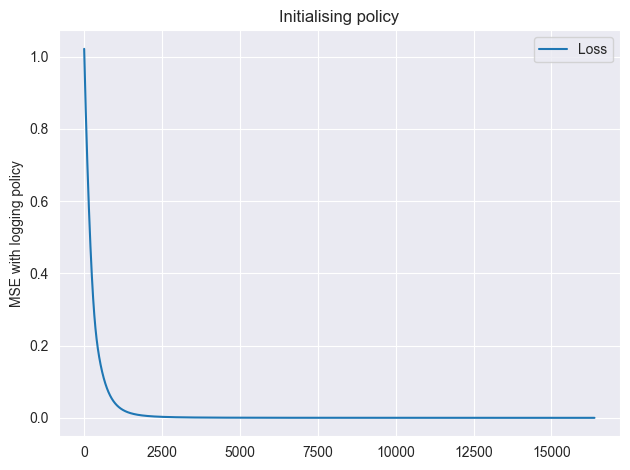

In [48]:
agent2net_utility, agent2gross_utility = run_repeated_auctions(num_iter_subscript=100)

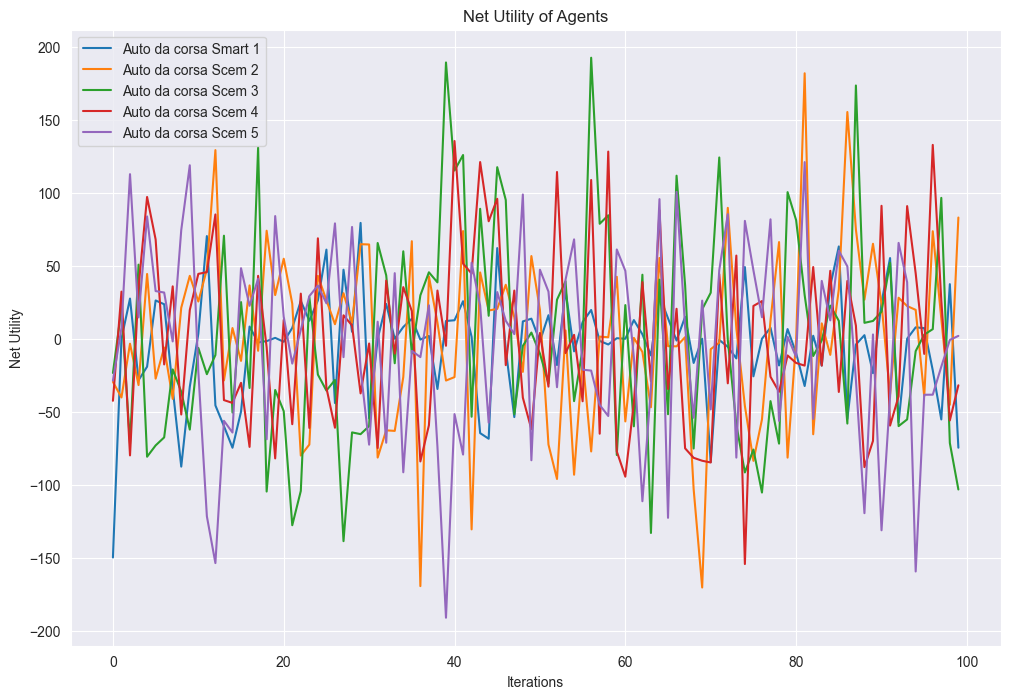

In [49]:
# Plot the net utility of all agents
plt.figure(figsize=(12, 8))

for key, values in agent2net_utility.items():
    plt.plot(range(len(values)), values, label=key)

plt.xlabel('Iterations')
plt.ylabel('Net Utility')
plt.title('Net Utility of Agents')
plt.legend()
plt.show()

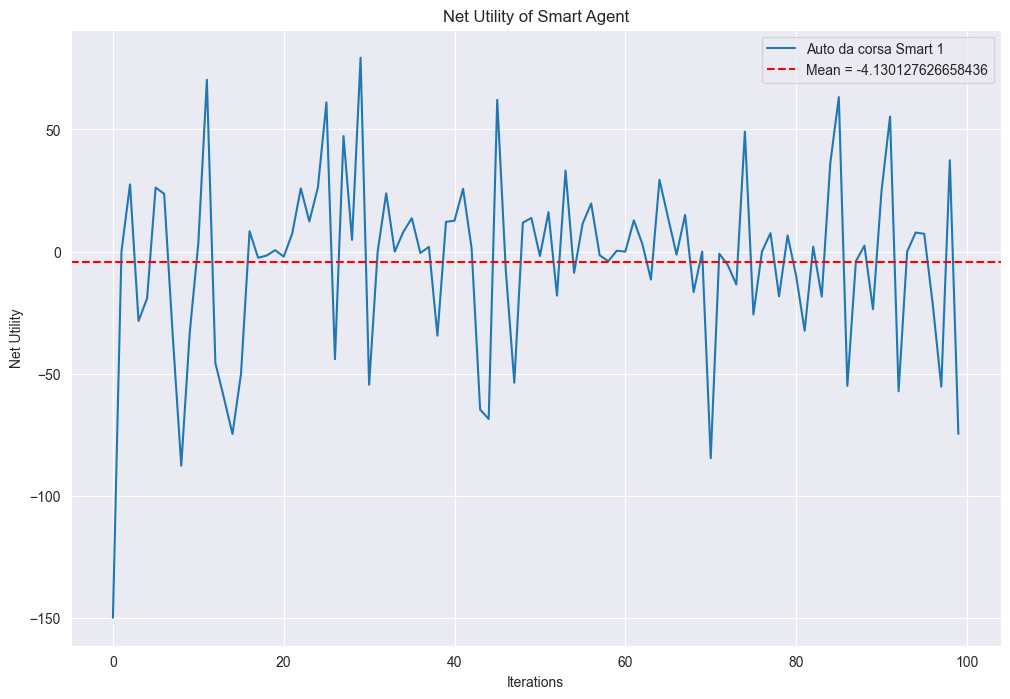

In [56]:
# Plot the net utility of Auto da corsa Smart 1 agent
smart_agent_name = 'Auto da corsa Smart 1'
smart_agent_val = agent2net_utility[smart_agent_name]
plt.figure(figsize=(12, 8))
plt.plot(range(len(smart_agent_val)), smart_agent_val, label=smart_agent_name)
plt.axhline(y=np.mean(smart_agent_val), color='r', linestyle='--', label=f'Mean = {np.mean(smart_agent_val)}')
plt.xlabel('Iterations')
plt.ylabel('Net Utility')
plt.title('Net Utility of Smart Agent')
plt.legend()
plt.show()

In [52]:
# Check if the smart agent has 0 utility
if not np.any(agent2net_utility['Auto da corsa Smart 1']==0.0):
    print('Smart agent always won at least one auction')
else:
    print('Smart agent lost at least one auction')

Smart agent always won at least one auction


In [51]:
# Mean utility of all agents
print('Mean utility of all agents')
for key, values in agent2net_utility.items():
    print(key, np.mean(values))

Mean utility of all agents
Auto da corsa Smart 1 -4.130127626658436
Auto da corsa Scem 2 0.7220828071960814
Auto da corsa Scem 3 -0.0881946846240524
Auto da corsa Scem 4 -0.18427656390268093
Auto da corsa Scem 5 -1.81685604445608


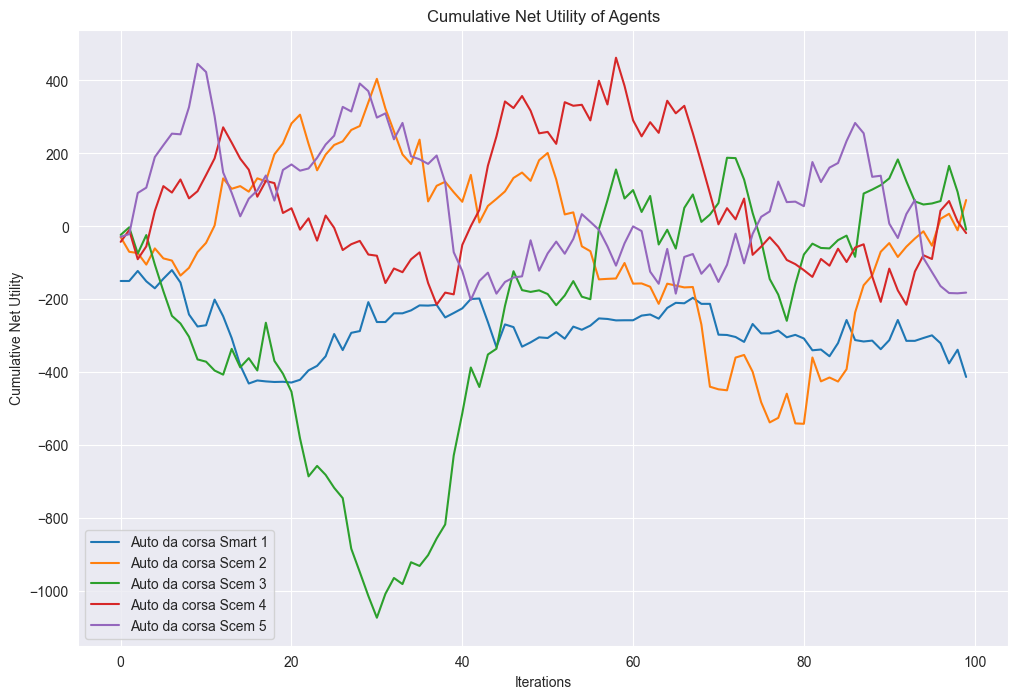

In [53]:
# Plot the cumulative net utility of all agents
plt.figure(figsize=(12, 8))

for key, values in agent2net_utility.items():
    plt.plot(range(len(values)), np.cumsum(values), label=key)
    
plt.xlabel('Iterations')
plt.ylabel('Cumulative Net Utility')
plt.title('Cumulative Net Utility of Agents')
plt.legend()
plt.show()